<a href="https://colab.research.google.com/github/ricardofelippe/Mapa/blob/main/Explorando_as_despesas_do_governo_federal_via_API_%5BEscola_de_Dados%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gastos públicos federais via API - Despesas e contratos

Este tutorial é baseado no workshop realizado por Fernanda Campagnucci, diretora-executiva da Open Knowledge Brasil, no Coda.Br 2019. O notebook foi atualizado por Adriano Belisário em setembro de 2020.

## API x Bases de Dados
---

Quem não tem fluência em programação, pode pasar por uma certa curva de aprendizagem para começar a usar APIs (*Application Programming Interface*). Em alguns casos, porém, você pode ganhar muito tempo se optar por consumir os dados via API, mesmo que demore mais para criar seu código pela primeira vez.

Confira abaixo uma comparação sobre as duas formas de acessar os dados. Mas atenção: essa comparação não é geral, ela se aplica especificamente ao Portal da Transparência do Governo Federal e à maneira como os dados estão disponibilizados hoje.

| Situação                       |   API           | Download de CSV  |
| :-------------                 | :-------------  | :------------- |
| Preciso de uma série histórica grande| +               | +++++          |
| Não faço pauta desse tema com frequência | ++               | +++++|
| Quero monitorar um assunto/cnpj/órgão etc | +++++               | +          |
| Quero conectar em um site ou visualização | ++++               | ++      |
| *Que outras situações ocorrem a vocês?* |               |      |




### Onde encontrar?

Para conhecer os dados disponíveis, sistema de origem, órgão responsável, periodicidade e data de atualização do Portal (download e API):

http://transparencia.gov.br/origem-dos-dados

- **Acesso via API**

http://www.transparencia.gov.br/swagger-ui.html

O Swagger é uma feramenta que documenta e permite explorar o conteúdo. Iremos falar mais sobre ela abaixo.

- **Bases para download**

http://transparencia.gov.br/download-de-dados

https://brasil.io/dataset/gastos-diretos/gastos (coletado e tratado por Álvaro Justen (Turicas) - tenha atenção para as datas de atualização no site)


## Planejamento e orçamento público
---

Agora que já sabemos onde encontrar os dados, vamos revisar algumas noções básicas sobre orçamento público, a começar com o diagrama abaixo, que é bastante didático e representa as etapas de elaboração das políticas públicas.


![O governo define prioridades que originam programas estruturados em ações, que objetivam resultados e metas, atingidos por meio da aquisição de bens e serviços, que são previstas em dotações orçamentárias. Fonte: Adaptado da aula da profa. Ursula Peres e Fabio Pereira (2016)](http://umdadoamais.com/wp-content/uploads/2019/11/tutorial_orcamento1-e1574301837420.png)




### Princípios do Orçamento

O orçamento público deve observar um conjunto de princípios presentes na Constituição e nas leis que regem o processo orçamentário no Brasil, em especial a Lei nº 4.320/1964 e a Lei nº 101/2000.

![alt text](http://umdadoamais.com/wp-content/uploads/2019/11/tutorial_orcamento2.png)


### Classificações de Despesa

Cada despesa do governo federal é classificada de acordo com os seguintes critérios.

![alt text](http://umdadoamais.com/wp-content/uploads/2019/11/tutorial_orcamento3.png)

Cada item da segunda coluna é representada por um código, que traz um identificador relacionado à despesa. Vejamos o exemplo abaixo.


![alt text](http://umdadoamais.com/wp-content/uploads/2019/11/Screen-Shot-2019-11-23-at-00.59.24.png)

Vamos fazer nosso primeiro exercício no Swagger? Com a [chave de acesso (**clique aqui para criar uma - esta etapa é fundamental para os próximos passos**)](http://www.portaldatransparencia.gov.br/api-de-dados/cadastrar-email) em mãos, entre na página a seguir e role a página até encontrar o formulário abaixo, que irá permitir consultarmos as despesas do Governo Federal de acordo com a função (o item verde escuro na ilustração acima): http://www.transparencia.gov.br/swagger-ui.html#!/Despesas32P250blicas/despesasPorFuncaoUsingGET

![alt text](http://umdadoamais.com/wp-content/uploads/2019/11/tutorial_orcamento6.png)

Preencha os campos com as informações acima e clique no botão 'Tente agora!'. Você deve ver o resultado em formato JSON, como na imagem abaixo. Além disso, preste atenção também no campo 'URL requisição'. Iremos utilizá-lo posteriormente, quando incorporarmos a URL da consulta desejada no código.

![alt text](http://umdadoamais.com/wp-content/uploads/2019/11/tutorial_orcamento7.png)

Para fins comparativos, imagine a mesma consulta, mas utilizando o download dos arquivos CSVs, ao invés da API. Neste caso, o trabalho seria bem maior. De forma resumida, seria preciso baixar cada mês e juntar todas bases, depois filtrar os valores desejados nas colunas e, enfim, somar os números registrados nos campos de valores empenhado, liquidado e pago.

## Mais referências
Para mais detalhes, vale a pena conferir esta documentação sobre o orçamento federal, que é frequentemente atualizada pelo governo no [Manual Técnico do Orçamento Federal](https://www1.siop.planejamento.gov.br/mto/lib/exe/fetch.php/mto2020:mto2020-versao5.pdf).(MTO 2020)


Há também um material do INESC, que explica o orçamento e sua relação com direitos humanos, na [Cartilha Orçamento e Direitos](https://www.inesc.org.br/orcamento-direitos-2018-2/) (2018).

# Acessando a API

---



Agora que já compreendemos o básico sobre como as despesas do governo federal são registradas, vamos colocar a mão na massa rodando alguns códigos em Python.

Iremos começar importando os pacotes que iremos utilizar.

Clique no botão de "Play" abaixo para executar o código. Se nenhum erro aparecer, então, deu tudo certo :)

In [49]:
import pandas as pd
import requests
import json
import numpy as np
from IPython.display import Image


### Despesas

Nosso primeiro exercício será coletar uma série histórica de despesas do Ministério do Meio Ambiente (um órgão superior, identificado pelo número 44000), utilizando um loop que irá consultar uma certa URL para cada ano entre 2016 e 2020.

Para descobrir o identificador de outros órgãos, você pode consultar o item 8.2 do [Manual Técnico do Orçamento](https://www1.siop.planejamento.gov.br/mto/lib/exe/fetch.php/mto2020:mto2020-versao5.pdf#page=153).

E é fundamental inserir uma [chave válida](http://www.portaldatransparencia.gov.br/api-de-dados/cadastrar-email) na variável abaixo.


In [50]:
# Troque os caracteres abaixo por uma chave válida, criada com seu email, usando o endereço abaixo
# http://www.portaldatransparencia.gov.br/api-de-dados/cadastrar-email
minha_chave = '3fd8bbb6a046fd05f768fb0b7fbefbb3'

# para conseguir acessar a API, precisamos incluir no cabeçalho da requisição a nossa chave, que definimos anteriormente. Não é necessário alterar essa variável.
chave = {'chave-api-dados':minha_chave}

In [52]:
serie_orgao = []

# O loop abaixo irá tomar como ponto de partido o intervalo de números entre 2019 e e 2019, incluindo estes dois.
# 
#
#
url = f'https://pncp.gov.br/api/consulta/v1/atas?anoAta=20240101&dataInicial=20240801&dataFinal=20240828&pagina=1'
    # esta URL foi gerada a partir da consulta por órgão no swagger

    # aqui, fazemos a consulta e obtemos o resultado para cada ano em JSON
r_orgao = requests.get(url, verify=True,headers=chave).json()

dados=r_orgao['data']
r_orgao=dados
    # e aqui juntamos os resultados de cada ano em uma série histórica do órgão


In [29]:
print(r_orgao)

{'numeroControlePNCPAta': '01612781000138-1-000021/2022-000001', 'numeroAtaRegistroPreco': '3', 'anoAta': 2023, 'numeroControlePNCPCompra': '01612781000138-1-000021/2022', 'cancelado': False, 'dataCancelamento': None, 'dataAssinatura': '2023-01-12', 'vigenciaInicio': '2023-01-12', 'vigenciaFim': '2025-01-12', 'dataPublicacaoPncp': '2023-01-12', 'dataInclusao': '2023-01-12', 'dataAtualizacao': '2024-01-08', 'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços', 'objetoContratacao': 'Despesa empenhada para prestacao de servico de horas maquinas para atender programas como abertura e reabertura de acudes  reabertura de estradas  transporte de silagem  cascalho e demais servicos disponibilizados pelas secretarias municipais de obras e servicos publicos e secretaria de agricultura e meio ambiente de Santiago do Sul  conforme Lei Municipal 1013 2021.', 'cnpjOrgao': '01612781000138', 'nomeOrgao': 'MUNICIPIO DE SANTIAGO DO SUL', 'cnpjOrgaoSubrogado': None, 'nomeOrgaoSubrogado': None, '

In [32]:
vigenciaInicio=list(map(lambda x:x["vigenciaInicio"],r_orgao))

In [53]:
numeroControlePNCPAta=list(map(lambda x:x["numeroControlePNCPAta"],r_orgao))
anoAta=list(map(lambda x:x["anoAta"],r_orgao))
cancelado=list(map(lambda x:x["cancelado"],r_orgao))
vigenciaInicio=list(map(lambda x:x["vigenciaInicio"],r_orgao))
vigenciaFim=list(map(lambda x:x["vigenciaFim"],r_orgao))
usuario=list(map(lambda x:x["usuario"],r_orgao))
objetoContratacao=list(map(lambda x:x["objetoContratacao"],r_orgao))
codigoUnidadeOrgao=list(map(lambda x:x["codigoUnidadeOrgao"],r_orgao))
nomeUnidadeOrgao=list(map(lambda x:x["nomeUnidadeOrgao"],r_orgao))


data = pd.DataFrame([numeroControlePNCPAta,anoAta, cancelado, vigenciaInicio,vigenciaFim,usuario,objetoContratacao,codigoUnidadeOrgao,nomeUnidadeOrgao]) # Each list would be added as a row
data = data.transpose() 
data.columns = ['numeroControlePNCPAta','anoAta', 'cancelado', 'vigenciaInicio',"vigenciaFim","usuario","objetoContratacao","codigoUnidadeOrgao","nomeUnidadeOrgao"]
 # Rename the

data.to_excel("output.xlsx",sheet_name='Sheet_name_1')  

In [93]:
# Analisando dataset
data.shape[0]
#data.columns
#type(data)


500

# Proximos Passos

1- filtrar usuário compras.gov.br
2- Anexar documentos da ata 

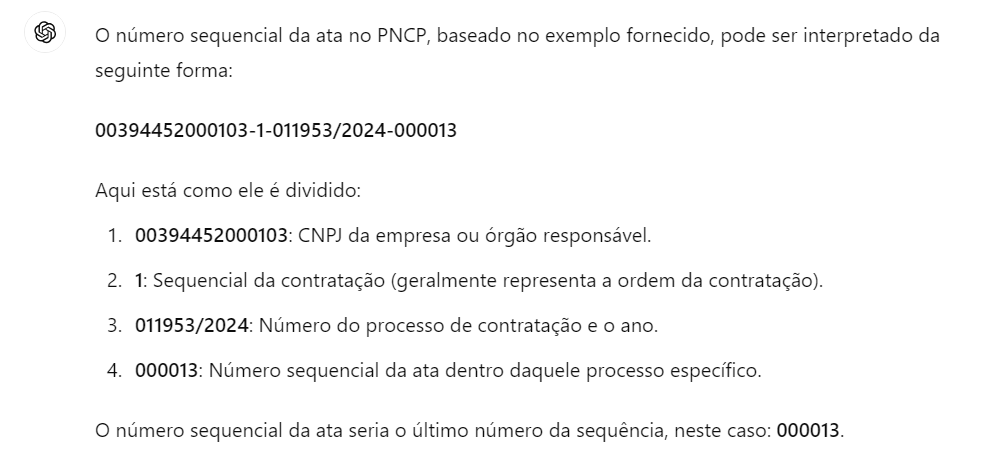

In [47]:
Image("explicacaoNumeracaoPNCP.png")


In [77]:
# Extraindo subconjunto de colunas
# Index(['numeroControlePNCPAta', 'anoAta', 'cancelado', 'vigenciaInicio',
    #    'vigenciaFim', 'usuario', 'objetoContratacao', 'codigoUnidadeOrgao',
    #    'nomeUnidadeOrgao'],
    #   dtype='object')
#url = f'https://pncp.gov.br/api/pncp/v1/orgaos/00394452000103/compras/2024/011953/atas/000003/arquivos'

cols = [0,1]
df = data[data.columns[cols]]
df

,numeroControlePNCPAta,anoAta
0,01612781000138-1-000021/2022-000001,2023
1,01612781000138-1-000020/2022-000001,2023
2,01612781000138-1-000024/2022-000001,2023
3,01612781000138-1-000022/2022-000001,2023
4,01612781000138-1-000027/2022-000001,2023
...,...,...
495,15126437000143-1-000657/2023-000002,2023
496,15126437000143-1-000288/2023-000023,2023
497,15126437000143-1-000288/2023-000024,2023
498,15126437000143-1-000288/2023-000025,2023


In [107]:
# URL BASE= https://pncp.gov.br/api/pncp/v1/orgaos/{cnpj}/compras/{anoCompra}/{sequencialCompra/atas/{sequencialAta}/arquivos
# 01612781000138-1-000020/2022-000001
cnpj=df.numeroControlePNCPAta.str[:14]
sequencialCompra=df.numeroControlePNCPAta.str[17:23]
anoCompra=df.numeroControlePNCPAta.str[24:28]
sequencialAta=df.numeroControlePNCPAta.str[29:35]
DocAta=pd.DataFrame([cnpj,anoCompra, sequencialCompra,sequencialAta])
DocAta = DocAta.transpose() 
DocAta.columns = ['cnpj','anoCompra','sequencialCompra','sequencialAta']
DocAta

DocAta




,cnpj,anoCompra,sequencialCompra,sequencialAta
0,01612781000138,2022,000021,000001
1,01612781000138,2022,000020,000001
2,01612781000138,2022,000024,000001
3,01612781000138,2022,000022,000001
4,01612781000138,2022,000027,000001
...,...,...,...,...
495,15126437000143,2023,000657,000002
496,15126437000143,2023,000288,000023
497,15126437000143,2023,000288,000024
498,15126437000143,2023,000288,000025


In [108]:
i=2
DocAta.loc[i, 'cnpj']
numLinhas=DocAta.shape[0]

In [135]:
numLinhas=DocAta.shape[0]
urlAtas=[]
for i in range(numLinhas):
    cnpj=DocAta.loc[i, 'cnpj']
    anoCompra=DocAta.loc[i, 'anoCompra']
    sequencialCompra=DocAta.loc[i, 'sequencialCompra']
    sequencialAta=DocAta.loc[i, 'sequencialAta']

    url1 = f'https://pncp.gov.br/api/pncp/v1/orgaos/{cnpj}/compras/{anoCompra}/{sequencialCompra}/atas/{sequencialAta}/arquivos'
    # esta URL foi gerada a partir da consulta por órgão no swagger
    #temp=url1[0]['url']
    response = requests.get(url1, verify=True, headers=chave)

    # Verifica se o tipo de conteúdo é JSON
    if 'application/json' in response.headers.get('Content-Type', ''):
        data = response.json()  # Tenta parsear como JSON
        temp = requests.get(url1, verify=True,headers=chave).json()
        temp=temp[0]['url']
    else:
        temp=""

      
    
    #temp
    urlAtas.append(temp)

    # aqui, fazemos a consulta e obtemos o resultado para cada ano em JSON
    

In [138]:
urlAtas

['https://pncp.gov.br/pncp-api/v1/orgaos/01612781000138/compras/2022/000021/atas/000001/arquivos/1',
 'https://pncp.gov.br/pncp-api/v1/orgaos/01612781000138/compras/2022/000020/atas/000001/arquivos/1',
 'https://pncp.gov.br/pncp-api/v1/orgaos/01612781000138/compras/2022/000024/atas/000001/arquivos/1',
 'https://pncp.gov.br/pncp-api/v1/orgaos/01612781000138/compras/2022/000022/atas/000001/arquivos/1',
 'https://pncp.gov.br/pncp-api/v1/orgaos/01612781000138/compras/2022/000027/atas/000001/arquivos/1',
 'https://pncp.gov.br/pncp-api/v1/orgaos/01612781000138/compras/2022/000028/atas/000001/arquivos/1',
 'https://pncp.gov.br/pncp-api/v1/orgaos/90738196000109/compras/2023/000025/atas/000001/arquivos/1',
 'https://pncp.gov.br/pncp-api/v1/orgaos/90738196000109/compras/2023/000025/atas/000002/arquivos/1',
 'https://pncp.gov.br/pncp-api/v1/orgaos/90738196000109/compras/2023/000025/atas/000003/arquivos/1',
 'https://pncp.gov.br/pncp-api/v1/orgaos/90738196000109/compras/2023/000025/atas/000005/arq

In [ ]:
https://pncp.gov.br/api/pncp/v1/orgaos/01612781000138/compras/2022/000021/atas/000001/arquivos

In [139]:
df_urlAtas=pd.DataFrame(urlAtas)
#df_urlAtas
df_urlAtas.shape
data = pd.DataFrame([numeroControlePNCPAta,anoAta, cancelado, vigenciaInicio,vigenciaFim,usuario,objetoContratacao,codigoUnidadeOrgao,nomeUnidadeOrgao,urlAtas]) # Each list would be added as a row
data = data.transpose() 
data.columns = ['numeroControlePNCPAta','anoAta', 'cancelado', 'vigenciaInicio',"vigenciaFim","usuario","objetoContratacao","codigoUnidadeOrgao","nomeUnidadeOrgao","urlAtas"]
 # Rename the

data.to_excel("output.xlsx",sheet_name='Sheet_name_1')  



In [96]:
# Join com o Dataset final
DocAta=pd.DataFrame([cnpj,anoCompra, sequencialCompra,sequencialAta, urlAtas])
DocAta = DocAta.transpose() 
DocAta.columns = ['cnpj','anoCompra','sequencialCompra','url']
DocAta



ValueError: Length mismatch: Expected axis has 5 elements, new values have 4 elements

In [55]:
# Anexando documentos da ata no dataset
# URL BASE= https://pncp.gov.br/api/pncp/v1/orgaos/{cnpj}/compras/{anoCompra}/{sequencialCompra/atas/{sequencialAta}/arquivos

for ano in range(2016, 2019):

    url = f'http://www.transparencia.gov.br/api-de-dados/despesas/por-orgao?ano={ano}&orgaoSuperior=44000&pagina=1'
    # esta URL foi gerada a partir da consulta por órgão no swagger
   
    # aqui, fazemos a consulta e obtemos o resultado para cada ano em JSON
    r_orgao = requests.get(url, verify=True,headers=chave).json()







<class 'list'>


In [ ]:
vigenciaInicio

In [ ]:
x

In [42]:
r_orgao.keys()

AttributeError: 'list' object has no attribute 'keys'

In [39]:
r_orgao=[{'numeroControlePNCPAta': '01612781000138-1-000021/2022-000001',
   'numeroAtaRegistroPreco': '3',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '01612781000138-1-000021/2022',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-01-12',
   'vigenciaInicio': '2023-01-12',
   'vigenciaFim': '2025-01-12',
   'dataPublicacaoPncp': '2023-01-12',
   'dataInclusao': '2023-01-12',
   'dataAtualizacao': '2024-01-08',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Despesa empenhada para prestacao de servico de horas maquinas para atender programas como abertura e reabertura de acudes  reabertura de estradas  transporte de silagem  cascalho e demais servicos disponibilizados pelas secretarias municipais de obras e servicos publicos e secretaria de agricultura e meio ambiente de Santiago do Sul  conforme Lei Municipal 1013 2021.',
   'cnpjOrgao': '01612781000138',
   'nomeOrgao': 'MUNICIPIO DE SANTIAGO DO SUL',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'Prefeitura Municipal de Santiago do Sul',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '01612781000138-1-000020/2022-000001',
   'numeroAtaRegistroPreco': '1',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '01612781000138-1-000020/2022',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-01-04',
   'vigenciaInicio': '2023-01-04',
   'vigenciaFim': '2025-01-03',
   'dataPublicacaoPncp': '2023-01-12',
   'dataInclusao': '2023-01-12',
   'dataAtualizacao': '2023-12-26',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Registro de Precos para futura Aquisicao de combustiveis para abastecimento dos veiculos da frota do Municipio e Fundo Municipal de Saude de Santiago do Sul  com abastecimento direto nos tanques dos veiculos da frota municipal  com unidade de abastecimento localizada na sede do municipio de Santiago do Sul SC.',
   'cnpjOrgao': '01612781000138',
   'nomeOrgao': 'MUNICIPIO DE SANTIAGO DO SUL',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'Prefeitura Municipal de Santiago do Sul',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '01612781000138-1-000024/2022-000001',
   'numeroAtaRegistroPreco': '2',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '01612781000138-1-000024/2022',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-01-10',
   'vigenciaInicio': '2023-01-10',
   'vigenciaFim': '2025-01-10',
   'dataPublicacaoPncp': '2023-01-12',
   'dataInclusao': '2023-01-12',
   'dataAtualizacao': '2024-01-08',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Despesa empenhada registro de preco para futura e eventual prestacao de servico de lavagem  coserto  montagem e desmontagem de pneus dos veiculos e maquinas das secretarias municipais e fundo municipal de saude.',
   'cnpjOrgao': '01612781000138',
   'nomeOrgao': 'MUNICIPIO DE SANTIAGO DO SUL',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'Prefeitura Municipal de Santiago do Sul',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '01612781000138-1-000022/2022-000001',
   'numeroAtaRegistroPreco': '4',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '01612781000138-1-000022/2022',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-01-23',
   'vigenciaInicio': '2023-01-23',
   'vigenciaFim': '2025-01-23',
   'dataPublicacaoPncp': '2023-01-24',
   'dataInclusao': '2023-01-24',
   'dataAtualizacao': '2024-02-09',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Registro de precos para futura Aquisicao de materiais didaticos para alunos do ensino fundamental da Escola municipal Pequeno Cidadao  professores e assessoria pedagogica.',
   'cnpjOrgao': '01612781000138',
   'nomeOrgao': 'MUNICIPIO DE SANTIAGO DO SUL',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'Prefeitura Municipal de Santiago do Sul',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '01612781000138-1-000027/2022-000001',
   'numeroAtaRegistroPreco': '7',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '01612781000138-1-000027/2022',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-02-09',
   'vigenciaInicio': '2023-02-09',
   'vigenciaFim': '2025-02-09',
   'dataPublicacaoPncp': '2023-02-15',
   'dataInclusao': '2023-02-15',
   'dataAtualizacao': '2024-02-08',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Registro de preco para futura e eventual aquisicao de materiais de construcao  alem de prestacao de servico de mao de obra de pedreiro  carpinteiro  pintor para manutencao nos espacos publicos e predios publicos das secretarias municipais e do fundo municipal de saude do municipio de Santiago do Sul SC.',
   'cnpjOrgao': '01612781000138',
   'nomeOrgao': 'MUNICIPIO DE SANTIAGO DO SUL',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'Prefeitura Municipal de Santiago do Sul',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '01612781000138-1-000028/2022-000001',
   'numeroAtaRegistroPreco': '8',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '01612781000138-1-000028/2022',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-02-10',
   'vigenciaInicio': '2023-02-10',
   'vigenciaFim': '2025-02-10',
   'dataPublicacaoPncp': '2023-02-15',
   'dataInclusao': '2023-02-15',
   'dataAtualizacao': '2024-02-09',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Registro de preco para futura e eventual contratacao de servicos de arbitragem para campeonatos esportivos promovidos pelo municipio de Santiago do Sul   SC.',
   'cnpjOrgao': '01612781000138',
   'nomeOrgao': 'MUNICIPIO DE SANTIAGO DO SUL',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'Prefeitura Municipal de Santiago do Sul',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '90738196000109-1-000025/2023-000001',
   'numeroAtaRegistroPreco': '23',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '90738196000109-1-000025/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-03-19',
   'vigenciaInicio': '2023-03-19',
   'vigenciaFim': '2025-03-19',
   'dataPublicacaoPncp': '2023-03-13',
   'dataInclusao': '2023-03-13',
   'dataAtualizacao': '2024-04-09',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Registro de preco para aquisicao de materiais de expediente.',
   'cnpjOrgao': '90738196000109',
   'nomeOrgao': 'MUNICIPIO DE IJUI',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'MUNICÍPIO DE IJUÍ - PODER EXECUTIVO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '90738196000109-1-000025/2023-000002',
   'numeroAtaRegistroPreco': '21',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '90738196000109-1-000025/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-03-19',
   'vigenciaInicio': '2023-03-19',
   'vigenciaFim': '2025-03-19',
   'dataPublicacaoPncp': '2023-03-13',
   'dataInclusao': '2023-03-13',
   'dataAtualizacao': '2024-04-09',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Registro de preco para aquisicao de materiais de expediente.',
   'cnpjOrgao': '90738196000109',
   'nomeOrgao': 'MUNICIPIO DE IJUI',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'MUNICÍPIO DE IJUÍ - PODER EXECUTIVO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '90738196000109-1-000025/2023-000003',
   'numeroAtaRegistroPreco': '30',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '90738196000109-1-000025/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-03-19',
   'vigenciaInicio': '2023-03-19',
   'vigenciaFim': '2025-03-19',
   'dataPublicacaoPncp': '2023-03-13',
   'dataInclusao': '2023-03-13',
   'dataAtualizacao': '2024-04-09',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Registro de preco para aquisicao de materiais de expediente.',
   'cnpjOrgao': '90738196000109',
   'nomeOrgao': 'MUNICIPIO DE IJUI',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'MUNICÍPIO DE IJUÍ - PODER EXECUTIVO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '90738196000109-1-000025/2023-000005',
   'numeroAtaRegistroPreco': '22',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '90738196000109-1-000025/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-03-19',
   'vigenciaInicio': '2023-03-19',
   'vigenciaFim': '2025-03-19',
   'dataPublicacaoPncp': '2023-03-13',
   'dataInclusao': '2023-03-13',
   'dataAtualizacao': '2024-04-09',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Registro de preco para aquisicao de materiais de expediente.',
   'cnpjOrgao': '90738196000109',
   'nomeOrgao': 'MUNICIPIO DE IJUI',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'MUNICÍPIO DE IJUÍ - PODER EXECUTIVO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '90738196000109-1-000025/2023-000007',
   'numeroAtaRegistroPreco': '33',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '90738196000109-1-000025/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-03-19',
   'vigenciaInicio': '2023-03-19',
   'vigenciaFim': '2025-03-19',
   'dataPublicacaoPncp': '2023-03-13',
   'dataInclusao': '2023-03-13',
   'dataAtualizacao': '2024-04-09',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Registro de preco para aquisicao de materiais de expediente.',
   'cnpjOrgao': '90738196000109',
   'nomeOrgao': 'MUNICIPIO DE IJUI',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'MUNICÍPIO DE IJUÍ - PODER EXECUTIVO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '90738196000109-1-000025/2023-000009',
   'numeroAtaRegistroPreco': '20',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '90738196000109-1-000025/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-03-19',
   'vigenciaInicio': '2023-03-19',
   'vigenciaFim': '2025-03-19',
   'dataPublicacaoPncp': '2023-03-13',
   'dataInclusao': '2023-03-13',
   'dataAtualizacao': '2024-04-09',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Registro de preco para aquisicao de materiais de expediente.',
   'cnpjOrgao': '90738196000109',
   'nomeOrgao': 'MUNICIPIO DE IJUI',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'MUNICÍPIO DE IJUÍ - PODER EXECUTIVO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '90738196000109-1-000025/2023-000010',
   'numeroAtaRegistroPreco': '24',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '90738196000109-1-000025/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-03-19',
   'vigenciaInicio': '2023-03-19',
   'vigenciaFim': '2025-03-19',
   'dataPublicacaoPncp': '2023-03-13',
   'dataInclusao': '2023-03-13',
   'dataAtualizacao': '2024-04-09',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Registro de preco para aquisicao de materiais de expediente.',
   'cnpjOrgao': '90738196000109',
   'nomeOrgao': 'MUNICIPIO DE IJUI',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'MUNICÍPIO DE IJUÍ - PODER EXECUTIVO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '90738196000109-1-000025/2023-000011',
   'numeroAtaRegistroPreco': '25',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '90738196000109-1-000025/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-03-19',
   'vigenciaInicio': '2023-03-19',
   'vigenciaFim': '2025-03-19',
   'dataPublicacaoPncp': '2023-03-13',
   'dataInclusao': '2023-03-13',
   'dataAtualizacao': '2024-04-09',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Registro de preco para aquisicao de materiais de expediente.',
   'cnpjOrgao': '90738196000109',
   'nomeOrgao': 'MUNICIPIO DE IJUI',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'MUNICÍPIO DE IJUÍ - PODER EXECUTIVO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '90738196000109-1-000025/2023-000012',
   'numeroAtaRegistroPreco': '26',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '90738196000109-1-000025/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-03-19',
   'vigenciaInicio': '2023-03-19',
   'vigenciaFim': '2025-03-19',
   'dataPublicacaoPncp': '2023-03-13',
   'dataInclusao': '2023-03-13',
   'dataAtualizacao': '2024-04-09',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Registro de preco para aquisicao de materiais de expediente.',
   'cnpjOrgao': '90738196000109',
   'nomeOrgao': 'MUNICIPIO DE IJUI',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'MUNICÍPIO DE IJUÍ - PODER EXECUTIVO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '90738196000109-1-000025/2023-000013',
   'numeroAtaRegistroPreco': '27',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '90738196000109-1-000025/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-03-19',
   'vigenciaInicio': '2023-03-19',
   'vigenciaFim': '2025-03-19',
   'dataPublicacaoPncp': '2023-03-13',
   'dataInclusao': '2023-03-13',
   'dataAtualizacao': '2024-04-09',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Registro de preco para aquisicao de materiais de expediente.',
   'cnpjOrgao': '90738196000109',
   'nomeOrgao': 'MUNICIPIO DE IJUI',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'MUNICÍPIO DE IJUÍ - PODER EXECUTIVO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '90738196000109-1-000025/2023-000014',
   'numeroAtaRegistroPreco': '28',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '90738196000109-1-000025/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-03-19',
   'vigenciaInicio': '2023-03-19',
   'vigenciaFim': '2025-03-19',
   'dataPublicacaoPncp': '2023-03-13',
   'dataInclusao': '2023-03-13',
   'dataAtualizacao': '2024-04-09',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Registro de preco para aquisicao de materiais de expediente.',
   'cnpjOrgao': '90738196000109',
   'nomeOrgao': 'MUNICIPIO DE IJUI',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'MUNICÍPIO DE IJUÍ - PODER EXECUTIVO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '90738196000109-1-000025/2023-000015',
   'numeroAtaRegistroPreco': '29',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '90738196000109-1-000025/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-03-19',
   'vigenciaInicio': '2023-03-19',
   'vigenciaFim': '2025-03-19',
   'dataPublicacaoPncp': '2023-03-13',
   'dataInclusao': '2023-03-13',
   'dataAtualizacao': '2024-04-09',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Registro de preco para aquisicao de materiais de expediente.',
   'cnpjOrgao': '90738196000109',
   'nomeOrgao': 'MUNICIPIO DE IJUI',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'MUNICÍPIO DE IJUÍ - PODER EXECUTIVO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '90738196000109-1-000025/2023-000016',
   'numeroAtaRegistroPreco': '32',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '90738196000109-1-000025/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-03-19',
   'vigenciaInicio': '2023-03-19',
   'vigenciaFim': '2025-03-19',
   'dataPublicacaoPncp': '2023-03-13',
   'dataInclusao': '2023-03-13',
   'dataAtualizacao': '2024-04-09',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Registro de preco para aquisicao de materiais de expediente.',
   'cnpjOrgao': '90738196000109',
   'nomeOrgao': 'MUNICIPIO DE IJUI',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'MUNICÍPIO DE IJUÍ - PODER EXECUTIVO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '90738196000109-1-000025/2023-000017',
   'numeroAtaRegistroPreco': '31',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '90738196000109-1-000025/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-03-19',
   'vigenciaInicio': '2023-03-19',
   'vigenciaFim': '2025-03-19',
   'dataPublicacaoPncp': '2023-03-13',
   'dataInclusao': '2023-03-13',
   'dataAtualizacao': '2024-04-09',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Registro de preco para aquisicao de materiais de expediente.',
   'cnpjOrgao': '90738196000109',
   'nomeOrgao': 'MUNICIPIO DE IJUI',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'MUNICÍPIO DE IJUÍ - PODER EXECUTIVO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '73449977000164-1-000003/2023-000002',
   'numeroAtaRegistroPreco': '32',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '73449977000164-1-000003/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-03-09',
   'vigenciaInicio': '2023-03-09',
   'vigenciaFim': '2025-03-08',
   'dataPublicacaoPncp': '2023-03-14',
   'dataInclusao': '2023-03-14',
   'dataAtualizacao': '2024-03-06',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'REGISTRO DE PRECOS PARA EVENTUAL CONTRATACAO DE EMPRESA ESPECIALIZADA PARA AQUISICAO DE KITS DE DIAGNOSTICO PARA TOXOPLASMOSE IGM  IGG E SIFILIS   VDRL  TIPO RPR  QUE SERAO UTILIZADOS NO LABORATORIO DE ANALISES CLINICAS DO CONSORCIO INTERMUNICIPAL DE SAUDE COSTA OESTE DO PARANA   CISCOPAR  PELO PERIODO DE 12  DOZE  MESES',
   'cnpjOrgao': '73449977000164',
   'nomeOrgao': 'CONSORCIO INTERMUNICIPAL DE SAUDE COSTA OESTE DO PARANA',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'Consorcio Interm. de Saude CISCOPAR',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '19391945000100-1-000004/2023-000003',
   'numeroAtaRegistroPreco': '08',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '19391945000100-1-000004/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-03-13',
   'vigenciaInicio': '2023-03-13',
   'vigenciaFim': '2025-03-13',
   'dataPublicacaoPncp': '2023-04-13',
   'dataInclusao': '2023-04-13',
   'dataAtualizacao': '2023-04-13',
   'usuario': 'Licitar Digital - Plataforma de Licitações Online',
   'objetoContratacao': 'Registro de preço visando a contratação de empresa para eventual e futura prestação de serviços de publicações de editais de licitações e outros atos públicos em jornal de grande circulação no Estado, no Diário Oficial do Estado de Minas Gerais e no Diário Oficial da União.',
   'cnpjOrgao': '19391945000100',
   'nomeOrgao': 'MUNICIPIO DE SANTA BARBARA',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '20',
   'nomeUnidadeOrgao': 'Unidade Única',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '94577574000170-1-000001/2023-000001',
   'numeroAtaRegistroPreco': '22',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '94577574000170-1-000001/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-04-20',
   'vigenciaInicio': '2023-04-24',
   'vigenciaFim': '2025-04-23',
   'dataPublicacaoPncp': '2023-04-24',
   'dataInclusao': '2023-04-24',
   'dataAtualizacao': '2024-04-24',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Registro de precos para futura aquisicao de material hidraulico',
   'cnpjOrgao': '94577574000170',
   'nomeOrgao': 'MUNICIPIO DE VALE DO SOL',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'PREFEITURA MUNICIPAL',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '94577574000170-1-000001/2023-000003',
   'numeroAtaRegistroPreco': '31',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '94577574000170-1-000001/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-04-24',
   'vigenciaInicio': '2023-04-24',
   'vigenciaFim': '2025-04-23',
   'dataPublicacaoPncp': '2023-04-24',
   'dataInclusao': '2023-04-24',
   'dataAtualizacao': '2024-04-24',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Registro de precos para futura aquisicao de material hidraulico',
   'cnpjOrgao': '94577574000170',
   'nomeOrgao': 'MUNICIPIO DE VALE DO SOL',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'PREFEITURA MUNICIPAL',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '94577574000170-1-000001/2023-000005',
   'numeroAtaRegistroPreco': '29',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '94577574000170-1-000001/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-04-24',
   'vigenciaInicio': '2023-04-24',
   'vigenciaFim': '2025-04-23',
   'dataPublicacaoPncp': '2023-04-24',
   'dataInclusao': '2023-04-24',
   'dataAtualizacao': '2024-04-24',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Registro de precos para futura aquisicao de material hidraulico',
   'cnpjOrgao': '94577574000170',
   'nomeOrgao': 'MUNICIPIO DE VALE DO SOL',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'PREFEITURA MUNICIPAL',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '94577574000170-1-000001/2023-000006',
   'numeroAtaRegistroPreco': '28',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '94577574000170-1-000001/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-04-24',
   'vigenciaInicio': '2023-04-24',
   'vigenciaFim': '2025-04-23',
   'dataPublicacaoPncp': '2023-04-24',
   'dataInclusao': '2023-04-24',
   'dataAtualizacao': '2024-04-24',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Registro de precos para futura aquisicao de material hidraulico',
   'cnpjOrgao': '94577574000170',
   'nomeOrgao': 'MUNICIPIO DE VALE DO SOL',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'PREFEITURA MUNICIPAL',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '94577574000170-1-000001/2023-000007',
   'numeroAtaRegistroPreco': '33',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '94577574000170-1-000001/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-04-24',
   'vigenciaInicio': '2023-04-24',
   'vigenciaFim': '2025-04-23',
   'dataPublicacaoPncp': '2023-04-24',
   'dataInclusao': '2023-04-24',
   'dataAtualizacao': '2024-05-16',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Registro de precos para futura aquisicao de material hidraulico',
   'cnpjOrgao': '94577574000170',
   'nomeOrgao': 'MUNICIPIO DE VALE DO SOL',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'PREFEITURA MUNICIPAL',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '94577574000170-1-000001/2023-000008',
   'numeroAtaRegistroPreco': '26',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '94577574000170-1-000001/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-04-24',
   'vigenciaInicio': '2023-04-24',
   'vigenciaFim': '2025-04-23',
   'dataPublicacaoPncp': '2023-04-24',
   'dataInclusao': '2023-04-24',
   'dataAtualizacao': '2024-05-23',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Registro de precos para futura aquisicao de material hidraulico',
   'cnpjOrgao': '94577574000170',
   'nomeOrgao': 'MUNICIPIO DE VALE DO SOL',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'PREFEITURA MUNICIPAL',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '94577574000170-1-000001/2023-000009',
   'numeroAtaRegistroPreco': '25',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '94577574000170-1-000001/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-04-24',
   'vigenciaInicio': '2023-04-24',
   'vigenciaFim': '2025-04-23',
   'dataPublicacaoPncp': '2023-04-24',
   'dataInclusao': '2023-04-24',
   'dataAtualizacao': '2024-04-24',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Registro de precos para futura aquisicao de material hidraulico',
   'cnpjOrgao': '94577574000170',
   'nomeOrgao': 'MUNICIPIO DE VALE DO SOL',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'PREFEITURA MUNICIPAL',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '94577574000170-1-000001/2023-000010',
   'numeroAtaRegistroPreco': '24',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '94577574000170-1-000001/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-04-24',
   'vigenciaInicio': '2023-04-24',
   'vigenciaFim': '2025-04-23',
   'dataPublicacaoPncp': '2023-04-24',
   'dataInclusao': '2023-04-24',
   'dataAtualizacao': '2024-04-24',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Registro de precos para futura aquisicao de material hidraulico',
   'cnpjOrgao': '94577574000170',
   'nomeOrgao': 'MUNICIPIO DE VALE DO SOL',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'PREFEITURA MUNICIPAL',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '94577574000170-1-000001/2023-000011',
   'numeroAtaRegistroPreco': '23',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '94577574000170-1-000001/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-04-24',
   'vigenciaInicio': '2023-04-24',
   'vigenciaFim': '2025-04-23',
   'dataPublicacaoPncp': '2023-04-24',
   'dataInclusao': '2023-04-24',
   'dataAtualizacao': '2024-05-16',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Registro de precos para futura aquisicao de material hidraulico',
   'cnpjOrgao': '94577574000170',
   'nomeOrgao': 'MUNICIPIO DE VALE DO SOL',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'PREFEITURA MUNICIPAL',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '94577574000170-1-000002/2023-000001',
   'numeroAtaRegistroPreco': '38',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '94577574000170-1-000002/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-04-26',
   'vigenciaInicio': '2023-04-26',
   'vigenciaFim': '2025-04-25',
   'dataPublicacaoPncp': '2023-04-26',
   'dataInclusao': '2023-04-26',
   'dataAtualizacao': '2024-04-24',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Registro de precos para futura aquisicao de material hidraulico em PEAD',
   'cnpjOrgao': '94577574000170',
   'nomeOrgao': 'MUNICIPIO DE VALE DO SOL',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'PREFEITURA MUNICIPAL',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '94577574000170-1-000002/2023-000002',
   'numeroAtaRegistroPreco': '39',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '94577574000170-1-000002/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-04-26',
   'vigenciaInicio': '2023-04-26',
   'vigenciaFim': '2025-04-25',
   'dataPublicacaoPncp': '2023-04-26',
   'dataInclusao': '2023-04-26',
   'dataAtualizacao': '2024-04-24',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Registro de precos para futura aquisicao de material hidraulico em PEAD',
   'cnpjOrgao': '94577574000170',
   'nomeOrgao': 'MUNICIPIO DE VALE DO SOL',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'PREFEITURA MUNICIPAL',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '94577574000170-1-000002/2023-000003',
   'numeroAtaRegistroPreco': '40',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '94577574000170-1-000002/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-04-26',
   'vigenciaInicio': '2023-04-26',
   'vigenciaFim': '2025-04-25',
   'dataPublicacaoPncp': '2023-04-26',
   'dataInclusao': '2023-04-26',
   'dataAtualizacao': '2024-04-24',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Registro de precos para futura aquisicao de material hidraulico em PEAD',
   'cnpjOrgao': '94577574000170',
   'nomeOrgao': 'MUNICIPIO DE VALE DO SOL',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'PREFEITURA MUNICIPAL',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '94577574000170-1-000002/2023-000004',
   'numeroAtaRegistroPreco': '41',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '94577574000170-1-000002/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-04-26',
   'vigenciaInicio': '2023-04-26',
   'vigenciaFim': '2025-04-25',
   'dataPublicacaoPncp': '2023-04-26',
   'dataInclusao': '2023-04-26',
   'dataAtualizacao': '2024-04-24',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Registro de precos para futura aquisicao de material hidraulico em PEAD',
   'cnpjOrgao': '94577574000170',
   'nomeOrgao': 'MUNICIPIO DE VALE DO SOL',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'PREFEITURA MUNICIPAL',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '94577574000170-1-000002/2023-000005',
   'numeroAtaRegistroPreco': '34',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '94577574000170-1-000002/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-04-26',
   'vigenciaInicio': '2023-04-26',
   'vigenciaFim': '2025-04-25',
   'dataPublicacaoPncp': '2023-04-26',
   'dataInclusao': '2023-04-26',
   'dataAtualizacao': '2024-05-16',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Registro de precos para futura aquisicao de material hidraulico em PEAD',
   'cnpjOrgao': '94577574000170',
   'nomeOrgao': 'MUNICIPIO DE VALE DO SOL',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'PREFEITURA MUNICIPAL',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '94577574000170-1-000002/2023-000006',
   'numeroAtaRegistroPreco': '35',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '94577574000170-1-000002/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-04-26',
   'vigenciaInicio': '2023-04-26',
   'vigenciaFim': '2025-04-25',
   'dataPublicacaoPncp': '2023-04-26',
   'dataInclusao': '2023-04-26',
   'dataAtualizacao': '2024-04-26',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Registro de precos para futura aquisicao de material hidraulico em PEAD',
   'cnpjOrgao': '94577574000170',
   'nomeOrgao': 'MUNICIPIO DE VALE DO SOL',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'PREFEITURA MUNICIPAL',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '94577574000170-1-000002/2023-000008',
   'numeroAtaRegistroPreco': '37',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '94577574000170-1-000002/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-04-26',
   'vigenciaInicio': '2023-04-26',
   'vigenciaFim': '2025-04-25',
   'dataPublicacaoPncp': '2023-04-26',
   'dataInclusao': '2023-04-26',
   'dataAtualizacao': '2024-04-24',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Registro de precos para futura aquisicao de material hidraulico em PEAD',
   'cnpjOrgao': '94577574000170',
   'nomeOrgao': 'MUNICIPIO DE VALE DO SOL',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'PREFEITURA MUNICIPAL',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '90738196000109-1-000187/2023-000001',
   'numeroAtaRegistroPreco': '78',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '90738196000109-1-000187/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-04-18',
   'vigenciaInicio': '2023-04-18',
   'vigenciaFim': '2025-04-18',
   'dataPublicacaoPncp': '2023-05-11',
   'dataInclusao': '2023-05-11',
   'dataAtualizacao': '2024-04-16',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Registro de Precos para aquisicao de equipamentos de protecao e seguranca para Secretaria Municipal De Meio Ambiente.',
   'cnpjOrgao': '90738196000109',
   'nomeOrgao': 'MUNICIPIO DE IJUI',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'MUNICÍPIO DE IJUÍ - PODER EXECUTIVO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '90738196000109-1-000187/2023-000002',
   'numeroAtaRegistroPreco': '82',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '90738196000109-1-000187/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-04-18',
   'vigenciaInicio': '2023-04-18',
   'vigenciaFim': '2025-04-18',
   'dataPublicacaoPncp': '2023-05-11',
   'dataInclusao': '2023-05-11',
   'dataAtualizacao': '2024-04-16',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Registro de Precos para aquisicao de equipamentos de protecao e seguranca para Secretaria Municipal De Meio Ambiente.',
   'cnpjOrgao': '90738196000109',
   'nomeOrgao': 'MUNICIPIO DE IJUI',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'MUNICÍPIO DE IJUÍ - PODER EXECUTIVO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '90738196000109-1-000187/2023-000003',
   'numeroAtaRegistroPreco': '83',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '90738196000109-1-000187/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-04-18',
   'vigenciaInicio': '2023-04-18',
   'vigenciaFim': '2025-04-18',
   'dataPublicacaoPncp': '2023-05-11',
   'dataInclusao': '2023-05-11',
   'dataAtualizacao': '2024-04-16',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Registro de Precos para aquisicao de equipamentos de protecao e seguranca para Secretaria Municipal De Meio Ambiente.',
   'cnpjOrgao': '90738196000109',
   'nomeOrgao': 'MUNICIPIO DE IJUI',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'MUNICÍPIO DE IJUÍ - PODER EXECUTIVO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '90738196000109-1-000187/2023-000004',
   'numeroAtaRegistroPreco': '84',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '90738196000109-1-000187/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-04-18',
   'vigenciaInicio': '2023-04-18',
   'vigenciaFim': '2025-04-18',
   'dataPublicacaoPncp': '2023-05-11',
   'dataInclusao': '2023-05-11',
   'dataAtualizacao': '2024-04-16',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Registro de Precos para aquisicao de equipamentos de protecao e seguranca para Secretaria Municipal De Meio Ambiente.',
   'cnpjOrgao': '90738196000109',
   'nomeOrgao': 'MUNICIPIO DE IJUI',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'MUNICÍPIO DE IJUÍ - PODER EXECUTIVO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '90738196000109-1-000187/2023-000005',
   'numeroAtaRegistroPreco': '76',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '90738196000109-1-000187/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-04-18',
   'vigenciaInicio': '2023-04-18',
   'vigenciaFim': '2025-04-18',
   'dataPublicacaoPncp': '2023-05-11',
   'dataInclusao': '2023-05-11',
   'dataAtualizacao': '2024-04-16',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Registro de Precos para aquisicao de equipamentos de protecao e seguranca para Secretaria Municipal De Meio Ambiente.',
   'cnpjOrgao': '90738196000109',
   'nomeOrgao': 'MUNICIPIO DE IJUI',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'MUNICÍPIO DE IJUÍ - PODER EXECUTIVO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '90738196000109-1-000187/2023-000006',
   'numeroAtaRegistroPreco': '79',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '90738196000109-1-000187/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-04-18',
   'vigenciaInicio': '2023-04-18',
   'vigenciaFim': '2025-04-18',
   'dataPublicacaoPncp': '2023-05-11',
   'dataInclusao': '2023-05-11',
   'dataAtualizacao': '2024-04-16',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Registro de Precos para aquisicao de equipamentos de protecao e seguranca para Secretaria Municipal De Meio Ambiente.',
   'cnpjOrgao': '90738196000109',
   'nomeOrgao': 'MUNICIPIO DE IJUI',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'MUNICÍPIO DE IJUÍ - PODER EXECUTIVO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '90738196000109-1-000187/2023-000007',
   'numeroAtaRegistroPreco': '80',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '90738196000109-1-000187/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-04-18',
   'vigenciaInicio': '2023-04-18',
   'vigenciaFim': '2025-04-18',
   'dataPublicacaoPncp': '2023-05-11',
   'dataInclusao': '2023-05-11',
   'dataAtualizacao': '2024-04-16',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Registro de Precos para aquisicao de equipamentos de protecao e seguranca para Secretaria Municipal De Meio Ambiente.',
   'cnpjOrgao': '90738196000109',
   'nomeOrgao': 'MUNICIPIO DE IJUI',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'MUNICÍPIO DE IJUÍ - PODER EXECUTIVO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '90738196000109-1-000187/2023-000008',
   'numeroAtaRegistroPreco': '81',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '90738196000109-1-000187/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-04-18',
   'vigenciaInicio': '2023-04-18',
   'vigenciaFim': '2025-04-18',
   'dataPublicacaoPncp': '2023-05-11',
   'dataInclusao': '2023-05-11',
   'dataAtualizacao': '2024-04-16',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Registro de Precos para aquisicao de equipamentos de protecao e seguranca para Secretaria Municipal De Meio Ambiente.',
   'cnpjOrgao': '90738196000109',
   'nomeOrgao': 'MUNICIPIO DE IJUI',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'MUNICÍPIO DE IJUÍ - PODER EXECUTIVO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '90738196000109-1-000187/2023-000009',
   'numeroAtaRegistroPreco': '77',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '90738196000109-1-000187/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-04-18',
   'vigenciaInicio': '2023-04-18',
   'vigenciaFim': '2025-04-18',
   'dataPublicacaoPncp': '2023-05-11',
   'dataInclusao': '2023-05-11',
   'dataAtualizacao': '2024-04-16',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Registro de Precos para aquisicao de equipamentos de protecao e seguranca para Secretaria Municipal De Meio Ambiente.',
   'cnpjOrgao': '90738196000109',
   'nomeOrgao': 'MUNICIPIO DE IJUI',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'MUNICÍPIO DE IJUÍ - PODER EXECUTIVO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '90738196000109-1-000195/2023-000001',
   'numeroAtaRegistroPreco': '88',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '90738196000109-1-000195/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-05-04',
   'vigenciaInicio': '2023-05-04',
   'vigenciaFim': '2025-05-04',
   'dataPublicacaoPncp': '2023-05-11',
   'dataInclusao': '2023-05-11',
   'dataAtualizacao': '2024-04-16',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Registro de Precos para aquisicao de bombonas plasticas para coleta e armazenamento de residuos solidos diversos.',
   'cnpjOrgao': '90738196000109',
   'nomeOrgao': 'MUNICIPIO DE IJUI',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'MUNICÍPIO DE IJUÍ - PODER EXECUTIVO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '94577574000170-1-000007/2023-000001',
   'numeroAtaRegistroPreco': '57',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '94577574000170-1-000007/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-05-17',
   'vigenciaInicio': '2023-05-17',
   'vigenciaFim': '2025-05-16',
   'dataPublicacaoPncp': '2023-05-17',
   'dataInclusao': '2023-05-17',
   'dataAtualizacao': '2024-05-17',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': '[Portal de Compras Públicas] - Registro de preços de equipamentos de escritório, móveis, eletrodomésticos e materiais diversos',
   'cnpjOrgao': '94577574000170',
   'nomeOrgao': 'MUNICIPIO DE VALE DO SOL',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '01',
   'nomeUnidadeOrgao': 'Setor de Licitações',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '94577574000170-1-000007/2023-000002',
   'numeroAtaRegistroPreco': '55',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '94577574000170-1-000007/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-05-17',
   'vigenciaInicio': '2023-05-17',
   'vigenciaFim': '2025-05-16',
   'dataPublicacaoPncp': '2023-05-17',
   'dataInclusao': '2023-05-17',
   'dataAtualizacao': '2024-05-23',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': '[Portal de Compras Públicas] - Registro de preços de equipamentos de escritório, móveis, eletrodomésticos e materiais diversos',
   'cnpjOrgao': '94577574000170',
   'nomeOrgao': 'MUNICIPIO DE VALE DO SOL',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '01',
   'nomeUnidadeOrgao': 'Setor de Licitações',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '94577574000170-1-000007/2023-000006',
   'numeroAtaRegistroPreco': '51',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '94577574000170-1-000007/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-05-17',
   'vigenciaInicio': '2023-05-17',
   'vigenciaFim': '2025-05-16',
   'dataPublicacaoPncp': '2023-05-17',
   'dataInclusao': '2023-05-17',
   'dataAtualizacao': '2024-05-17',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': '[Portal de Compras Públicas] - Registro de preços de equipamentos de escritório, móveis, eletrodomésticos e materiais diversos',
   'cnpjOrgao': '94577574000170',
   'nomeOrgao': 'MUNICIPIO DE VALE DO SOL',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '01',
   'nomeUnidadeOrgao': 'Setor de Licitações',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '94577574000170-1-000007/2023-000007',
   'numeroAtaRegistroPreco': '50',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '94577574000170-1-000007/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-05-17',
   'vigenciaInicio': '2023-05-17',
   'vigenciaFim': '2025-05-16',
   'dataPublicacaoPncp': '2023-05-17',
   'dataInclusao': '2023-05-17',
   'dataAtualizacao': '2024-05-17',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': '[Portal de Compras Públicas] - Registro de preços de equipamentos de escritório, móveis, eletrodomésticos e materiais diversos',
   'cnpjOrgao': '94577574000170',
   'nomeOrgao': 'MUNICIPIO DE VALE DO SOL',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '01',
   'nomeUnidadeOrgao': 'Setor de Licitações',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '94577574000170-1-000007/2023-000008',
   'numeroAtaRegistroPreco': '56',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '94577574000170-1-000007/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-05-17',
   'vigenciaInicio': '2023-05-17',
   'vigenciaFim': '2025-05-16',
   'dataPublicacaoPncp': '2023-05-17',
   'dataInclusao': '2023-05-17',
   'dataAtualizacao': '2024-05-17',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': '[Portal de Compras Públicas] - Registro de preços de equipamentos de escritório, móveis, eletrodomésticos e materiais diversos',
   'cnpjOrgao': '94577574000170',
   'nomeOrgao': 'MUNICIPIO DE VALE DO SOL',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '01',
   'nomeUnidadeOrgao': 'Setor de Licitações',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '94577574000170-1-000007/2023-000009',
   'numeroAtaRegistroPreco': '48',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '94577574000170-1-000007/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-05-17',
   'vigenciaInicio': '2023-05-17',
   'vigenciaFim': '2025-05-16',
   'dataPublicacaoPncp': '2023-05-17',
   'dataInclusao': '2023-05-17',
   'dataAtualizacao': '2024-05-23',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': '[Portal de Compras Públicas] - Registro de preços de equipamentos de escritório, móveis, eletrodomésticos e materiais diversos',
   'cnpjOrgao': '94577574000170',
   'nomeOrgao': 'MUNICIPIO DE VALE DO SOL',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '01',
   'nomeUnidadeOrgao': 'Setor de Licitações',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '94577574000170-1-000007/2023-000013',
   'numeroAtaRegistroPreco': '44',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '94577574000170-1-000007/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-05-17',
   'vigenciaInicio': '2023-05-17',
   'vigenciaFim': '2025-05-16',
   'dataPublicacaoPncp': '2023-05-17',
   'dataInclusao': '2023-05-17',
   'dataAtualizacao': '2024-05-17',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': '[Portal de Compras Públicas] - Registro de preços de equipamentos de escritório, móveis, eletrodomésticos e materiais diversos',
   'cnpjOrgao': '94577574000170',
   'nomeOrgao': 'MUNICIPIO DE VALE DO SOL',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '01',
   'nomeUnidadeOrgao': 'Setor de Licitações',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '94577574000170-1-000007/2023-000014',
   'numeroAtaRegistroPreco': '43',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '94577574000170-1-000007/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-05-17',
   'vigenciaInicio': '2023-05-17',
   'vigenciaFim': '2025-05-16',
   'dataPublicacaoPncp': '2023-05-17',
   'dataInclusao': '2023-05-17',
   'dataAtualizacao': '2024-05-17',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': '[Portal de Compras Públicas] - Registro de preços de equipamentos de escritório, móveis, eletrodomésticos e materiais diversos',
   'cnpjOrgao': '94577574000170',
   'nomeOrgao': 'MUNICIPIO DE VALE DO SOL',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '01',
   'nomeUnidadeOrgao': 'Setor de Licitações',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '94577574000170-1-000007/2023-000015',
   'numeroAtaRegistroPreco': '49',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '94577574000170-1-000007/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-05-17',
   'vigenciaInicio': '2023-05-17',
   'vigenciaFim': '2025-05-16',
   'dataPublicacaoPncp': '2023-05-17',
   'dataInclusao': '2023-05-17',
   'dataAtualizacao': '2024-05-23',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': '[Portal de Compras Públicas] - Registro de preços de equipamentos de escritório, móveis, eletrodomésticos e materiais diversos',
   'cnpjOrgao': '94577574000170',
   'nomeOrgao': 'MUNICIPIO DE VALE DO SOL',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '01',
   'nomeUnidadeOrgao': 'Setor de Licitações',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '76995455000156-1-000005/2023-000001',
   'numeroAtaRegistroPreco': '70',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '76995455000156-1-000005/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-05-19',
   'vigenciaInicio': '2023-05-22',
   'vigenciaFim': '2025-05-21',
   'dataPublicacaoPncp': '2023-05-19',
   'dataInclusao': '2023-05-19',
   'dataAtualizacao': '2024-05-16',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'REGISTRO DE PRECOS PARA FUTURA E EVENTUAL PRESTACAO DE SERVICOS DE TRANSPORTE DE PASSAGEIROS  POR MEIO DISPONIBILIZACAO DE VEICULOS COM MOTORISTAS  SEM DEDICACAO EXCLUSIVA  PARA ATENDIMENTO AS SECRETARIAS DO MUNICIPIO',
   'cnpjOrgao': '76995455000156',
   'nomeOrgao': 'MUNICIPIO DE CORONEL VIVIDA',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'PREFEITURA MUNICIPAL',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '76995455000156-1-000005/2023-000002',
   'numeroAtaRegistroPreco': '71',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '76995455000156-1-000005/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-05-19',
   'vigenciaInicio': '2023-05-22',
   'vigenciaFim': '2025-05-21',
   'dataPublicacaoPncp': '2023-05-19',
   'dataInclusao': '2023-05-19',
   'dataAtualizacao': '2024-05-16',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'REGISTRO DE PRECOS PARA FUTURA E EVENTUAL PRESTACAO DE SERVICOS DE TRANSPORTE DE PASSAGEIROS  POR MEIO DISPONIBILIZACAO DE VEICULOS COM MOTORISTAS  SEM DEDICACAO EXCLUSIVA  PARA ATENDIMENTO AS SECRETARIAS DO MUNICIPIO',
   'cnpjOrgao': '76995455000156',
   'nomeOrgao': 'MUNICIPIO DE CORONEL VIVIDA',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'PREFEITURA MUNICIPAL',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '90738196000109-1-000025/2023-000018',
   'numeroAtaRegistroPreco': '34',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '90738196000109-1-000025/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-03-01',
   'vigenciaInicio': '2023-03-20',
   'vigenciaFim': '2025-03-20',
   'dataPublicacaoPncp': '2023-05-23',
   'dataInclusao': '2023-05-23',
   'dataAtualizacao': '2024-04-09',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Registro de preco para aquisicao de materiais de expediente.',
   'cnpjOrgao': '90738196000109',
   'nomeOrgao': 'MUNICIPIO DE IJUI',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'MUNICÍPIO DE IJUÍ - PODER EXECUTIVO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '90738196000109-1-000025/2023-000019',
   'numeroAtaRegistroPreco': '19',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '90738196000109-1-000025/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-03-01',
   'vigenciaInicio': '2023-03-20',
   'vigenciaFim': '2025-03-20',
   'dataPublicacaoPncp': '2023-05-23',
   'dataInclusao': '2023-05-23',
   'dataAtualizacao': '2024-04-09',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Registro de preco para aquisicao de materiais de expediente.',
   'cnpjOrgao': '90738196000109',
   'nomeOrgao': 'MUNICIPIO DE IJUI',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'MUNICÍPIO DE IJUÍ - PODER EXECUTIVO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '90738196000109-1-000025/2023-000020',
   'numeroAtaRegistroPreco': '18',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '90738196000109-1-000025/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-03-20',
   'vigenciaInicio': '2023-03-20',
   'vigenciaFim': '2025-03-20',
   'dataPublicacaoPncp': '2023-05-24',
   'dataInclusao': '2023-05-24',
   'dataAtualizacao': '2024-04-09',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Registro de preco para aquisicao de materiais de expediente.',
   'cnpjOrgao': '90738196000109',
   'nomeOrgao': 'MUNICIPIO DE IJUI',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'MUNICÍPIO DE IJUÍ - PODER EXECUTIVO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '73449977000164-1-000052/2023-000001',
   'numeroAtaRegistroPreco': '40',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '73449977000164-1-000052/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-04-27',
   'vigenciaInicio': '2023-04-27',
   'vigenciaFim': '2025-04-25',
   'dataPublicacaoPncp': '2023-05-24',
   'dataInclusao': '2023-05-24',
   'dataAtualizacao': '2024-04-03',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Registro de precos para eventual contratacao de empresa especializada para formalizacao  de ata de registro de precos para a compra de materiais de oficinas para o CAPS ADIII   Centro de Atencao Psicossocial  e do setor Administrativo  do Consorcio Intermunicipal de  Saude Costa Oeste do Parana  ',
   'cnpjOrgao': '73449977000164',
   'nomeOrgao': 'CONSORCIO INTERMUNICIPAL DE SAUDE COSTA OESTE DO PARANA',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'Consorcio Interm. de Saude CISCOPAR',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '73449977000164-1-000052/2023-000003',
   'numeroAtaRegistroPreco': '38',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '73449977000164-1-000052/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-04-27',
   'vigenciaInicio': '2023-04-27',
   'vigenciaFim': '2025-04-25',
   'dataPublicacaoPncp': '2023-05-24',
   'dataInclusao': '2023-05-24',
   'dataAtualizacao': '2024-04-03',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Registro de precos para eventual contratacao de empresa especializada para formalizacao  de ata de registro de precos para a compra de materiais de oficinas para o CAPS ADIII   Centro de Atencao Psicossocial  e do setor Administrativo  do Consorcio Intermunicipal de  Saude Costa Oeste do Parana  ',
   'cnpjOrgao': '73449977000164',
   'nomeOrgao': 'CONSORCIO INTERMUNICIPAL DE SAUDE COSTA OESTE DO PARANA',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'Consorcio Interm. de Saude CISCOPAR',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '73449977000164-1-000052/2023-000004',
   'numeroAtaRegistroPreco': '37',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '73449977000164-1-000052/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-04-27',
   'vigenciaInicio': '2023-04-27',
   'vigenciaFim': '2025-04-25',
   'dataPublicacaoPncp': '2023-05-24',
   'dataInclusao': '2023-05-24',
   'dataAtualizacao': '2024-04-03',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Registro de precos para eventual contratacao de empresa especializada para formalizacao  de ata de registro de precos para a compra de materiais de oficinas para o CAPS ADIII   Centro de Atencao Psicossocial  e do setor Administrativo  do Consorcio Intermunicipal de  Saude Costa Oeste do Parana  ',
   'cnpjOrgao': '73449977000164',
   'nomeOrgao': 'CONSORCIO INTERMUNICIPAL DE SAUDE COSTA OESTE DO PARANA',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'Consorcio Interm. de Saude CISCOPAR',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '73449977000164-1-000052/2023-000005',
   'numeroAtaRegistroPreco': '36',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '73449977000164-1-000052/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-04-27',
   'vigenciaInicio': '2023-04-27',
   'vigenciaFim': '2025-04-25',
   'dataPublicacaoPncp': '2023-05-24',
   'dataInclusao': '2023-05-24',
   'dataAtualizacao': '2024-04-03',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Registro de precos para eventual contratacao de empresa especializada para formalizacao  de ata de registro de precos para a compra de materiais de oficinas para o CAPS ADIII   Centro de Atencao Psicossocial  e do setor Administrativo  do Consorcio Intermunicipal de  Saude Costa Oeste do Parana  ',
   'cnpjOrgao': '73449977000164',
   'nomeOrgao': 'CONSORCIO INTERMUNICIPAL DE SAUDE COSTA OESTE DO PARANA',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'Consorcio Interm. de Saude CISCOPAR',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '01612781000138-1-000077/2023-000001',
   'numeroAtaRegistroPreco': '16',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '01612781000138-1-000077/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-05-16',
   'vigenciaInicio': '2023-05-16',
   'vigenciaFim': '2025-05-16',
   'dataPublicacaoPncp': '2023-05-24',
   'dataInclusao': '2023-05-24',
   'dataAtualizacao': '2024-04-26',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Despesa empenhada para prestacao de servico de transporte seguro e com conforto  de alunos  atletas  idosos  funcionarios e municipes  em eventos  palestras  encontros e reunioes em municipios diversos  com objetivo de representar o municipio de Santiago do Sul   SC.',
   'cnpjOrgao': '01612781000138',
   'nomeOrgao': 'MUNICIPIO DE SANTIAGO DO SUL',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'Prefeitura Municipal de Santiago do Sul',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '86051398000100-1-000003/2023-000001',
   'numeroAtaRegistroPreco': '30',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '86051398000100-1-000003/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-05-22',
   'vigenciaInicio': '2023-05-22',
   'vigenciaFim': '2025-05-22',
   'dataPublicacaoPncp': '2023-05-25',
   'dataInclusao': '2023-05-25',
   'dataAtualizacao': '2024-06-12',
   'usuario': 'IPM Sistemas',
   'objetoContratacao': 'Registro de Preços de pessoa jurídica para prestação de serviços de reforma, confecção e instalação de toldos nas unidades escolares do município de São Bento do Sul conforme condições, quantidades e exigências estabelecidas neste instrumento.',
   'cnpjOrgao': '86051398000100',
   'nomeOrgao': 'MUNICIPIO DE SAO BENTO DO SUL',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '07001',
   'nomeUnidadeOrgao': 'Secretaria de Educação',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '00394502000144-1-001956/2023-000001',
   'numeroAtaRegistroPreco': '00036',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '00394502000144-1-001956/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-05-19',
   'vigenciaInicio': '2023-05-31',
   'vigenciaFim': '2025-05-31',
   'dataPublicacaoPncp': '2023-05-30',
   'dataInclusao': '2023-05-30',
   'dataAtualizacao': '2024-05-27',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Registro de preços para a eventual aquisição de materiais de carpintaria e marcenaria para o Gabinete do Comandante da Marinha.',
   'cnpjOrgao': '00394502000144',
   'nomeOrgao': 'COMANDO DA MARINHA',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '711000',
   'nomeUnidadeOrgao': 'GABINETE DO COMANDANTE DA MARINHA',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '90738196000109-1-000115/2023-000001',
   'numeroAtaRegistroPreco': '124',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '90738196000109-1-000115/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-05-15',
   'vigenciaInicio': '2023-05-15',
   'vigenciaFim': '2025-05-15',
   'dataPublicacaoPncp': '2023-05-31',
   'dataInclusao': '2023-05-31',
   'dataAtualizacao': '2024-04-16',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Registro de precos para aquisicao de materiais de limpeza e higiene para as Secretarias do Municipio',
   'cnpjOrgao': '90738196000109',
   'nomeOrgao': 'MUNICIPIO DE IJUI',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'MUNICÍPIO DE IJUÍ - PODER EXECUTIVO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '90738196000109-1-000115/2023-000002',
   'numeroAtaRegistroPreco': '127',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '90738196000109-1-000115/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-05-15',
   'vigenciaInicio': '2023-05-15',
   'vigenciaFim': '2025-05-15',
   'dataPublicacaoPncp': '2023-05-31',
   'dataInclusao': '2023-05-31',
   'dataAtualizacao': '2024-04-16',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Registro de precos para aquisicao de materiais de limpeza e higiene para as Secretarias do Municipio',
   'cnpjOrgao': '90738196000109',
   'nomeOrgao': 'MUNICIPIO DE IJUI',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'MUNICÍPIO DE IJUÍ - PODER EXECUTIVO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '90738196000109-1-000115/2023-000003',
   'numeroAtaRegistroPreco': '126',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '90738196000109-1-000115/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-05-15',
   'vigenciaInicio': '2023-05-15',
   'vigenciaFim': '2025-05-15',
   'dataPublicacaoPncp': '2023-05-31',
   'dataInclusao': '2023-05-31',
   'dataAtualizacao': '2024-04-16',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Registro de precos para aquisicao de materiais de limpeza e higiene para as Secretarias do Municipio',
   'cnpjOrgao': '90738196000109',
   'nomeOrgao': 'MUNICIPIO DE IJUI',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'MUNICÍPIO DE IJUÍ - PODER EXECUTIVO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '90738196000109-1-000115/2023-000004',
   'numeroAtaRegistroPreco': '128',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '90738196000109-1-000115/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-05-15',
   'vigenciaInicio': '2023-05-15',
   'vigenciaFim': '2025-05-15',
   'dataPublicacaoPncp': '2023-05-31',
   'dataInclusao': '2023-05-31',
   'dataAtualizacao': '2024-04-16',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Registro de precos para aquisicao de materiais de limpeza e higiene para as Secretarias do Municipio',
   'cnpjOrgao': '90738196000109',
   'nomeOrgao': 'MUNICIPIO DE IJUI',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'MUNICÍPIO DE IJUÍ - PODER EXECUTIVO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '90738196000109-1-000115/2023-000005',
   'numeroAtaRegistroPreco': '129',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '90738196000109-1-000115/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-05-15',
   'vigenciaInicio': '2023-05-15',
   'vigenciaFim': '2025-05-15',
   'dataPublicacaoPncp': '2023-05-31',
   'dataInclusao': '2023-05-31',
   'dataAtualizacao': '2024-04-16',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Registro de precos para aquisicao de materiais de limpeza e higiene para as Secretarias do Municipio',
   'cnpjOrgao': '90738196000109',
   'nomeOrgao': 'MUNICIPIO DE IJUI',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'MUNICÍPIO DE IJUÍ - PODER EXECUTIVO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '90738196000109-1-000115/2023-000006',
   'numeroAtaRegistroPreco': '118',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '90738196000109-1-000115/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-05-15',
   'vigenciaInicio': '2023-05-15',
   'vigenciaFim': '2025-05-15',
   'dataPublicacaoPncp': '2023-05-31',
   'dataInclusao': '2023-05-31',
   'dataAtualizacao': '2024-04-16',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Registro de precos para aquisicao de materiais de limpeza e higiene para as Secretarias do Municipio',
   'cnpjOrgao': '90738196000109',
   'nomeOrgao': 'MUNICIPIO DE IJUI',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'MUNICÍPIO DE IJUÍ - PODER EXECUTIVO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '90738196000109-1-000115/2023-000007',
   'numeroAtaRegistroPreco': '119',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '90738196000109-1-000115/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-05-15',
   'vigenciaInicio': '2023-05-15',
   'vigenciaFim': '2025-05-15',
   'dataPublicacaoPncp': '2023-05-31',
   'dataInclusao': '2023-05-31',
   'dataAtualizacao': '2024-04-16',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Registro de precos para aquisicao de materiais de limpeza e higiene para as Secretarias do Municipio',
   'cnpjOrgao': '90738196000109',
   'nomeOrgao': 'MUNICIPIO DE IJUI',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'MUNICÍPIO DE IJUÍ - PODER EXECUTIVO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '90738196000109-1-000115/2023-000008',
   'numeroAtaRegistroPreco': '120',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '90738196000109-1-000115/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-05-15',
   'vigenciaInicio': '2023-05-15',
   'vigenciaFim': '2025-05-15',
   'dataPublicacaoPncp': '2023-05-31',
   'dataInclusao': '2023-05-31',
   'dataAtualizacao': '2024-04-16',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Registro de precos para aquisicao de materiais de limpeza e higiene para as Secretarias do Municipio',
   'cnpjOrgao': '90738196000109',
   'nomeOrgao': 'MUNICIPIO DE IJUI',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'MUNICÍPIO DE IJUÍ - PODER EXECUTIVO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '90738196000109-1-000115/2023-000009',
   'numeroAtaRegistroPreco': '123',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '90738196000109-1-000115/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-05-15',
   'vigenciaInicio': '2023-05-15',
   'vigenciaFim': '2025-05-15',
   'dataPublicacaoPncp': '2023-05-31',
   'dataInclusao': '2023-05-31',
   'dataAtualizacao': '2024-04-16',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Registro de precos para aquisicao de materiais de limpeza e higiene para as Secretarias do Municipio',
   'cnpjOrgao': '90738196000109',
   'nomeOrgao': 'MUNICIPIO DE IJUI',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'MUNICÍPIO DE IJUÍ - PODER EXECUTIVO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '90738196000109-1-000115/2023-000010',
   'numeroAtaRegistroPreco': '130',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '90738196000109-1-000115/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-05-15',
   'vigenciaInicio': '2023-05-15',
   'vigenciaFim': '2025-05-15',
   'dataPublicacaoPncp': '2023-05-31',
   'dataInclusao': '2023-05-31',
   'dataAtualizacao': '2024-04-16',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Registro de precos para aquisicao de materiais de limpeza e higiene para as Secretarias do Municipio',
   'cnpjOrgao': '90738196000109',
   'nomeOrgao': 'MUNICIPIO DE IJUI',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'MUNICÍPIO DE IJUÍ - PODER EXECUTIVO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '90738196000109-1-000115/2023-000011',
   'numeroAtaRegistroPreco': '125',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '90738196000109-1-000115/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-05-15',
   'vigenciaInicio': '2023-05-15',
   'vigenciaFim': '2025-05-15',
   'dataPublicacaoPncp': '2023-05-31',
   'dataInclusao': '2023-05-31',
   'dataAtualizacao': '2024-04-16',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Registro de precos para aquisicao de materiais de limpeza e higiene para as Secretarias do Municipio',
   'cnpjOrgao': '90738196000109',
   'nomeOrgao': 'MUNICIPIO DE IJUI',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'MUNICÍPIO DE IJUÍ - PODER EXECUTIVO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '90738196000109-1-000115/2023-000012',
   'numeroAtaRegistroPreco': '117',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '90738196000109-1-000115/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-05-15',
   'vigenciaInicio': '2023-05-15',
   'vigenciaFim': '2025-05-15',
   'dataPublicacaoPncp': '2023-05-31',
   'dataInclusao': '2023-05-31',
   'dataAtualizacao': '2024-04-16',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Registro de precos para aquisicao de materiais de limpeza e higiene para as Secretarias do Municipio',
   'cnpjOrgao': '90738196000109',
   'nomeOrgao': 'MUNICIPIO DE IJUI',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'MUNICÍPIO DE IJUÍ - PODER EXECUTIVO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '90738196000109-1-000115/2023-000013',
   'numeroAtaRegistroPreco': '121',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '90738196000109-1-000115/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-05-15',
   'vigenciaInicio': '2023-05-15',
   'vigenciaFim': '2025-05-15',
   'dataPublicacaoPncp': '2023-05-31',
   'dataInclusao': '2023-05-31',
   'dataAtualizacao': '2024-04-16',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Registro de precos para aquisicao de materiais de limpeza e higiene para as Secretarias do Municipio',
   'cnpjOrgao': '90738196000109',
   'nomeOrgao': 'MUNICIPIO DE IJUI',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'MUNICÍPIO DE IJUÍ - PODER EXECUTIVO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '90738196000109-1-000115/2023-000014',
   'numeroAtaRegistroPreco': '115',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '90738196000109-1-000115/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-05-15',
   'vigenciaInicio': '2023-05-15',
   'vigenciaFim': '2025-05-15',
   'dataPublicacaoPncp': '2023-05-31',
   'dataInclusao': '2023-05-31',
   'dataAtualizacao': '2024-04-16',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Registro de precos para aquisicao de materiais de limpeza e higiene para as Secretarias do Municipio',
   'cnpjOrgao': '90738196000109',
   'nomeOrgao': 'MUNICIPIO DE IJUI',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'MUNICÍPIO DE IJUÍ - PODER EXECUTIVO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '90738196000109-1-000115/2023-000015',
   'numeroAtaRegistroPreco': '114',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '90738196000109-1-000115/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-05-15',
   'vigenciaInicio': '2023-05-15',
   'vigenciaFim': '2025-05-15',
   'dataPublicacaoPncp': '2023-05-31',
   'dataInclusao': '2023-05-31',
   'dataAtualizacao': '2024-04-16',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Registro de precos para aquisicao de materiais de limpeza e higiene para as Secretarias do Municipio',
   'cnpjOrgao': '90738196000109',
   'nomeOrgao': 'MUNICIPIO DE IJUI',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'MUNICÍPIO DE IJUÍ - PODER EXECUTIVO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '90738196000109-1-000115/2023-000016',
   'numeroAtaRegistroPreco': '113',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '90738196000109-1-000115/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-05-15',
   'vigenciaInicio': '2023-05-15',
   'vigenciaFim': '2025-05-15',
   'dataPublicacaoPncp': '2023-05-31',
   'dataInclusao': '2023-05-31',
   'dataAtualizacao': '2024-04-16',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Registro de precos para aquisicao de materiais de limpeza e higiene para as Secretarias do Municipio',
   'cnpjOrgao': '90738196000109',
   'nomeOrgao': 'MUNICIPIO DE IJUI',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'MUNICÍPIO DE IJUÍ - PODER EXECUTIVO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '90738196000109-1-000115/2023-000017',
   'numeroAtaRegistroPreco': '112',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '90738196000109-1-000115/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-05-15',
   'vigenciaInicio': '2023-05-15',
   'vigenciaFim': '2025-05-15',
   'dataPublicacaoPncp': '2023-05-31',
   'dataInclusao': '2023-05-31',
   'dataAtualizacao': '2024-04-16',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Registro de precos para aquisicao de materiais de limpeza e higiene para as Secretarias do Municipio',
   'cnpjOrgao': '90738196000109',
   'nomeOrgao': 'MUNICIPIO DE IJUI',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'MUNICÍPIO DE IJUÍ - PODER EXECUTIVO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '90738196000109-1-000115/2023-000018',
   'numeroAtaRegistroPreco': '122',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '90738196000109-1-000115/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-05-15',
   'vigenciaInicio': '2023-05-15',
   'vigenciaFim': '2025-05-15',
   'dataPublicacaoPncp': '2023-05-31',
   'dataInclusao': '2023-05-31',
   'dataAtualizacao': '2024-04-16',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Registro de precos para aquisicao de materiais de limpeza e higiene para as Secretarias do Municipio',
   'cnpjOrgao': '90738196000109',
   'nomeOrgao': 'MUNICIPIO DE IJUI',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'MUNICÍPIO DE IJUÍ - PODER EXECUTIVO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '90738196000109-1-000115/2023-000019',
   'numeroAtaRegistroPreco': '116',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '90738196000109-1-000115/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-05-15',
   'vigenciaInicio': '2023-05-15',
   'vigenciaFim': '2025-05-15',
   'dataPublicacaoPncp': '2023-05-31',
   'dataInclusao': '2023-05-31',
   'dataAtualizacao': '2024-04-16',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Registro de precos para aquisicao de materiais de limpeza e higiene para as Secretarias do Municipio',
   'cnpjOrgao': '90738196000109',
   'nomeOrgao': 'MUNICIPIO DE IJUI',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'MUNICÍPIO DE IJUÍ - PODER EXECUTIVO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '90738196000109-1-000167/2023-000001',
   'numeroAtaRegistroPreco': '140',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '90738196000109-1-000167/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-05-22',
   'vigenciaInicio': '2023-05-22',
   'vigenciaFim': '2025-05-22',
   'dataPublicacaoPncp': '2023-05-31',
   'dataInclusao': '2023-05-31',
   'dataAtualizacao': '2024-04-16',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Registro de Precos para aquisicao de medicamentos e insumos veterinarios',
   'cnpjOrgao': '90738196000109',
   'nomeOrgao': 'MUNICIPIO DE IJUI',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'MUNICÍPIO DE IJUÍ - PODER EXECUTIVO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '90738196000109-1-000167/2023-000002',
   'numeroAtaRegistroPreco': '138',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '90738196000109-1-000167/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-05-22',
   'vigenciaInicio': '2023-05-22',
   'vigenciaFim': '2025-05-22',
   'dataPublicacaoPncp': '2023-05-31',
   'dataInclusao': '2023-05-31',
   'dataAtualizacao': '2024-04-16',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Registro de Precos para aquisicao de medicamentos e insumos veterinarios',
   'cnpjOrgao': '90738196000109',
   'nomeOrgao': 'MUNICIPIO DE IJUI',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'MUNICÍPIO DE IJUÍ - PODER EXECUTIVO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '90738196000109-1-000167/2023-000003',
   'numeroAtaRegistroPreco': '139',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '90738196000109-1-000167/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-05-22',
   'vigenciaInicio': '2023-05-22',
   'vigenciaFim': '2025-05-22',
   'dataPublicacaoPncp': '2023-05-31',
   'dataInclusao': '2023-05-31',
   'dataAtualizacao': '2024-04-16',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Registro de Precos para aquisicao de medicamentos e insumos veterinarios',
   'cnpjOrgao': '90738196000109',
   'nomeOrgao': 'MUNICIPIO DE IJUI',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'MUNICÍPIO DE IJUÍ - PODER EXECUTIVO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '90738196000109-1-000167/2023-000004',
   'numeroAtaRegistroPreco': '142',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '90738196000109-1-000167/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-05-22',
   'vigenciaInicio': '2023-05-22',
   'vigenciaFim': '2025-05-22',
   'dataPublicacaoPncp': '2023-05-31',
   'dataInclusao': '2023-05-31',
   'dataAtualizacao': '2024-04-16',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Registro de Precos para aquisicao de medicamentos e insumos veterinarios',
   'cnpjOrgao': '90738196000109',
   'nomeOrgao': 'MUNICIPIO DE IJUI',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'MUNICÍPIO DE IJUÍ - PODER EXECUTIVO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '90738196000109-1-000167/2023-000005',
   'numeroAtaRegistroPreco': '143',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '90738196000109-1-000167/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-05-22',
   'vigenciaInicio': '2023-05-22',
   'vigenciaFim': '2025-05-22',
   'dataPublicacaoPncp': '2023-05-31',
   'dataInclusao': '2023-05-31',
   'dataAtualizacao': '2024-04-16',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Registro de Precos para aquisicao de medicamentos e insumos veterinarios',
   'cnpjOrgao': '90738196000109',
   'nomeOrgao': 'MUNICIPIO DE IJUI',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'MUNICÍPIO DE IJUÍ - PODER EXECUTIVO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '90738196000109-1-000167/2023-000006',
   'numeroAtaRegistroPreco': '145',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '90738196000109-1-000167/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-05-22',
   'vigenciaInicio': '2023-05-22',
   'vigenciaFim': '2025-05-22',
   'dataPublicacaoPncp': '2023-05-31',
   'dataInclusao': '2023-05-31',
   'dataAtualizacao': '2024-04-16',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Registro de Precos para aquisicao de medicamentos e insumos veterinarios',
   'cnpjOrgao': '90738196000109',
   'nomeOrgao': 'MUNICIPIO DE IJUI',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'MUNICÍPIO DE IJUÍ - PODER EXECUTIVO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '90738196000109-1-000167/2023-000007',
   'numeroAtaRegistroPreco': '144',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '90738196000109-1-000167/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-05-22',
   'vigenciaInicio': '2023-05-22',
   'vigenciaFim': '2025-05-22',
   'dataPublicacaoPncp': '2023-05-31',
   'dataInclusao': '2023-05-31',
   'dataAtualizacao': '2024-04-16',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Registro de Precos para aquisicao de medicamentos e insumos veterinarios',
   'cnpjOrgao': '90738196000109',
   'nomeOrgao': 'MUNICIPIO DE IJUI',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'MUNICÍPIO DE IJUÍ - PODER EXECUTIVO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '90738196000109-1-000052/2023-000003',
   'numeroAtaRegistroPreco': '105',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '90738196000109-1-000052/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-05-11',
   'vigenciaInicio': '2023-05-12',
   'vigenciaFim': '2025-05-12',
   'dataPublicacaoPncp': '2023-05-31',
   'dataInclusao': '2023-05-31',
   'dataAtualizacao': '2024-05-14',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Registro de Precos para aquisicao de Telefone sem fio  Smart TV  materiais equipamentos de informatica',
   'cnpjOrgao': '90738196000109',
   'nomeOrgao': 'MUNICIPIO DE IJUI',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'MUNICÍPIO DE IJUÍ - PODER EXECUTIVO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '90738196000109-1-000052/2023-000004',
   'numeroAtaRegistroPreco': '104',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '90738196000109-1-000052/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-05-11',
   'vigenciaInicio': '2023-05-12',
   'vigenciaFim': '2025-05-12',
   'dataPublicacaoPncp': '2023-05-31',
   'dataInclusao': '2023-05-31',
   'dataAtualizacao': '2024-05-14',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Registro de Precos para aquisicao de Telefone sem fio  Smart TV  materiais equipamentos de informatica',
   'cnpjOrgao': '90738196000109',
   'nomeOrgao': 'MUNICIPIO DE IJUI',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'MUNICÍPIO DE IJUÍ - PODER EXECUTIVO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '90738196000109-1-000052/2023-000005',
   'numeroAtaRegistroPreco': '103',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '90738196000109-1-000052/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-05-11',
   'vigenciaInicio': '2023-05-12',
   'vigenciaFim': '2025-05-12',
   'dataPublicacaoPncp': '2023-05-31',
   'dataInclusao': '2023-05-31',
   'dataAtualizacao': '2024-05-14',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Registro de Precos para aquisicao de Telefone sem fio  Smart TV  materiais equipamentos de informatica',
   'cnpjOrgao': '90738196000109',
   'nomeOrgao': 'MUNICIPIO DE IJUI',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'MUNICÍPIO DE IJUÍ - PODER EXECUTIVO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '90738196000109-1-000052/2023-000006',
   'numeroAtaRegistroPreco': '102',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '90738196000109-1-000052/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-05-11',
   'vigenciaInicio': '2023-05-12',
   'vigenciaFim': '2025-05-12',
   'dataPublicacaoPncp': '2023-05-31',
   'dataInclusao': '2023-05-31',
   'dataAtualizacao': '2024-05-14',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Registro de Precos para aquisicao de Telefone sem fio  Smart TV  materiais equipamentos de informatica',
   'cnpjOrgao': '90738196000109',
   'nomeOrgao': 'MUNICIPIO DE IJUI',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'MUNICÍPIO DE IJUÍ - PODER EXECUTIVO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '90738196000109-1-000052/2023-000008',
   'numeroAtaRegistroPreco': '100',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '90738196000109-1-000052/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-05-11',
   'vigenciaInicio': '2023-05-12',
   'vigenciaFim': '2025-05-12',
   'dataPublicacaoPncp': '2023-05-31',
   'dataInclusao': '2023-05-31',
   'dataAtualizacao': '2024-05-14',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Registro de Precos para aquisicao de Telefone sem fio  Smart TV  materiais equipamentos de informatica',
   'cnpjOrgao': '90738196000109',
   'nomeOrgao': 'MUNICIPIO DE IJUI',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'MUNICÍPIO DE IJUÍ - PODER EXECUTIVO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '90738196000109-1-000052/2023-000010',
   'numeroAtaRegistroPreco': '101',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '90738196000109-1-000052/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-05-11',
   'vigenciaInicio': '2023-05-12',
   'vigenciaFim': '2025-05-12',
   'dataPublicacaoPncp': '2023-05-31',
   'dataInclusao': '2023-05-31',
   'dataAtualizacao': '2024-05-14',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Registro de Precos para aquisicao de Telefone sem fio  Smart TV  materiais equipamentos de informatica',
   'cnpjOrgao': '90738196000109',
   'nomeOrgao': 'MUNICIPIO DE IJUI',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'MUNICÍPIO DE IJUÍ - PODER EXECUTIVO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '90738196000109-1-000052/2023-000013',
   'numeroAtaRegistroPreco': '96',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '90738196000109-1-000052/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-05-11',
   'vigenciaInicio': '2023-05-12',
   'vigenciaFim': '2025-05-12',
   'dataPublicacaoPncp': '2023-05-31',
   'dataInclusao': '2023-05-31',
   'dataAtualizacao': '2024-05-14',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Registro de Precos para aquisicao de Telefone sem fio  Smart TV  materiais equipamentos de informatica',
   'cnpjOrgao': '90738196000109',
   'nomeOrgao': 'MUNICIPIO DE IJUI',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'MUNICÍPIO DE IJUÍ - PODER EXECUTIVO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '90738196000109-1-000052/2023-000014',
   'numeroAtaRegistroPreco': '106',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '90738196000109-1-000052/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-05-11',
   'vigenciaInicio': '2023-05-12',
   'vigenciaFim': '2025-05-12',
   'dataPublicacaoPncp': '2023-05-31',
   'dataInclusao': '2023-05-31',
   'dataAtualizacao': '2024-05-14',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Registro de Precos para aquisicao de Telefone sem fio  Smart TV  materiais equipamentos de informatica',
   'cnpjOrgao': '90738196000109',
   'nomeOrgao': 'MUNICIPIO DE IJUI',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'MUNICÍPIO DE IJUÍ - PODER EXECUTIVO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '90738196000109-1-000052/2023-000017',
   'numeroAtaRegistroPreco': '107',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '90738196000109-1-000052/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-05-11',
   'vigenciaInicio': '2023-05-12',
   'vigenciaFim': '2025-05-12',
   'dataPublicacaoPncp': '2023-05-31',
   'dataInclusao': '2023-05-31',
   'dataAtualizacao': '2024-05-14',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Registro de Precos para aquisicao de Telefone sem fio  Smart TV  materiais equipamentos de informatica',
   'cnpjOrgao': '90738196000109',
   'nomeOrgao': 'MUNICIPIO DE IJUI',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'MUNICÍPIO DE IJUÍ - PODER EXECUTIVO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '90738196000109-1-000116/2023-000001',
   'numeroAtaRegistroPreco': '135',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '90738196000109-1-000116/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-05-16',
   'vigenciaInicio': '2023-05-17',
   'vigenciaFim': '2025-05-17',
   'dataPublicacaoPncp': '2023-05-31',
   'dataInclusao': '2023-05-31',
   'dataAtualizacao': '2024-08-08',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Registro de Precos para aquisicao de generos alimenticios para alimentacao escolar da rede municipal de ensino.',
   'cnpjOrgao': '90738196000109',
   'nomeOrgao': 'MUNICIPIO DE IJUI',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'MUNICÍPIO DE IJUÍ - PODER EXECUTIVO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '90738196000109-1-000116/2023-000002',
   'numeroAtaRegistroPreco': '136',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '90738196000109-1-000116/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-05-16',
   'vigenciaInicio': '2023-05-17',
   'vigenciaFim': '2025-05-17',
   'dataPublicacaoPncp': '2023-05-31',
   'dataInclusao': '2023-05-31',
   'dataAtualizacao': '2024-08-08',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Registro de Precos para aquisicao de generos alimenticios para alimentacao escolar da rede municipal de ensino.',
   'cnpjOrgao': '90738196000109',
   'nomeOrgao': 'MUNICIPIO DE IJUI',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'MUNICÍPIO DE IJUÍ - PODER EXECUTIVO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '90738196000109-1-000116/2023-000003',
   'numeroAtaRegistroPreco': '137',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '90738196000109-1-000116/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-05-16',
   'vigenciaInicio': '2023-05-17',
   'vigenciaFim': '2025-05-17',
   'dataPublicacaoPncp': '2023-05-31',
   'dataInclusao': '2023-05-31',
   'dataAtualizacao': '2024-08-08',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Registro de Precos para aquisicao de generos alimenticios para alimentacao escolar da rede municipal de ensino.',
   'cnpjOrgao': '90738196000109',
   'nomeOrgao': 'MUNICIPIO DE IJUI',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'MUNICÍPIO DE IJUÍ - PODER EXECUTIVO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '00394452000103-1-002876/2023-000001',
   'numeroAtaRegistroPreco': '00001',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '00394452000103-1-002876/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-06-05',
   'vigenciaInicio': '2023-06-06',
   'vigenciaFim': '2025-06-06',
   'dataPublicacaoPncp': '2023-06-05',
   'dataInclusao': '2023-06-05',
   'dataAtualizacao': '2024-06-06',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Serviço de manutenção de bens imóveis.',
   'cnpjOrgao': '00394452000103',
   'nomeOrgao': 'COMANDO DO EXERCITO',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '160515',
   'nomeUnidadeOrgao': 'COMANDO DA 2ª BRIGADA DE INFANTARIA DE SELVA',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '90738196000109-1-000167/2023-000008',
   'numeroAtaRegistroPreco': '141',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '90738196000109-1-000167/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-05-22',
   'vigenciaInicio': '2023-05-22',
   'vigenciaFim': '2025-05-22',
   'dataPublicacaoPncp': '2023-06-06',
   'dataInclusao': '2023-06-06',
   'dataAtualizacao': '2024-04-16',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Registro de Precos para aquisicao de medicamentos e insumos veterinarios',
   'cnpjOrgao': '90738196000109',
   'nomeOrgao': 'MUNICIPIO DE IJUI',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'MUNICÍPIO DE IJUÍ - PODER EXECUTIVO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000318/2023-000001',
   'numeroAtaRegistroPreco': '00060',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000318/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-16',
   'vigenciaInicio': '2023-08-17',
   'vigenciaFim': '2024-08-17',
   'dataPublicacaoPncp': '2023-06-15',
   'dataInclusao': '2023-06-15',
   'dataAtualizacao': '2023-08-29',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de CORTINAS E PERSIANAS, a fim de atender as necessidades do Hospital Universitário Cassiano Antônio Moraes.',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155012',
   'nomeUnidadeOrgao': 'HOSPITAL U. CASSIANO ANTONIO DE MORAIS',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '27142058000126-1-000020/2023-000001',
   'numeroAtaRegistroPreco': '112',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '27142058000126-1-000020/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-06-07',
   'vigenciaInicio': '2023-06-12',
   'vigenciaFim': '2025-06-11',
   'dataPublicacaoPncp': '2023-06-16',
   'dataInclusao': '2023-06-16',
   'dataAtualizacao': '2024-06-11',
   'usuario': 'SMARAPD INFORMATICA LTDA',
   'objetoContratacao': 'REGISTRO DE PREÇOS VISANDO FUTURAS E EVENTUAIS AQUISIÇÕES DE AGULHAS DE ACUPUNTURA',
   'cnpjOrgao': '27142058000126',
   'nomeOrgao': 'MUNICIPIO DE VITORIA',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '1',
   'nomeUnidadeOrgao': 'PREFEITURA MUNICIPAL DE VITORIA',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '83102319000155-1-000070/2023-000001',
   'numeroAtaRegistroPreco': '10',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '83102319000155-1-000070/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-06-19',
   'vigenciaInicio': '2023-06-19',
   'vigenciaFim': '2025-06-19',
   'dataPublicacaoPncp': '2023-06-20',
   'dataInclusao': '2023-06-20',
   'dataAtualizacao': '2024-05-22',
   'usuario': 'IPM Sistemas',
   'objetoContratacao': 'CONTRATAÇÃO DE PESSOA JURÍDICA PARA EXECUÇÃO INDIRETA E CONTINUADA, DOS SERVIÇOS DE AGENCIAMENTO DE VIAGENS, FORNECIMENTO DE PASSAGENS AÉREAS E RODOVIÁRIAS, EM ÂMBITO NACIONAL E INTERNACIONAL, INCLUINDO EMISSÃO, CANCELAMENTO, REMARCAÇÃO, ENDOSSO, ENTREGA DE BILHETES OU ORDEM DE PASSAGENS, PARA A PREFEITURA MUNICIPAL DE LUIZ ALVES, SUAS SECRETARIAS MUNICIPAIS E CÂMARA MUNICIPAL DE VEREADORES, NOS TERMOS DA TABELA ABAIXO, CONFORME CONDIÇÕES E EXIGÊNCIAS ESTABELECIDAS NESTE INSTRUMENTO.',
   'cnpjOrgao': '83102319000155',
   'nomeOrgao': 'MUNICIPIO DE LUIZ ALVES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '05001',
   'nomeUnidadeOrgao': 'SECRETARIA MUNICIPAL DE ADMINISTRAÇÃO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '92324706000127-1-000203/2023-000002',
   'numeroAtaRegistroPreco': '26',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '92324706000127-1-000203/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-06-15',
   'vigenciaInicio': '2023-06-22',
   'vigenciaFim': '2025-06-25',
   'dataPublicacaoPncp': '2023-06-22',
   'dataInclusao': '2023-06-22',
   'dataAtualizacao': '2024-07-02',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Contratacao de pessoa juridica especializada para prestacao de manutencao operacional  preventiva e corretiva nas maquinas e equipamentos da Secretaria de Obras e Viacao de Eldorado do Sul',
   'cnpjOrgao': '92324706000127',
   'nomeOrgao': 'MUNICIPIO DE ELDORADO DO SUL',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'Prefeitura Municipal de Eldorado do Sul',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '94577574000170-1-000013/2023-000001',
   'numeroAtaRegistroPreco': '92',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '94577574000170-1-000013/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-06-26',
   'vigenciaInicio': '2023-06-26',
   'vigenciaFim': '2025-06-25',
   'dataPublicacaoPncp': '2023-06-26',
   'dataInclusao': '2023-06-26',
   'dataAtualizacao': '2024-06-13',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Registro de preços de serviço de pedreiro',
   'cnpjOrgao': '94577574000170',
   'nomeOrgao': 'MUNICIPIO DE VALE DO SOL',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '1',
   'nomeUnidadeOrgao': 'MUNICÍPIO DE VALE DO SOL-RS',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '04801221000110-1-000076/2023-000001',
   'numeroAtaRegistroPreco': '00002',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '04801221000110-1-000076/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-06-14',
   'vigenciaInicio': '2023-06-15',
   'vigenciaFim': '2025-06-14',
   'dataPublicacaoPncp': '2023-06-26',
   'dataInclusao': '2023-06-26',
   'dataAtualizacao': '2023-08-30',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Registro de Preço para Futura e Eventual Contratação de empresa para prestação de serviços de eventos ao público e decorações, para atender as Secretarias do Município de Ariquemes, por um período de 12 (doze) meses.',
   'cnpjOrgao': '04801221000110',
   'nomeOrgao': 'TRIBUNAL DE CONTAS DO ESTADO DE RONDONIA',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '450522',
   'nomeUnidadeOrgao': 'PREFEITURA DO MUNICIPIO DE ARIQUEMES',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '00508903000188-1-000387/2023-000005',
   'numeroAtaRegistroPreco': '00027',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '00508903000188-1-000387/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-06-26',
   'vigenciaInicio': '2023-06-29',
   'vigenciaFim': '2025-06-29',
   'dataPublicacaoPncp': '2023-06-28',
   'dataInclusao': '2023-06-28',
   'dataAtualizacao': '2024-05-17',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de equipamentos diversos (forno micro-ondas, frigobar, refrigerador duplex, cafeteira elétrica, bebedouro PNE, cadeira de rodas para usuários até 100 kg e para até 180 Kg, mesa clínica, escada hospitalar 2 degraus inox, negatoscópio, balança antropométrica mecânica e biombo hospitalar, conforme Anexo I (Termo de Referência).',
   'cnpjOrgao': '00508903000188',
   'nomeOrgao': 'JUSTICA FEDERAL DE PRIMEIRA INSTANCIA',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '090016',
   'nomeUnidadeOrgao': 'JUSTICA FEDERAL DE 1A. INSTANCIA - RJ',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '10742006000198-1-000012/2023-000001',
   'numeroAtaRegistroPreco': '00001',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '10742006000198-1-000012/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-06-28',
   'vigenciaInicio': '2023-06-29',
   'vigenciaFim': '2025-06-29',
   'dataPublicacaoPncp': '2023-06-28',
   'dataInclusao': '2023-06-28',
   'dataAtualizacao': '2024-06-24',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Contratação de Serviço Especializado para assessoria técnica para renovação/emissão de licenças ambientais',
   'cnpjOrgao': '10742006000198',
   'nomeOrgao': 'INSTITUTO FEDERAL DE EDUCACAO, CIENCIA E TECNOLOGIA DO TOCANTINS',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '158131',
   'nomeUnidadeOrgao': 'INST.FED.DE EDUC.,CIENC. E TEC.DO TOCANTINS',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '92324706000127-1-000345/2023-000001',
   'numeroAtaRegistroPreco': '28',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '92324706000127-1-000345/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-06-26',
   'vigenciaInicio': '2023-07-06',
   'vigenciaFim': '2025-07-07',
   'dataPublicacaoPncp': '2023-07-06',
   'dataInclusao': '2023-07-06',
   'dataAtualizacao': '2024-06-19',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Contratacao de pessoa juridica especializada  para prestacao de servicos de locacao de maquinas agricolas e veiculo de transportes de maquinas pesadas.  considerando os custos de maquina  combustivel e operador  para que a Secretaria de Agricultura do municipio de Eldorado do Sul possa atender suas demandas  atraves de ATA DE REGISTRO DE PRECOS.',
   'cnpjOrgao': '92324706000127',
   'nomeOrgao': 'MUNICIPIO DE ELDORADO DO SUL',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'Prefeitura Municipal de Eldorado do Sul',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '76178037000176-1-000021/2023-000001',
   'numeroAtaRegistroPreco': '236',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '76178037000176-1-000021/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-06-28',
   'vigenciaInicio': '2023-06-28',
   'vigenciaFim': '2024-12-31',
   'dataPublicacaoPncp': '2023-07-06',
   'dataInclusao': '2023-07-06',
   'dataAtualizacao': '2024-06-27',
   'usuario': 'IPM Sistemas',
   'objetoContratacao': 'REGISTRO DE PREÇO PARA FUTURA E EVENTUAL CONTRATAÇÃO DE EMPRESA PARA LOCAÇÃO DE ESPAÇO COM CAPACIDADE MÍNIMA DE 1.000 LUGARES E COM NO MÍNIMO 500 CADEIRAS, VISANDO ATENDER AS FORMATURAS DO PROGRAMA PROERD 2023 E EVENTOS EDUCATIVOS DA SECRETARIA MUNICIPAL DE EDUCAÇÃO',
   'cnpjOrgao': '76178037000176',
   'nomeOrgao': 'MUNICIPIO DE GUARAPUAVA',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '06001',
   'nomeUnidadeOrgao': 'SME -  Secretaria de Educação',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '45358058000140-1-000069/2023-000001',
   'numeroAtaRegistroPreco': '00016',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '45358058000140-1-000069/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-06',
   'vigenciaInicio': '2023-07-07',
   'vigenciaFim': '2025-07-06',
   'dataPublicacaoPncp': '2023-07-06',
   'dataInclusao': '2023-07-06',
   'dataAtualizacao': '2024-07-04',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Registro de preços para eventual contratação de serviços de manutenção, recarga e testes hidrostáticos de extintores e mangueiras de combate à incêndio, sem dedicação exclusiva de mão de obra.',
   'cnpjOrgao': '45358058000140',
   'nomeOrgao': 'FUNDACAO UNIVERSIDADE FEDERAL DE SAO CARLOS',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '154049',
   'nomeUnidadeOrgao': 'FUNDACAO UNIVERSIDADE FEDERAL DE SAO CARLOS',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '18457226000181-1-000015/2023-000001',
   'numeroAtaRegistroPreco': 'NPERP 003/2023',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '18457226000181-1-000015/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-06-16',
   'vigenciaInicio': '2023-07-07',
   'vigenciaFim': '2026-10-07',
   'dataPublicacaoPncp': '2023-07-06',
   'dataInclusao': '2023-07-06',
   'dataAtualizacao': '2023-07-06',
   'usuario': 'Licita + Brasil',
   'objetoContratacao': 'A presente licitação tem por objeto a futura e eventual contratação de empresa especializada visando a prestação de serviço de análises técnicas com amostragem e ensaios para o cumprimento do Programa de Automonitoramento da Licença Ambiental Simplificada Nº 1924/2021 do empreendimento do Município de Santa Vitória – Canalização do Córrego Santa Vitória – que consta no item 2 [qualidade do ar com Dióxido de Enxofre (SO2), Partículas Totais em Suspensão (PTS), Monóxido de Carbono (co) e Ozônio (O3)], item 3 (monitoramento da frota com coloração) e item 4 (ruídos) do Anexo II do Parecer Técnico de Licença Ambiental Simplificada (LAS) nº 30321878, com as análises e entrega dos relatórios semestrais e anuais, para o período de 36 meses, acompanhados dos certificados de calibração dos equipamentos de amostragem quando necessário, ART’s emitidas pelos profissionais responsáveis, demonstrando o atendimento aos padrões definidos nas normas vigentes para cada monitoramento, e incluindo as despesas necessárias às coletas das amostras para cumprimento do serviço, conforme especificações do Termo de Referência.',
   'cnpjOrgao': '18457226000181',
   'nomeOrgao': 'MUNICIPIO DE SANTA VITORIA',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '1',
   'nomeUnidadeOrgao': 'MUNICIPIO DE SANTA VITORIA',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '45358058000140-1-000069/2023-000002',
   'numeroAtaRegistroPreco': '00014',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '45358058000140-1-000069/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-06',
   'vigenciaInicio': '2023-07-07',
   'vigenciaFim': '2025-07-06',
   'dataPublicacaoPncp': '2023-07-06',
   'dataInclusao': '2023-07-06',
   'dataAtualizacao': '2024-07-05',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Registro de preços para eventual contratação de serviços de manutenção, recarga e testes hidrostáticos de extintores e mangueiras de combate à incêndio, sem dedicação exclusiva de mão de obra.',
   'cnpjOrgao': '45358058000140',
   'nomeOrgao': 'FUNDACAO UNIVERSIDADE FEDERAL DE SAO CARLOS',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '154049',
   'nomeUnidadeOrgao': 'FUNDACAO UNIVERSIDADE FEDERAL DE SAO CARLOS',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '45358058000140-1-000069/2023-000003',
   'numeroAtaRegistroPreco': '00015',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '45358058000140-1-000069/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-06',
   'vigenciaInicio': '2023-07-07',
   'vigenciaFim': '2025-07-06',
   'dataPublicacaoPncp': '2023-07-07',
   'dataInclusao': '2023-07-07',
   'dataAtualizacao': '2024-07-10',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Registro de preços para eventual contratação de serviços de manutenção, recarga e testes hidrostáticos de extintores e mangueiras de combate à incêndio, sem dedicação exclusiva de mão de obra.',
   'cnpjOrgao': '45358058000140',
   'nomeOrgao': 'FUNDACAO UNIVERSIDADE FEDERAL DE SAO CARLOS',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '154049',
   'nomeUnidadeOrgao': 'FUNDACAO UNIVERSIDADE FEDERAL DE SAO CARLOS',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '73449977000164-1-000053/2023-000001',
   'numeroAtaRegistroPreco': '56',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '73449977000164-1-000053/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-07',
   'vigenciaInicio': '2023-07-07',
   'vigenciaFim': '2025-07-06',
   'dataPublicacaoPncp': '2023-07-07',
   'dataInclusao': '2023-07-07',
   'dataAtualizacao': '2024-07-02',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'FORMACAO DE ATA DE REGISTRO DE PRECOS PARA CONTRATACAO DE EMPRESA ESPECIALIZADA  PARA FUTURA E EVENTUAL AQUISICAO DE BOLSAS DE COLOSTOMIA  ILEOSTOMIA  UROSTOMIA E ADJUVANTES DE PROTECAO E SEGURANCA PARA OS USUARIOS ESTOMIZADOS ATENDIDOS NO CENTRO REGIONAL DE ESPECIALIDADES.',
   'cnpjOrgao': '73449977000164',
   'nomeOrgao': 'CONSORCIO INTERMUNICIPAL DE SAUDE COSTA OESTE DO PARANA',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'Consorcio Interm. de Saude CISCOPAR',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '73449977000164-1-000053/2023-000002',
   'numeroAtaRegistroPreco': '57',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '73449977000164-1-000053/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-07',
   'vigenciaInicio': '2023-07-07',
   'vigenciaFim': '2025-07-06',
   'dataPublicacaoPncp': '2023-07-07',
   'dataInclusao': '2023-07-07',
   'dataAtualizacao': '2024-07-02',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'FORMACAO DE ATA DE REGISTRO DE PRECOS PARA CONTRATACAO DE EMPRESA ESPECIALIZADA  PARA FUTURA E EVENTUAL AQUISICAO DE BOLSAS DE COLOSTOMIA  ILEOSTOMIA  UROSTOMIA E ADJUVANTES DE PROTECAO E SEGURANCA PARA OS USUARIOS ESTOMIZADOS ATENDIDOS NO CENTRO REGIONAL DE ESPECIALIDADES.',
   'cnpjOrgao': '73449977000164',
   'nomeOrgao': 'CONSORCIO INTERMUNICIPAL DE SAUDE COSTA OESTE DO PARANA',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'Consorcio Interm. de Saude CISCOPAR',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '73449977000164-1-000053/2023-000003',
   'numeroAtaRegistroPreco': '58',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '73449977000164-1-000053/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-07',
   'vigenciaInicio': '2023-07-07',
   'vigenciaFim': '2025-07-06',
   'dataPublicacaoPncp': '2023-07-07',
   'dataInclusao': '2023-07-07',
   'dataAtualizacao': '2024-07-02',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'FORMACAO DE ATA DE REGISTRO DE PRECOS PARA CONTRATACAO DE EMPRESA ESPECIALIZADA  PARA FUTURA E EVENTUAL AQUISICAO DE BOLSAS DE COLOSTOMIA  ILEOSTOMIA  UROSTOMIA E ADJUVANTES DE PROTECAO E SEGURANCA PARA OS USUARIOS ESTOMIZADOS ATENDIDOS NO CENTRO REGIONAL DE ESPECIALIDADES.',
   'cnpjOrgao': '73449977000164',
   'nomeOrgao': 'CONSORCIO INTERMUNICIPAL DE SAUDE COSTA OESTE DO PARANA',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'Consorcio Interm. de Saude CISCOPAR',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '76205681000196-1-000018/2023-000001',
   'numeroAtaRegistroPreco': '74',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '76205681000196-1-000018/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-06-23',
   'vigenciaInicio': '2023-06-23',
   'vigenciaFim': '2025-06-18',
   'dataPublicacaoPncp': '2023-07-07',
   'dataInclusao': '2023-07-07',
   'dataAtualizacao': '2024-07-03',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Registro de Precos para futura e eventual contratacao de empresa para fornecimento de carga de gas oxigenio medicinal e acessorios  valvulas   conforme condicoes e exigencias estabelecidas no Termo de Referencia.',
   'cnpjOrgao': '76205681000196',
   'nomeOrgao': 'MUNICIPIO DE RENASCENCA',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'MUNICIPIO DE RENASCENCA',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '76002641000147-1-000101/2023-000001',
   'numeroAtaRegistroPreco': '198',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '76002641000147-1-000101/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-11',
   'vigenciaInicio': '2023-08-03',
   'vigenciaFim': '2024-08-03',
   'dataPublicacaoPncp': '2023-07-11',
   'dataInclusao': '2023-07-11',
   'dataAtualizacao': '2023-07-11',
   'usuario': 'IPM Sistemas',
   'objetoContratacao': 'Aquisição de Persianas.',
   'cnpjOrgao': '76002641000147',
   'nomeOrgao': 'MUNICIPIO DE RIO NEGRO',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '05001',
   'nomeUnidadeOrgao': 'Gabinete de Assessoramento - Ga',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '00508903000188-1-000515/2023-000001',
   'numeroAtaRegistroPreco': '00035',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '00508903000188-1-000515/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-14',
   'vigenciaInicio': '2023-07-20',
   'vigenciaFim': '2025-07-20',
   'dataPublicacaoPncp': '2023-07-19',
   'dataInclusao': '2023-07-19',
   'dataAtualizacao': '2024-07-18',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de toner para impressoras Lexmark MS823DN e Lexmark CS921 e HP Laser 408dn, através de Registro de Preços, válido por 01 (um) ano, prorrogável por igual período, conforme Anexo I (Termo de Referência).',
   'cnpjOrgao': '00508903000188',
   'nomeOrgao': 'JUSTICA FEDERAL DE PRIMEIRA INSTANCIA',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '090016',
   'nomeUnidadeOrgao': 'JUSTICA FEDERAL DE 1A. INSTANCIA - RJ',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000999/2023-000001',
   'numeroAtaRegistroPreco': '00035',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000999/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-20',
   'vigenciaInicio': '2023-08-19',
   'vigenciaFim': '2024-08-19',
   'dataPublicacaoPncp': '2023-07-20',
   'dataInclusao': '2023-07-20',
   'dataAtualizacao': '2023-07-20',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de gases medicinais canalizados, podendo ser a forma de produção por: Sistema Concentrador de Gases Medicinais - PSA (Pressure Swing Adsorption) ou por Centrais de Reservação (Centrais de Cilindros/Tanques Estacionários), incluindo o fornecimento, em comodato, dos equipamentos necessários para operar o sistema, bem como a assistência técnica gratuita de tais equipamentos.',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155124',
   'nomeUnidadeOrgao': 'HOSPITAL UNIV. Mª APARECIDA PEDROSSIAN',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '00394452000103-1-005869/2023-000002',
   'numeroAtaRegistroPreco': '00001',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '00394452000103-1-005869/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-20',
   'vigenciaInicio': '2023-07-21',
   'vigenciaFim': '2025-07-20',
   'dataPublicacaoPncp': '2023-07-20',
   'dataInclusao': '2023-07-20',
   'dataAtualizacao': '2024-07-31',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de Gás Liquefeito de Petróleo (GLP) e gás a granel em regime de comodato para Base Administrativa do Curado e Organizações Participante do GCALC/ Recife',
   'cnpjOrgao': '00394452000103',
   'nomeOrgao': 'COMANDO DO EXERCITO',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '160225',
   'nomeUnidadeOrgao': 'BASE ADMINISTRATIVA DO CURADO - PE',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '08829974000194-1-000019/2023-000001',
   'numeroAtaRegistroPreco': '00008',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '08829974000194-1-000019/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-14',
   'vigenciaInicio': '2023-07-17',
   'vigenciaFim': '2025-07-14',
   'dataPublicacaoPncp': '2023-07-20',
   'dataInclusao': '2023-07-20',
   'dataAtualizacao': '2024-06-18',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de gêneros alimentícios para peixes-boi marinhos em cativeiro o Centro Nacional de Pesquisa e Conservação de Mamíferos Aquáticos - CMA, localizado em  Itamaracá/PE e em Porto de Pedras/AL.',
   'cnpjOrgao': '08829974000194',
   'nomeOrgao': 'INSTITUTO CHICO MENDES DE CONSERVACAO DA BIODIVERSIDADE',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '443040',
   'nomeUnidadeOrgao': 'UAAF/PIRASSUNUNGA/SP',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '08829974000194-1-000019/2023-000002',
   'numeroAtaRegistroPreco': '00007',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '08829974000194-1-000019/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-07',
   'vigenciaInicio': '2023-07-10',
   'vigenciaFim': '2025-07-07',
   'dataPublicacaoPncp': '2023-07-20',
   'dataInclusao': '2023-07-20',
   'dataAtualizacao': '2024-06-18',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de gêneros alimentícios para peixes-boi marinhos em cativeiro o Centro Nacional de Pesquisa e Conservação de Mamíferos Aquáticos - CMA, localizado em  Itamaracá/PE e em Porto de Pedras/AL.',
   'cnpjOrgao': '08829974000194',
   'nomeOrgao': 'INSTITUTO CHICO MENDES DE CONSERVACAO DA BIODIVERSIDADE',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '443040',
   'nomeUnidadeOrgao': 'UAAF/PIRASSUNUNGA/SP',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '00059311000126-1-000104/2023-000001',
   'numeroAtaRegistroPreco': '00116',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '00059311000126-1-000104/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-26',
   'vigenciaInicio': '2023-07-31',
   'vigenciaFim': '2025-07-31',
   'dataPublicacaoPncp': '2023-07-21',
   'dataInclusao': '2023-07-21',
   'dataAtualizacao': '2024-08-08',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Contratação de empresa especializada em serviços de manutenção preventiva e corretiva, instalação e desinstalação de aparelhos condicionadores de ar da Funai Sul da Bahia, nos municípios de Porto Seguro/BA, Eunápolis,/BA Itamaraju/BA, Ilhéus/BA, Itabuna/BA e Pau Brasil/BA  (com fornecimento de peças, laudos técnicos, mão-de-obra, materiais e equipamentos, por conta e responsabilidade da contratada), conforme condições, quantidades e exigências estabelecidas neste instrumento.',
   'cnpjOrgao': '00059311000126',
   'nomeOrgao': 'FUNDACAO NACIONAL DO INDIO',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '194068',
   'nomeUnidadeOrgao': 'COORDENAÇÃO REGIONAL SUL DA BAHIA',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '00059311000126-1-000104/2023-000002',
   'numeroAtaRegistroPreco': '00117',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '00059311000126-1-000104/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-26',
   'vigenciaInicio': '2023-07-31',
   'vigenciaFim': '2025-07-31',
   'dataPublicacaoPncp': '2023-07-21',
   'dataInclusao': '2023-07-21',
   'dataAtualizacao': '2024-08-08',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Contratação de empresa especializada em serviços de manutenção preventiva e corretiva, instalação e desinstalação de aparelhos condicionadores de ar da Funai Sul da Bahia, nos municípios de Porto Seguro/BA, Eunápolis,/BA Itamaraju/BA, Ilhéus/BA, Itabuna/BA e Pau Brasil/BA  (com fornecimento de peças, laudos técnicos, mão-de-obra, materiais e equipamentos, por conta e responsabilidade da contratada), conforme condições, quantidades e exigências estabelecidas neste instrumento.',
   'cnpjOrgao': '00059311000126',
   'nomeOrgao': 'FUNDACAO NACIONAL DO INDIO',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '194068',
   'nomeUnidadeOrgao': 'COORDENAÇÃO REGIONAL SUL DA BAHIA',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '12075748000132-1-000023/2023-000001',
   'numeroAtaRegistroPreco': 'ARP23CIN000316',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '12075748000132-1-000023/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-05',
   'vigenciaInicio': '2023-08-05',
   'vigenciaFim': '2024-08-04',
   'dataPublicacaoPncp': '2023-07-25',
   'dataInclusao': '2023-07-25',
   'dataAtualizacao': '2023-07-25',
   'usuario': 'Inovea Tecnologia Ltda',
   'objetoContratacao': '[Portal de Compras Públicas] - REGISTRO DE PREÇOS para futura e eventual contratação, com fornecimento parcelado de Smart Tvs, para uso dos órgãos ou \r\nentidades dos entes da Federação consorciados ou referendados ao Consórcio Interfederativo Santa Catarina – CINCATARINA, na condição de Órgão Participante desta licitação de acordo com o Termo de Referência (ANEXO I) e com os quantitativos estimados (ANEXO IX), durante o prazo de validade da Ata de Registro de Preços.',
   'cnpjOrgao': '12075748000132',
   'nomeOrgao': 'CONSORCIO INTERFEDERATIVO SANTA CATARINA - CINCATARINA',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '2',
   'nomeUnidadeOrgao': 'Florianópolis',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '12075748000132-1-000023/2023-000002',
   'numeroAtaRegistroPreco': 'ARP23CIN000318',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '12075748000132-1-000023/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-05',
   'vigenciaInicio': '2023-08-05',
   'vigenciaFim': '2024-08-04',
   'dataPublicacaoPncp': '2023-07-25',
   'dataInclusao': '2023-07-25',
   'dataAtualizacao': '2023-07-25',
   'usuario': 'Inovea Tecnologia Ltda',
   'objetoContratacao': '[Portal de Compras Públicas] - REGISTRO DE PREÇOS para futura e eventual contratação, com fornecimento parcelado de Smart Tvs, para uso dos órgãos ou \r\nentidades dos entes da Federação consorciados ou referendados ao Consórcio Interfederativo Santa Catarina – CINCATARINA, na condição de Órgão Participante desta licitação de acordo com o Termo de Referência (ANEXO I) e com os quantitativos estimados (ANEXO IX), durante o prazo de validade da Ata de Registro de Preços.',
   'cnpjOrgao': '12075748000132',
   'nomeOrgao': 'CONSORCIO INTERFEDERATIVO SANTA CATARINA - CINCATARINA',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '2',
   'nomeUnidadeOrgao': 'Florianópolis',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '76178037000176-1-000022/2023-000001',
   'numeroAtaRegistroPreco': '246',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '76178037000176-1-000022/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-17',
   'vigenciaInicio': '2023-07-17',
   'vigenciaFim': '2025-07-17',
   'dataPublicacaoPncp': '2023-07-25',
   'dataInclusao': '2023-07-25',
   'dataAtualizacao': '2024-07-24',
   'usuario': 'IPM Sistemas',
   'objetoContratacao': 'REGISTRO DE PREÇOS PARA EVENTUAL CONTRATAÇÃO DE AGENCIAMENTO DE PASSAGENS AÉREAS E RODOVIÁRIAS E SERVIÇOS CORRELATOS',
   'cnpjOrgao': '76178037000176',
   'nomeOrgao': 'MUNICIPIO DE GUARAPUAVA',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '02001',
   'nomeUnidadeOrgao': 'SEXEC -  Secretaria Executiva',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '76178037000176-1-000023/2023-000001',
   'numeroAtaRegistroPreco': '245',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '76178037000176-1-000023/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-17',
   'vigenciaInicio': '2023-07-17',
   'vigenciaFim': '2025-07-17',
   'dataPublicacaoPncp': '2023-07-25',
   'dataInclusao': '2023-07-25',
   'dataAtualizacao': '2024-07-26',
   'usuario': 'IPM Sistemas',
   'objetoContratacao': 'REGISTRO DE PREÇO PARA EVENTUAL CONTRATAÇÃO DE EMPRESA PARA CONFECÇÃO DE MATERIAL GRÁFICO.',
   'cnpjOrgao': '76178037000176',
   'nomeOrgao': 'MUNICIPIO DE GUARAPUAVA',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '06001',
   'nomeUnidadeOrgao': 'SME -  Secretaria de Educação',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '73449977000164-1-000061/2023-000001',
   'numeroAtaRegistroPreco': '59',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '73449977000164-1-000061/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-25',
   'vigenciaInicio': '2023-07-25',
   'vigenciaFim': '2025-07-24',
   'dataPublicacaoPncp': '2023-07-25',
   'dataInclusao': '2023-07-25',
   'dataAtualizacao': '2024-07-24',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Registro de precos para eventual contratacao de EMPRESA ESPECIALIZADA PARA A CONFECCAO DE PROTESES DENTARIAS TOTAIS E PROTESES PARCIAIS REMOVIVEIS para atender as necessidades do Laboratorio Regional de Protese Dentaria   LRPD  bem como do Centro de Especialidades Odontologicas   CEO do CISCOPAR',
   'cnpjOrgao': '73449977000164',
   'nomeOrgao': 'CONSORCIO INTERMUNICIPAL DE SAUDE COSTA OESTE DO PARANA',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'Consorcio Interm. de Saude CISCOPAR',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000766/2023-000001',
   'numeroAtaRegistroPreco': '00201',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000766/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-14',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-07-25',
   'dataInclusao': '2023-07-25',
   'dataAtualizacao': '2023-07-25',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Registro de preços para futura e eventual aquisição de Medicamentos que atuam no aparelho digestivo, cardiovascular e metabolismo para o HUJM/UFMT-Ebserh.   O certame será realizado com base na Lei 13.303/2016 (estatuto jurídico da empresa pública, da sociedade de economia mista e de suas subsidiárias, no âmbito da União, dos Estados, do Distrito Federal e dos Municípios) e Regulamento de Licitações e Contratos da Ebserh.  ',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155019',
   'nomeUnidadeOrgao': 'HOSPITAL UNIVERSITÁRIO JÚLIO MULLER',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000766/2023-000002',
   'numeroAtaRegistroPreco': '00202',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000766/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-17',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-07-25',
   'dataInclusao': '2023-07-25',
   'dataAtualizacao': '2023-07-25',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Registro de preços para futura e eventual aquisição de Medicamentos que atuam no aparelho digestivo, cardiovascular e metabolismo para o HUJM/UFMT-Ebserh.   O certame será realizado com base na Lei 13.303/2016 (estatuto jurídico da empresa pública, da sociedade de economia mista e de suas subsidiárias, no âmbito da União, dos Estados, do Distrito Federal e dos Municípios) e Regulamento de Licitações e Contratos da Ebserh.  ',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155019',
   'nomeUnidadeOrgao': 'HOSPITAL UNIVERSITÁRIO JÚLIO MULLER',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000766/2023-000003',
   'numeroAtaRegistroPreco': '00203',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000766/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-14',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-07-25',
   'dataInclusao': '2023-07-25',
   'dataAtualizacao': '2023-07-25',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Registro de preços para futura e eventual aquisição de Medicamentos que atuam no aparelho digestivo, cardiovascular e metabolismo para o HUJM/UFMT-Ebserh.   O certame será realizado com base na Lei 13.303/2016 (estatuto jurídico da empresa pública, da sociedade de economia mista e de suas subsidiárias, no âmbito da União, dos Estados, do Distrito Federal e dos Municípios) e Regulamento de Licitações e Contratos da Ebserh.  ',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155019',
   'nomeUnidadeOrgao': 'HOSPITAL UNIVERSITÁRIO JÚLIO MULLER',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000766/2023-000004',
   'numeroAtaRegistroPreco': '00204',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000766/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-18',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-07-25',
   'dataInclusao': '2023-07-25',
   'dataAtualizacao': '2023-07-25',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Registro de preços para futura e eventual aquisição de Medicamentos que atuam no aparelho digestivo, cardiovascular e metabolismo para o HUJM/UFMT-Ebserh.   O certame será realizado com base na Lei 13.303/2016 (estatuto jurídico da empresa pública, da sociedade de economia mista e de suas subsidiárias, no âmbito da União, dos Estados, do Distrito Federal e dos Municípios) e Regulamento de Licitações e Contratos da Ebserh.  ',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155019',
   'nomeUnidadeOrgao': 'HOSPITAL UNIVERSITÁRIO JÚLIO MULLER',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000766/2023-000005',
   'numeroAtaRegistroPreco': '00205',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000766/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-14',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-07-25',
   'dataInclusao': '2023-07-25',
   'dataAtualizacao': '2023-07-25',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Registro de preços para futura e eventual aquisição de Medicamentos que atuam no aparelho digestivo, cardiovascular e metabolismo para o HUJM/UFMT-Ebserh.   O certame será realizado com base na Lei 13.303/2016 (estatuto jurídico da empresa pública, da sociedade de economia mista e de suas subsidiárias, no âmbito da União, dos Estados, do Distrito Federal e dos Municípios) e Regulamento de Licitações e Contratos da Ebserh.  ',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155019',
   'nomeUnidadeOrgao': 'HOSPITAL UNIVERSITÁRIO JÚLIO MULLER',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000766/2023-000006',
   'numeroAtaRegistroPreco': '00206',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000766/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-14',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-07-25',
   'dataInclusao': '2023-07-25',
   'dataAtualizacao': '2023-07-25',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Registro de preços para futura e eventual aquisição de Medicamentos que atuam no aparelho digestivo, cardiovascular e metabolismo para o HUJM/UFMT-Ebserh.   O certame será realizado com base na Lei 13.303/2016 (estatuto jurídico da empresa pública, da sociedade de economia mista e de suas subsidiárias, no âmbito da União, dos Estados, do Distrito Federal e dos Municípios) e Regulamento de Licitações e Contratos da Ebserh.  ',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155019',
   'nomeUnidadeOrgao': 'HOSPITAL UNIVERSITÁRIO JÚLIO MULLER',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000766/2023-000007',
   'numeroAtaRegistroPreco': '00207',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000766/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-17',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-07-25',
   'dataInclusao': '2023-07-25',
   'dataAtualizacao': '2023-07-25',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Registro de preços para futura e eventual aquisição de Medicamentos que atuam no aparelho digestivo, cardiovascular e metabolismo para o HUJM/UFMT-Ebserh.   O certame será realizado com base na Lei 13.303/2016 (estatuto jurídico da empresa pública, da sociedade de economia mista e de suas subsidiárias, no âmbito da União, dos Estados, do Distrito Federal e dos Municípios) e Regulamento de Licitações e Contratos da Ebserh.  ',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155019',
   'nomeUnidadeOrgao': 'HOSPITAL UNIVERSITÁRIO JÚLIO MULLER',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '24651234000167-1-000006/2023-000003',
   'numeroAtaRegistroPreco': '55',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '24651234000167-1-000006/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-26',
   'vigenciaInicio': '2023-07-26',
   'vigenciaFim': '2024-08-26',
   'dataPublicacaoPncp': '2023-07-26',
   'dataInclusao': '2023-07-26',
   'dataAtualizacao': '2023-07-26',
   'usuario': 'Grupo Assessor',
   'objetoContratacao': 'Contratação de empresa especializada para o fornecimento de materiais elétricos para prédios públicos em atendimento as solicitações das gerências municipais de Sonora-MS',
   'cnpjOrgao': '24651234000167',
   'nomeOrgao': 'MUNICIPIO DE SONORA',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '10000',
   'nomeUnidadeOrgao': 'Prefeitura Municipal de Sonora',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '92324706000127-1-000253/2023-000001',
   'numeroAtaRegistroPreco': '31',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '92324706000127-1-000253/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-11',
   'vigenciaInicio': '2023-07-24',
   'vigenciaFim': '2025-07-24',
   'dataPublicacaoPncp': '2023-07-26',
   'dataInclusao': '2023-07-26',
   'dataAtualizacao': '2024-07-11',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'REGISTRO DE PRECOS PARA CONTRATACAO DE EMPRESA ESPECIALIZADA EM LOCACAO DE ESCAVADEIRA HIDRAULICA COM OPERADOR.',
   'cnpjOrgao': '92324706000127',
   'nomeOrgao': 'MUNICIPIO DE ELDORADO DO SUL',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'Prefeitura Municipal de Eldorado do Sul',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '00394502000144-1-001621/2023-000001',
   'numeroAtaRegistroPreco': '00027',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '00394502000144-1-001621/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-05-22',
   'vigenciaInicio': '2024-05-22',
   'vigenciaFim': '2025-05-22',
   'dataPublicacaoPncp': '2023-07-26',
   'dataInclusao': '2023-07-26',
   'dataAtualizacao': '2024-05-22',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de peças e acessórios para os equipamentos e viaturas que necessitem de suprimentos genuínos e/ou originais.',
   'cnpjOrgao': '00394502000144',
   'nomeOrgao': 'COMANDO DA MARINHA',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '731040',
   'nomeUnidadeOrgao': 'CENTRO TECNOLÓGICO DO CORPO DE FUZILEIROS NAV',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '00394502000144-1-001621/2023-000002',
   'numeroAtaRegistroPreco': '00028',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '00394502000144-1-001621/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-05-22',
   'vigenciaInicio': '2023-05-23',
   'vigenciaFim': '2025-05-22',
   'dataPublicacaoPncp': '2023-07-26',
   'dataInclusao': '2023-07-26',
   'dataAtualizacao': '2024-05-22',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de peças e acessórios para os equipamentos e viaturas que necessitem de suprimentos genuínos e/ou originais.',
   'cnpjOrgao': '00394502000144',
   'nomeOrgao': 'COMANDO DA MARINHA',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '731040',
   'nomeUnidadeOrgao': 'CENTRO TECNOLÓGICO DO CORPO DE FUZILEIROS NAV',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '00508903000188-1-000515/2023-000002',
   'numeroAtaRegistroPreco': '00034',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '00508903000188-1-000515/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-14',
   'vigenciaInicio': '2023-07-27',
   'vigenciaFim': '2025-07-27',
   'dataPublicacaoPncp': '2023-07-26',
   'dataInclusao': '2023-07-26',
   'dataAtualizacao': '2024-07-04',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de toner para impressoras Lexmark MS823DN e Lexmark CS921 e HP Laser 408dn, através de Registro de Preços, válido por 01 (um) ano, prorrogável por igual período, conforme Anexo I (Termo de Referência).',
   'cnpjOrgao': '00508903000188',
   'nomeOrgao': 'JUSTICA FEDERAL DE PRIMEIRA INSTANCIA',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '090016',
   'nomeUnidadeOrgao': 'JUSTICA FEDERAL DE 1A. INSTANCIA - RJ',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '75101873000190-1-000172/2023-000001',
   'numeroAtaRegistroPreco': '00005',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '75101873000190-1-000172/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-24',
   'vigenciaInicio': '2023-07-25',
   'vigenciaFim': '2025-07-24',
   'dataPublicacaoPncp': '2023-07-26',
   'dataInclusao': '2023-07-26',
   'dataAtualizacao': '2024-07-24',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Contratação de empresa especializada na prestação de serviços contínuos de lanches, do tipo coffee break.',
   'cnpjOrgao': '75101873000190',
   'nomeOrgao': 'UNIVERSIDADE TECNOLOGICA FEDERAL DO PARANA',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '153176',
   'nomeUnidadeOrgao': 'UTFPR - CAMPUS CORNÉLIO PROCÓPIO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000792/2023-000001',
   'numeroAtaRegistroPreco': '00467',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000792/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-26',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-07-26',
   'dataInclusao': '2023-07-26',
   'dataAtualizacao': '2023-07-26',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de meios de cultura e corantes para o Laboratório de Análises Clínicas deste HUUFMA',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155010',
   'nomeUnidadeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '00394452000103-1-004101/2023-000001',
   'numeroAtaRegistroPreco': '00064',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '00394452000103-1-004101/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-26',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-07-27',
   'dataInclusao': '2023-07-27',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de insumos pétreos e materiais de construção',
   'cnpjOrgao': '00394452000103',
   'nomeOrgao': 'COMANDO DO EXERCITO',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '160157',
   'nomeUnidadeOrgao': '9 BATALHAO DE ENGENHARIA DE CONSTRUCAO-MEX/MT',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '87843819000107-1-001335/2023-000001',
   'numeroAtaRegistroPreco': '283',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '87843819000107-1-001335/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-01',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2025-08-01',
   'dataPublicacaoPncp': '2023-07-27',
   'dataInclusao': '2023-07-27',
   'dataAtualizacao': '2024-07-31',
   'usuario': 'Tecnosweb - Tecnologia de Gestão',
   'objetoContratacao': 'REGISTRO DE PREÇOS',
   'cnpjOrgao': '87843819000107',
   'nomeOrgao': 'MUNICIPIO DE FLORES DA CUNHA',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '83',
   'nomeUnidadeOrgao': 'MUNICIPIO DE FLORES DA CUNHA',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '87843819000107-1-001335/2023-000002',
   'numeroAtaRegistroPreco': '284',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '87843819000107-1-001335/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-01',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-07-27',
   'dataInclusao': '2023-07-27',
   'dataAtualizacao': '2023-07-27',
   'usuario': 'Tecnosweb - Tecnologia de Gestão',
   'objetoContratacao': 'REGISTRO DE PREÇOS',
   'cnpjOrgao': '87843819000107',
   'nomeOrgao': 'MUNICIPIO DE FLORES DA CUNHA',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '83',
   'nomeUnidadeOrgao': 'MUNICIPIO DE FLORES DA CUNHA',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '00394452000103-1-006291/2023-000001',
   'numeroAtaRegistroPreco': '00010',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '00394452000103-1-006291/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-28',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-07-27',
   'dataInclusao': '2023-07-27',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Eventual aquisição de material de cercamento para o 28º GAC',
   'cnpjOrgao': '00394452000103',
   'nomeOrgao': 'COMANDO DO EXERCITO',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '160441',
   'nomeUnidadeOrgao': '28 GRUPO DE ARTILHARIA DE CAMPANHA-MEX/SC',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000766/2023-000008',
   'numeroAtaRegistroPreco': '00208',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000766/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-14',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-07-27',
   'dataInclusao': '2023-07-27',
   'dataAtualizacao': '2023-07-27',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Registro de preços para futura e eventual aquisição de Medicamentos que atuam no aparelho digestivo, cardiovascular e metabolismo para o HUJM/UFMT-Ebserh.   O certame será realizado com base na Lei 13.303/2016 (estatuto jurídico da empresa pública, da sociedade de economia mista e de suas subsidiárias, no âmbito da União, dos Estados, do Distrito Federal e dos Municípios) e Regulamento de Licitações e Contratos da Ebserh.  ',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155019',
   'nomeUnidadeOrgao': 'HOSPITAL UNIVERSITÁRIO JÚLIO MULLER',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000766/2023-000009',
   'numeroAtaRegistroPreco': '00209',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000766/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-17',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-07-27',
   'dataInclusao': '2023-07-27',
   'dataAtualizacao': '2023-07-27',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Registro de preços para futura e eventual aquisição de Medicamentos que atuam no aparelho digestivo, cardiovascular e metabolismo para o HUJM/UFMT-Ebserh.   O certame será realizado com base na Lei 13.303/2016 (estatuto jurídico da empresa pública, da sociedade de economia mista e de suas subsidiárias, no âmbito da União, dos Estados, do Distrito Federal e dos Municípios) e Regulamento de Licitações e Contratos da Ebserh.  ',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155019',
   'nomeUnidadeOrgao': 'HOSPITAL UNIVERSITÁRIO JÚLIO MULLER',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '92242080000100-1-000059/2023-000001',
   'numeroAtaRegistroPreco': '00036',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '92242080000100-1-000059/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-21',
   'vigenciaInicio': '2023-07-24',
   'vigenciaFim': '2025-07-24',
   'dataPublicacaoPncp': '2023-07-27',
   'dataInclusao': '2023-07-27',
   'dataAtualizacao': '2024-07-24',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Contratação de serviço de fornecimento, montagem e instalação de muro pré-moldado de concreto armado',
   'cnpjOrgao': '92242080000100',
   'nomeOrgao': 'UNIVERSIDADE FEDERAL DE PELOTAS',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '154047',
   'nomeUnidadeOrgao': 'UNIVERSIDADE FEDERAL DE PELOTAS/RS',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '10784782000150-1-000203/2023-000001',
   'numeroAtaRegistroPreco': '00048',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '10784782000150-1-000203/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-19',
   'vigenciaInicio': '2023-07-31',
   'vigenciaFim': '2025-07-31',
   'dataPublicacaoPncp': '2023-07-27',
   'dataInclusao': '2023-07-27',
   'dataAtualizacao': '2024-07-18',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Contratação de serviços de locação de ônibus em caráter eventual, aferidos por valor de diária + quilometragem + hora adicional, incluindo seguro total contra acidentes, combustível, manutenção e mão-de-obra especializada (motoristas) devidamente habilitada para atender às necessidades do IFMT, nos termos da tabela abaixo, conforme condições e exigências estabelecidas neste instrumento e seu apêndice (Estudo Técnico Preliminar).',
   'cnpjOrgao': '10784782000150',
   'nomeOrgao': 'INSTITUTO FEDERAL DE EDUCACAO, CIENCIA E TECNOLOGIA DE MATO GROSSO',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '158144',
   'nomeUnidadeOrgao': 'INST.FED.DE EDUC., CIENC.E TE.DE MATO GROSSO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '95990180000102-1-000026/2023-000001',
   'numeroAtaRegistroPreco': '36',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '95990180000102-1-000026/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-05',
   'vigenciaInicio': '2023-07-06',
   'vigenciaFim': '2024-08-10',
   'dataPublicacaoPncp': '2023-07-27',
   'dataInclusao': '2023-07-27',
   'dataAtualizacao': '2024-07-05',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Contratacao de servicos de transporte de pessoas  para atender as necessidades das secretaria do Municipio de Aguas Frias',
   'cnpjOrgao': '95990180000102',
   'nomeOrgao': 'MUNICIPIO DE AGUAS FRIAS',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'PREFEITURA MUNICIPAL DE ÁGUAS FRIAS',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '10784782000150-1-000203/2023-000002',
   'numeroAtaRegistroPreco': '00481',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '10784782000150-1-000203/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-19',
   'vigenciaInicio': '2023-07-31',
   'vigenciaFim': '2025-07-31',
   'dataPublicacaoPncp': '2023-07-27',
   'dataInclusao': '2023-07-27',
   'dataAtualizacao': '2024-07-18',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Contratação de serviços de locação de ônibus em caráter eventual, aferidos por valor de diária + quilometragem + hora adicional, incluindo seguro total contra acidentes, combustível, manutenção e mão-de-obra especializada (motoristas) devidamente habilitada para atender às necessidades do IFMT, nos termos da tabela abaixo, conforme condições e exigências estabelecidas neste instrumento e seu apêndice (Estudo Técnico Preliminar).',
   'cnpjOrgao': '10784782000150',
   'nomeOrgao': 'INSTITUTO FEDERAL DE EDUCACAO, CIENCIA E TECNOLOGIA DE MATO GROSSO',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '158144',
   'nomeUnidadeOrgao': 'INST.FED.DE EDUC., CIENC.E TE.DE MATO GROSSO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '12075748000132-1-000023/2023-000003',
   'numeroAtaRegistroPreco': 'ARP23CIN000317',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '12075748000132-1-000023/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-05',
   'vigenciaInicio': '2023-08-05',
   'vigenciaFim': '2024-08-04',
   'dataPublicacaoPncp': '2023-07-28',
   'dataInclusao': '2023-07-28',
   'dataAtualizacao': '2023-07-28',
   'usuario': 'Inovea Tecnologia Ltda',
   'objetoContratacao': '[Portal de Compras Públicas] - REGISTRO DE PREÇOS para futura e eventual contratação, com fornecimento parcelado de Smart Tvs, para uso dos órgãos ou \r\nentidades dos entes da Federação consorciados ou referendados ao Consórcio Interfederativo Santa Catarina – CINCATARINA, na condição de Órgão Participante desta licitação de acordo com o Termo de Referência (ANEXO I) e com os quantitativos estimados (ANEXO IX), durante o prazo de validade da Ata de Registro de Preços.',
   'cnpjOrgao': '12075748000132',
   'nomeOrgao': 'CONSORCIO INTERFEDERATIVO SANTA CATARINA - CINCATARINA',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '2',
   'nomeUnidadeOrgao': 'Florianópolis',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '00394452000103-1-004664/2023-000001',
   'numeroAtaRegistroPreco': '00063',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '00394452000103-1-004664/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-01',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-07-28',
   'dataInclusao': '2023-07-28',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Contratação do serviço de locação de veículo e equipamento',
   'cnpjOrgao': '00394452000103',
   'nomeOrgao': 'COMANDO DO EXERCITO',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '160157',
   'nomeUnidadeOrgao': '9 BATALHAO DE ENGENHARIA DE CONSTRUCAO-MEX/MT',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000851/2023-000010',
   'numeroAtaRegistroPreco': '00084',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000851/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-27',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-07-28',
   'dataInclusao': '2023-07-28',
   'dataAtualizacao': '2023-07-28',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição centralizada de medicamentos antimicrobianos, anti-inflamatórios, analgésicos e antitérmicos e medicamentos cardiovasculares com o objetivo de abastecer os Hospitais Universitários Federais - HUFs integrantes da Rede da Empresa Brasileira de Serviços Hospitalares - Ebserh.',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155007',
   'nomeUnidadeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000851/2023-000011',
   'numeroAtaRegistroPreco': '00085',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000851/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-27',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-07-28',
   'dataInclusao': '2023-07-28',
   'dataAtualizacao': '2023-07-28',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição centralizada de medicamentos antimicrobianos, anti-inflamatórios, analgésicos e antitérmicos e medicamentos cardiovasculares com o objetivo de abastecer os Hospitais Universitários Federais - HUFs integrantes da Rede da Empresa Brasileira de Serviços Hospitalares - Ebserh.',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155007',
   'nomeUnidadeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '00394452000103-1-005099/2023-000001',
   'numeroAtaRegistroPreco': '00079',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '00394452000103-1-005099/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-28',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-07-28',
   'dataInclusao': '2023-07-28',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de insumos pétreos',
   'cnpjOrgao': '00394452000103',
   'nomeOrgao': 'COMANDO DO EXERCITO',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '160157',
   'nomeUnidadeOrgao': '9 BATALHAO DE ENGENHARIA DE CONSTRUCAO-MEX/MT',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000387/2023-000011',
   'numeroAtaRegistroPreco': '00086',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000387/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-27',
   'vigenciaInicio': '2023-08-04',
   'vigenciaFim': '2024-08-04',
   'dataPublicacaoPncp': '2023-07-28',
   'dataInclusao': '2023-07-28',
   'dataAtualizacao': '2023-07-28',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição centralizada de Órteses, Próteses e Materiais Especiais (OPMEs) Cardiovasculares\u200b com o objetivo de abastecer os Hospitais Universitários Federais - HUF integrantes da Rede da Empresa Brasileira de Serviços Hospitalares - Ebserh.',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155007',
   'nomeUnidadeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000387/2023-000012',
   'numeroAtaRegistroPreco': '00087',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000387/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-27',
   'vigenciaInicio': '2023-08-04',
   'vigenciaFim': '2024-08-04',
   'dataPublicacaoPncp': '2023-07-28',
   'dataInclusao': '2023-07-28',
   'dataAtualizacao': '2023-07-28',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição centralizada de Órteses, Próteses e Materiais Especiais (OPMEs) Cardiovasculares\u200b com o objetivo de abastecer os Hospitais Universitários Federais - HUF integrantes da Rede da Empresa Brasileira de Serviços Hospitalares - Ebserh.',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155007',
   'nomeUnidadeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000387/2023-000013',
   'numeroAtaRegistroPreco': '00088',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000387/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-27',
   'vigenciaInicio': '2023-08-04',
   'vigenciaFim': '2024-08-04',
   'dataPublicacaoPncp': '2023-07-28',
   'dataInclusao': '2023-07-28',
   'dataAtualizacao': '2023-07-28',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição centralizada de Órteses, Próteses e Materiais Especiais (OPMEs) Cardiovasculares\u200b com o objetivo de abastecer os Hospitais Universitários Federais - HUF integrantes da Rede da Empresa Brasileira de Serviços Hospitalares - Ebserh.',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155007',
   'nomeUnidadeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '00394502000144-1-001621/2023-000003',
   'numeroAtaRegistroPreco': '00029',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '00394502000144-1-001621/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-05-22',
   'vigenciaInicio': '2023-05-23',
   'vigenciaFim': '2025-05-22',
   'dataPublicacaoPncp': '2023-07-28',
   'dataInclusao': '2023-07-28',
   'dataAtualizacao': '2024-05-22',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de peças e acessórios para os equipamentos e viaturas que necessitem de suprimentos genuínos e/ou originais.',
   'cnpjOrgao': '00394502000144',
   'nomeOrgao': 'COMANDO DA MARINHA',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '731040',
   'nomeUnidadeOrgao': 'CENTRO TECNOLÓGICO DO CORPO DE FUZILEIROS NAV',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000766/2023-000010',
   'numeroAtaRegistroPreco': '00210',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000766/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-17',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-07-28',
   'dataInclusao': '2023-07-28',
   'dataAtualizacao': '2023-07-28',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Registro de preços para futura e eventual aquisição de Medicamentos que atuam no aparelho digestivo, cardiovascular e metabolismo para o HUJM/UFMT-Ebserh.   O certame será realizado com base na Lei 13.303/2016 (estatuto jurídico da empresa pública, da sociedade de economia mista e de suas subsidiárias, no âmbito da União, dos Estados, do Distrito Federal e dos Municípios) e Regulamento de Licitações e Contratos da Ebserh.  ',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155019',
   'nomeUnidadeOrgao': 'HOSPITAL UNIVERSITÁRIO JÚLIO MULLER',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000766/2023-000011',
   'numeroAtaRegistroPreco': '00211',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000766/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-17',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-07-28',
   'dataInclusao': '2023-07-28',
   'dataAtualizacao': '2023-07-28',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Registro de preços para futura e eventual aquisição de Medicamentos que atuam no aparelho digestivo, cardiovascular e metabolismo para o HUJM/UFMT-Ebserh.   O certame será realizado com base na Lei 13.303/2016 (estatuto jurídico da empresa pública, da sociedade de economia mista e de suas subsidiárias, no âmbito da União, dos Estados, do Distrito Federal e dos Municípios) e Regulamento de Licitações e Contratos da Ebserh.  ',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155019',
   'nomeUnidadeOrgao': 'HOSPITAL UNIVERSITÁRIO JÚLIO MULLER',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000766/2023-000012',
   'numeroAtaRegistroPreco': '00212',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000766/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-17',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-07-28',
   'dataInclusao': '2023-07-28',
   'dataAtualizacao': '2023-07-28',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Registro de preços para futura e eventual aquisição de Medicamentos que atuam no aparelho digestivo, cardiovascular e metabolismo para o HUJM/UFMT-Ebserh.   O certame será realizado com base na Lei 13.303/2016 (estatuto jurídico da empresa pública, da sociedade de economia mista e de suas subsidiárias, no âmbito da União, dos Estados, do Distrito Federal e dos Municípios) e Regulamento de Licitações e Contratos da Ebserh.  ',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155019',
   'nomeUnidadeOrgao': 'HOSPITAL UNIVERSITÁRIO JÚLIO MULLER',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000766/2023-000013',
   'numeroAtaRegistroPreco': '00213',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000766/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-17',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-07-28',
   'dataInclusao': '2023-07-28',
   'dataAtualizacao': '2023-07-28',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Registro de preços para futura e eventual aquisição de Medicamentos que atuam no aparelho digestivo, cardiovascular e metabolismo para o HUJM/UFMT-Ebserh.   O certame será realizado com base na Lei 13.303/2016 (estatuto jurídico da empresa pública, da sociedade de economia mista e de suas subsidiárias, no âmbito da União, dos Estados, do Distrito Federal e dos Municípios) e Regulamento de Licitações e Contratos da Ebserh.  ',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155019',
   'nomeUnidadeOrgao': 'HOSPITAL UNIVERSITÁRIO JÚLIO MULLER',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000766/2023-000014',
   'numeroAtaRegistroPreco': '00214',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000766/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-18',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-07-28',
   'dataInclusao': '2023-07-28',
   'dataAtualizacao': '2023-07-28',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Registro de preços para futura e eventual aquisição de Medicamentos que atuam no aparelho digestivo, cardiovascular e metabolismo para o HUJM/UFMT-Ebserh.   O certame será realizado com base na Lei 13.303/2016 (estatuto jurídico da empresa pública, da sociedade de economia mista e de suas subsidiárias, no âmbito da União, dos Estados, do Distrito Federal e dos Municípios) e Regulamento de Licitações e Contratos da Ebserh.  ',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155019',
   'nomeUnidadeOrgao': 'HOSPITAL UNIVERSITÁRIO JÚLIO MULLER',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000766/2023-000015',
   'numeroAtaRegistroPreco': '00215',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000766/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-18',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-07-28',
   'dataInclusao': '2023-07-28',
   'dataAtualizacao': '2023-07-28',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Registro de preços para futura e eventual aquisição de Medicamentos que atuam no aparelho digestivo, cardiovascular e metabolismo para o HUJM/UFMT-Ebserh.   O certame será realizado com base na Lei 13.303/2016 (estatuto jurídico da empresa pública, da sociedade de economia mista e de suas subsidiárias, no âmbito da União, dos Estados, do Distrito Federal e dos Municípios) e Regulamento de Licitações e Contratos da Ebserh.  ',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155019',
   'nomeUnidadeOrgao': 'HOSPITAL UNIVERSITÁRIO JÚLIO MULLER',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000766/2023-000016',
   'numeroAtaRegistroPreco': '00216',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000766/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-18',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-07-28',
   'dataInclusao': '2023-07-28',
   'dataAtualizacao': '2023-07-28',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Registro de preços para futura e eventual aquisição de Medicamentos que atuam no aparelho digestivo, cardiovascular e metabolismo para o HUJM/UFMT-Ebserh.   O certame será realizado com base na Lei 13.303/2016 (estatuto jurídico da empresa pública, da sociedade de economia mista e de suas subsidiárias, no âmbito da União, dos Estados, do Distrito Federal e dos Municípios) e Regulamento de Licitações e Contratos da Ebserh.  ',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155019',
   'nomeUnidadeOrgao': 'HOSPITAL UNIVERSITÁRIO JÚLIO MULLER',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '94577574000170-1-000024/2023-000001',
   'numeroAtaRegistroPreco': '100',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '94577574000170-1-000024/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-28',
   'vigenciaInicio': '2023-07-28',
   'vigenciaFim': '2025-07-27',
   'dataPublicacaoPncp': '2023-07-28',
   'dataInclusao': '2023-07-28',
   'dataAtualizacao': '2024-08-02',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': '[Portal de Compras Públicas] - Registro de preços de recapagem em pneus',
   'cnpjOrgao': '94577574000170',
   'nomeOrgao': 'MUNICIPIO DE VALE DO SOL',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '01',
   'nomeUnidadeOrgao': 'Setor de Licitações',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '94577574000170-1-000024/2023-000002',
   'numeroAtaRegistroPreco': '101',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '94577574000170-1-000024/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-28',
   'vigenciaInicio': '2023-07-28',
   'vigenciaFim': '2025-07-27',
   'dataPublicacaoPncp': '2023-07-28',
   'dataInclusao': '2023-07-28',
   'dataAtualizacao': '2024-08-06',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': '[Portal de Compras Públicas] - Registro de preços de recapagem em pneus',
   'cnpjOrgao': '94577574000170',
   'nomeOrgao': 'MUNICIPIO DE VALE DO SOL',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '01',
   'nomeUnidadeOrgao': 'Setor de Licitações',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-001037/2023-000001',
   'numeroAtaRegistroPreco': '00218',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-001037/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-17',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-07-28',
   'dataInclusao': '2023-07-28',
   'dataAtualizacao': '2023-07-28',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Registro de preços para futura e eventual aquisição de COLCHÕES HOSPITALARES e CAPA PARA COLCHÕES para o HUJM/UFMT-Ebserh.   O certame será realizado com base na Lei 13.303/2016 (estatuto jurídico da empresa pública, da sociedade de economia mista e de suas subsidiárias, no âmbito da União, dos Estados, do Distrito Federal e dos Municípios) e Regulamento de Licitações e Contratos da Ebserh  ',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155019',
   'nomeUnidadeOrgao': 'HOSPITAL UNIVERSITÁRIO JÚLIO MULLER',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-001037/2023-000002',
   'numeroAtaRegistroPreco': '00219',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-001037/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-19',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-07-28',
   'dataInclusao': '2023-07-28',
   'dataAtualizacao': '2023-07-28',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Registro de preços para futura e eventual aquisição de COLCHÕES HOSPITALARES e CAPA PARA COLCHÕES para o HUJM/UFMT-Ebserh.   O certame será realizado com base na Lei 13.303/2016 (estatuto jurídico da empresa pública, da sociedade de economia mista e de suas subsidiárias, no âmbito da União, dos Estados, do Distrito Federal e dos Municípios) e Regulamento de Licitações e Contratos da Ebserh  ',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155019',
   'nomeUnidadeOrgao': 'HOSPITAL UNIVERSITÁRIO JÚLIO MULLER',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000997/2023-000001',
   'numeroAtaRegistroPreco': '00220',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000997/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-20',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-07-28',
   'dataInclusao': '2023-07-28',
   'dataAtualizacao': '2023-07-28',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Intenção de registro de preços para futura e eventual aquisição de Medicamentos que atuam no sistema nervoso central (SNC), musculoesquelético e outros, para o HUJM/UFMT - EBSERH. ',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155019',
   'nomeUnidadeOrgao': 'HOSPITAL UNIVERSITÁRIO JÚLIO MULLER',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000997/2023-000002',
   'numeroAtaRegistroPreco': '00221',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000997/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-20',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-07-28',
   'dataInclusao': '2023-07-28',
   'dataAtualizacao': '2023-07-28',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Intenção de registro de preços para futura e eventual aquisição de Medicamentos que atuam no sistema nervoso central (SNC), musculoesquelético e outros, para o HUJM/UFMT - EBSERH. ',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155019',
   'nomeUnidadeOrgao': 'HOSPITAL UNIVERSITÁRIO JÚLIO MULLER',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000997/2023-000003',
   'numeroAtaRegistroPreco': '00222',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000997/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-21',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-07-28',
   'dataInclusao': '2023-07-28',
   'dataAtualizacao': '2023-07-28',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Intenção de registro de preços para futura e eventual aquisição de Medicamentos que atuam no sistema nervoso central (SNC), musculoesquelético e outros, para o HUJM/UFMT - EBSERH. ',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155019',
   'nomeUnidadeOrgao': 'HOSPITAL UNIVERSITÁRIO JÚLIO MULLER',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '76178037000176-1-000025/2023-000001',
   'numeroAtaRegistroPreco': '247',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '76178037000176-1-000025/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-18',
   'vigenciaInicio': '2023-07-18',
   'vigenciaFim': '2025-07-18',
   'dataPublicacaoPncp': '2023-07-31',
   'dataInclusao': '2023-07-31',
   'dataAtualizacao': '2024-07-24',
   'usuario': 'IPM Sistemas',
   'objetoContratacao': 'REGISTRO DE PREÇO PARA EVENTUAL CONTRATAÇÃO DE EMPRESA ESPECIALIZADA EM REALIZAÇÃO DE SHOW PIROTÉCNICO EM EVENTOS PREVISTOS EM 2023/2024',
   'cnpjOrgao': '76178037000176',
   'nomeOrgao': 'MUNICIPIO DE GUARAPUAVA',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '20001',
   'nomeUnidadeOrgao': 'STUR -  Secretaria de Turismo e Eventos',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000997/2023-000004',
   'numeroAtaRegistroPreco': '00223',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000997/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-20',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-07-31',
   'dataInclusao': '2023-07-31',
   'dataAtualizacao': '2023-07-31',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Intenção de registro de preços para futura e eventual aquisição de Medicamentos que atuam no sistema nervoso central (SNC), musculoesquelético e outros, para o HUJM/UFMT - EBSERH. ',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155019',
   'nomeUnidadeOrgao': 'HOSPITAL UNIVERSITÁRIO JÚLIO MULLER',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000997/2023-000005',
   'numeroAtaRegistroPreco': '00224',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000997/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-21',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-07-31',
   'dataInclusao': '2023-07-31',
   'dataAtualizacao': '2023-07-31',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Intenção de registro de preços para futura e eventual aquisição de Medicamentos que atuam no sistema nervoso central (SNC), musculoesquelético e outros, para o HUJM/UFMT - EBSERH. ',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155019',
   'nomeUnidadeOrgao': 'HOSPITAL UNIVERSITÁRIO JÚLIO MULLER',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000997/2023-000006',
   'numeroAtaRegistroPreco': '00225',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000997/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-24',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-07-31',
   'dataInclusao': '2023-07-31',
   'dataAtualizacao': '2023-07-31',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Intenção de registro de preços para futura e eventual aquisição de Medicamentos que atuam no sistema nervoso central (SNC), musculoesquelético e outros, para o HUJM/UFMT - EBSERH. ',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155019',
   'nomeUnidadeOrgao': 'HOSPITAL UNIVERSITÁRIO JÚLIO MULLER',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000997/2023-000007',
   'numeroAtaRegistroPreco': '00226',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000997/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-21',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-07-31',
   'dataInclusao': '2023-07-31',
   'dataAtualizacao': '2023-07-31',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Intenção de registro de preços para futura e eventual aquisição de Medicamentos que atuam no sistema nervoso central (SNC), musculoesquelético e outros, para o HUJM/UFMT - EBSERH. ',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155019',
   'nomeUnidadeOrgao': 'HOSPITAL UNIVERSITÁRIO JÚLIO MULLER',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-001004/2023-000001',
   'numeroAtaRegistroPreco': '00228',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-001004/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-27',
   'vigenciaInicio': '2023-08-07',
   'vigenciaFim': '2024-08-07',
   'dataPublicacaoPncp': '2023-07-31',
   'dataInclusao': '2023-07-31',
   'dataAtualizacao': '2023-07-31',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Registro de preços para futura e eventual aquisição de INSUMOS PARA USO EM EQUIPAMENTO\u200b STERRAD 100NX para o HUJM/UFMT-Ebserh.   O certame será realizado com base na Lei 13.303/2016 (estatuto jurídico da empresa pública, da sociedade de economia mista e de suas subsidiárias, no âmbito da União, dos Estados, do Distrito Federal e dos Municípios) e Regulamento de Licitações e Contratos da Ebserh.  ',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155019',
   'nomeUnidadeOrgao': 'HOSPITAL UNIVERSITÁRIO JÚLIO MULLER',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '76179829000165-1-000018/2023-000001',
   'numeroAtaRegistroPreco': '261',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '76179829000165-1-000018/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-24',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-07-31',
   'dataInclusao': '2023-07-31',
   'dataAtualizacao': '2023-07-31',
   'usuario': 'Elotech Gestão Pública Ltda',
   'objetoContratacao': 'Registro de Preços para eventual aquisição sob demanda de gases medicinais através da Secretaria Municipal de Saúde.',
   'cnpjOrgao': '76179829000165',
   'nomeOrgao': 'MUNICIPIO DE PALMEIRA',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '76179829000165',
   'nomeUnidadeOrgao': 'UNIDADE ADMINISTRATIVA',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '46379400000150-1-001288/2023-000001',
   'numeroAtaRegistroPreco': '00001',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '46379400000150-1-001288/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-07-31',
   'dataInclusao': '2023-07-31',
   'dataAtualizacao': '2023-07-31',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de certificados digitais.',
   'cnpjOrgao': '46379400000150',
   'nomeOrgao': 'ESTADO DE SAO PAULO',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '927640',
   'nomeUnidadeOrgao': 'CAMARA MUNICIPAL DE PIEDADE SP',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000963/2023-000013',
   'numeroAtaRegistroPreco': '00249',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000963/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-07-31',
   'dataInclusao': '2023-07-31',
   'dataAtualizacao': '2023-07-31',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de  Materiais/Insumos de Informática , visando atender as necessidades do Hospital Universitário da Universidade Federal do Amapá (HU-Unifap) para o ano 2023.',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '156956',
   'nomeUnidadeOrgao': 'HOSPITAL UNIV DA UNIVERSIDADE FEDERAL AMAPA',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '03658507000125-1-000005/2023-000002',
   'numeroAtaRegistroPreco': '00038',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '03658507000125-1-000005/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-07-31',
   'dataInclusao': '2023-07-31',
   'dataAtualizacao': '2023-08-18',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de equipamentos de ar condicionado do tipo compressor Inverter para atendimento às demandas de climatização dos ambientes dos edifícios do Tribunal Regional Federal da 1ª Região (Órgão Gerenciador) e do Instituto Federal do Ceará - IFCE - Campos Caucaia (Órgão Participante), de acordo com condições, especificações técnicas e quantidades constantes do Edital e seus Anexos.',
   'cnpjOrgao': '03658507000125',
   'nomeOrgao': 'TRIBUNAL REGIONAL FEDERAL DA 1 REGIAO',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '090027',
   'nomeUnidadeOrgao': 'TRIBUNAL REGIONAL FEDERAL-SEC.1A.REG./DF',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '86051398000100-1-000027/2023-000001',
   'numeroAtaRegistroPreco': '47',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '86051398000100-1-000027/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-17',
   'vigenciaInicio': '2023-07-17',
   'vigenciaFim': '2025-07-17',
   'dataPublicacaoPncp': '2023-07-31',
   'dataInclusao': '2023-07-31',
   'dataAtualizacao': '2024-08-13',
   'usuario': 'IPM Sistemas',
   'objetoContratacao': '\nREGISTRO DE PREÇO PARA CONTRATAÇÃO DE SERVIÇOS DE ENGENHARIA ESPECIALIZADOS PARA ELABORAÇÃO DE SERVIÇOS DE IMPERMEABILIZAÇÃO DE TELHADO COM FORNECIMENTO E INSTALAÇÃO DE MANTA ASFÁLTICA POLIÉSTER 3MM NAS UNIDADES DE ENSINO DO MUNICÍPIO, INCLUSO A LIMPEZA DO TELHADO, APLICAÇÃO DE PRIMER SE NECESSÁRIO, REAPERTO DEPARAFUSOS SOLTOS, CORTE DE ELEMENTOS DESNECESSÁRIOS QUE POSSAM DANIFICAR A MANTA, CONFORME TERMO DE REFERENCIA ANEXO, PELO PERÍODO DE 12(DOZE)MESES.',
   'cnpjOrgao': '86051398000100',
   'nomeOrgao': 'MUNICIPIO DE SAO BENTO DO SUL',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '07001',
   'nomeUnidadeOrgao': 'Secretaria de Educação',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000887/2023-000001',
   'numeroAtaRegistroPreco': '00043',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000887/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-07-31',
   'dataInclusao': '2023-07-31',
   'dataAtualizacao': '2023-07-31',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição dos medicamentos fracassados  o grupo G7 - Soluções de grandes e pequenos volumes no processo de aquisição regular 23538.016393/2022-24  ',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155124',
   'nomeUnidadeOrgao': 'HOSPITAL UNIV. Mª APARECIDA PEDROSSIAN',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '33781055000135-1-000612/2023-000001',
   'numeroAtaRegistroPreco': '00018',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '33781055000135-1-000612/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2025-08-01',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2024-07-26',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de RAÇÃO COMERCIAL PELETIZADA E AUTOCLAVÁVEL PARA CAMUNDONGO, RATO, HAMSTER E COELHOS industrializada da marca QUIMTIA para consumo dos animais produzidos e mantidos no Biotério do IAM, conforme condições e exigências estabelecidas no Termo de referencia ',
   'cnpjOrgao': '33781055000135',
   'nomeOrgao': 'FUNDACAO OSWALDO CRUZ',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '254421',
   'nomeUnidadeOrgao': 'INSTITUTO AGGEU MAGALHAES - FIOCRUZ/PE',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '83169623000110-1-000119/2023-000001',
   'numeroAtaRegistroPreco': '0017783208',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '83169623000110-1-000119/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'Pública Tecnologia Ltda.',
   'objetoContratacao': 'Aquisição de Fitas para o Protocolo de Manchester e Pulseiras de Identificação para o atendimento da Secretaria Municipal da Saúde e do Hospital Municipal São José.',
   'cnpjOrgao': '83169623000110',
   'nomeOrgao': 'MUNICIPIO DE JOINVILLE',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0',
   'nomeUnidadeOrgao': 'Prefeitura Municipal de Joinville - PMJ',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '24772287000136-1-000026/2023-000001',
   'numeroAtaRegistroPreco': '233',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '24772287000136-1-000026/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-01',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'Coplan - Consultoria E Planejamento Eireli',
   'objetoContratacao': 'REGISTRO DE PREÇOS PARA FUTURA E EVENTUAL AQUISIÇÃO DE MATERIAIS E INSUMOS ODONTOLÓGICOS.',
   'cnpjOrgao': '24772287000136',
   'nomeOrgao': 'MUNICIPIO DE CAMPO NOVO DO PARECIS',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '1',
   'nomeUnidadeOrgao': 'PREFEITURA MUNICIPAL DE CAMPO NOVO DO PARECIS - MT',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '24772287000136-1-000026/2023-000002',
   'numeroAtaRegistroPreco': '228',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '24772287000136-1-000026/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-01',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'Coplan - Consultoria E Planejamento Eireli',
   'objetoContratacao': 'REGISTRO DE PREÇOS PARA FUTURA E EVENTUAL AQUISIÇÃO DE MATERIAIS E INSUMOS ODONTOLÓGICOS.',
   'cnpjOrgao': '24772287000136',
   'nomeOrgao': 'MUNICIPIO DE CAMPO NOVO DO PARECIS',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '1',
   'nomeUnidadeOrgao': 'PREFEITURA MUNICIPAL DE CAMPO NOVO DO PARECIS - MT',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '24772287000136-1-000026/2023-000003',
   'numeroAtaRegistroPreco': '230',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '24772287000136-1-000026/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-01',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'Coplan - Consultoria E Planejamento Eireli',
   'objetoContratacao': 'REGISTRO DE PREÇOS PARA FUTURA E EVENTUAL AQUISIÇÃO DE MATERIAIS E INSUMOS ODONTOLÓGICOS.',
   'cnpjOrgao': '24772287000136',
   'nomeOrgao': 'MUNICIPIO DE CAMPO NOVO DO PARECIS',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '1',
   'nomeUnidadeOrgao': 'PREFEITURA MUNICIPAL DE CAMPO NOVO DO PARECIS - MT',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '24772287000136-1-000026/2023-000004',
   'numeroAtaRegistroPreco': '238',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '24772287000136-1-000026/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-01',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'Coplan - Consultoria E Planejamento Eireli',
   'objetoContratacao': 'REGISTRO DE PREÇOS PARA FUTURA E EVENTUAL AQUISIÇÃO DE MATERIAIS E INSUMOS ODONTOLÓGICOS.',
   'cnpjOrgao': '24772287000136',
   'nomeOrgao': 'MUNICIPIO DE CAMPO NOVO DO PARECIS',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '1',
   'nomeUnidadeOrgao': 'PREFEITURA MUNICIPAL DE CAMPO NOVO DO PARECIS - MT',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '24772287000136-1-000026/2023-000005',
   'numeroAtaRegistroPreco': '236',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '24772287000136-1-000026/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-01',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'Coplan - Consultoria E Planejamento Eireli',
   'objetoContratacao': 'REGISTRO DE PREÇOS PARA FUTURA E EVENTUAL AQUISIÇÃO DE MATERIAIS E INSUMOS ODONTOLÓGICOS.',
   'cnpjOrgao': '24772287000136',
   'nomeOrgao': 'MUNICIPIO DE CAMPO NOVO DO PARECIS',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '1',
   'nomeUnidadeOrgao': 'PREFEITURA MUNICIPAL DE CAMPO NOVO DO PARECIS - MT',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000983/2023-000001',
   'numeroAtaRegistroPreco': '00267',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000983/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de Fios Cirúrgicos, ',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '156956',
   'nomeUnidadeOrgao': 'HOSPITAL UNIV DA UNIVERSIDADE FEDERAL AMAPA',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '24772287000136-1-000026/2023-000006',
   'numeroAtaRegistroPreco': '234',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '24772287000136-1-000026/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-01',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'Coplan - Consultoria E Planejamento Eireli',
   'objetoContratacao': 'REGISTRO DE PREÇOS PARA FUTURA E EVENTUAL AQUISIÇÃO DE MATERIAIS E INSUMOS ODONTOLÓGICOS.',
   'cnpjOrgao': '24772287000136',
   'nomeOrgao': 'MUNICIPIO DE CAMPO NOVO DO PARECIS',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '1',
   'nomeUnidadeOrgao': 'PREFEITURA MUNICIPAL DE CAMPO NOVO DO PARECIS - MT',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '24772287000136-1-000026/2023-000007',
   'numeroAtaRegistroPreco': '237',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '24772287000136-1-000026/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-01',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'Coplan - Consultoria E Planejamento Eireli',
   'objetoContratacao': 'REGISTRO DE PREÇOS PARA FUTURA E EVENTUAL AQUISIÇÃO DE MATERIAIS E INSUMOS ODONTOLÓGICOS.',
   'cnpjOrgao': '24772287000136',
   'nomeOrgao': 'MUNICIPIO DE CAMPO NOVO DO PARECIS',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '1',
   'nomeUnidadeOrgao': 'PREFEITURA MUNICIPAL DE CAMPO NOVO DO PARECIS - MT',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '24772287000136-1-000026/2023-000008',
   'numeroAtaRegistroPreco': '235',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '24772287000136-1-000026/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-01',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'Coplan - Consultoria E Planejamento Eireli',
   'objetoContratacao': 'REGISTRO DE PREÇOS PARA FUTURA E EVENTUAL AQUISIÇÃO DE MATERIAIS E INSUMOS ODONTOLÓGICOS.',
   'cnpjOrgao': '24772287000136',
   'nomeOrgao': 'MUNICIPIO DE CAMPO NOVO DO PARECIS',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '1',
   'nomeUnidadeOrgao': 'PREFEITURA MUNICIPAL DE CAMPO NOVO DO PARECIS - MT',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '24772287000136-1-000026/2023-000009',
   'numeroAtaRegistroPreco': '231',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '24772287000136-1-000026/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-01',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'Coplan - Consultoria E Planejamento Eireli',
   'objetoContratacao': 'REGISTRO DE PREÇOS PARA FUTURA E EVENTUAL AQUISIÇÃO DE MATERIAIS E INSUMOS ODONTOLÓGICOS.',
   'cnpjOrgao': '24772287000136',
   'nomeOrgao': 'MUNICIPIO DE CAMPO NOVO DO PARECIS',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '1',
   'nomeUnidadeOrgao': 'PREFEITURA MUNICIPAL DE CAMPO NOVO DO PARECIS - MT',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '24772287000136-1-000026/2023-000010',
   'numeroAtaRegistroPreco': '226',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '24772287000136-1-000026/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-01',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'Coplan - Consultoria E Planejamento Eireli',
   'objetoContratacao': 'REGISTRO DE PREÇOS PARA FUTURA E EVENTUAL AQUISIÇÃO DE MATERIAIS E INSUMOS ODONTOLÓGICOS.',
   'cnpjOrgao': '24772287000136',
   'nomeOrgao': 'MUNICIPIO DE CAMPO NOVO DO PARECIS',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '1',
   'nomeUnidadeOrgao': 'PREFEITURA MUNICIPAL DE CAMPO NOVO DO PARECIS - MT',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '24772287000136-1-000026/2023-000011',
   'numeroAtaRegistroPreco': '229',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '24772287000136-1-000026/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-01',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'Coplan - Consultoria E Planejamento Eireli',
   'objetoContratacao': 'REGISTRO DE PREÇOS PARA FUTURA E EVENTUAL AQUISIÇÃO DE MATERIAIS E INSUMOS ODONTOLÓGICOS.',
   'cnpjOrgao': '24772287000136',
   'nomeOrgao': 'MUNICIPIO DE CAMPO NOVO DO PARECIS',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '1',
   'nomeUnidadeOrgao': 'PREFEITURA MUNICIPAL DE CAMPO NOVO DO PARECIS - MT',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '24772287000136-1-000026/2023-000012',
   'numeroAtaRegistroPreco': '227',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '24772287000136-1-000026/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-01',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'Coplan - Consultoria E Planejamento Eireli',
   'objetoContratacao': 'REGISTRO DE PREÇOS PARA FUTURA E EVENTUAL AQUISIÇÃO DE MATERIAIS E INSUMOS ODONTOLÓGICOS.',
   'cnpjOrgao': '24772287000136',
   'nomeOrgao': 'MUNICIPIO DE CAMPO NOVO DO PARECIS',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '1',
   'nomeUnidadeOrgao': 'PREFEITURA MUNICIPAL DE CAMPO NOVO DO PARECIS - MT',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '24772287000136-1-000026/2023-000013',
   'numeroAtaRegistroPreco': '232',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '24772287000136-1-000026/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-01',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'Coplan - Consultoria E Planejamento Eireli',
   'objetoContratacao': 'REGISTRO DE PREÇOS PARA FUTURA E EVENTUAL AQUISIÇÃO DE MATERIAIS E INSUMOS ODONTOLÓGICOS.',
   'cnpjOrgao': '24772287000136',
   'nomeOrgao': 'MUNICIPIO DE CAMPO NOVO DO PARECIS',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '1',
   'nomeUnidadeOrgao': 'PREFEITURA MUNICIPAL DE CAMPO NOVO DO PARECIS - MT',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '24772287000136-1-000027/2023-000001',
   'numeroAtaRegistroPreco': '221',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '24772287000136-1-000027/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-01',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'Coplan - Consultoria E Planejamento Eireli',
   'objetoContratacao': 'REGISTRO DE PREÇOS PARA FUTURA E EVENTUAL AQUISIÇÃO DE LENÇÓIS, COBERTAS E TRAVESSEIROS.',
   'cnpjOrgao': '24772287000136',
   'nomeOrgao': 'MUNICIPIO DE CAMPO NOVO DO PARECIS',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '1',
   'nomeUnidadeOrgao': 'PREFEITURA MUNICIPAL DE CAMPO NOVO DO PARECIS - MT',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '24772287000136-1-000027/2023-000002',
   'numeroAtaRegistroPreco': '224',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '24772287000136-1-000027/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-01',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'Coplan - Consultoria E Planejamento Eireli',
   'objetoContratacao': 'REGISTRO DE PREÇOS PARA FUTURA E EVENTUAL AQUISIÇÃO DE LENÇÓIS, COBERTAS E TRAVESSEIROS.',
   'cnpjOrgao': '24772287000136',
   'nomeOrgao': 'MUNICIPIO DE CAMPO NOVO DO PARECIS',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '1',
   'nomeUnidadeOrgao': 'PREFEITURA MUNICIPAL DE CAMPO NOVO DO PARECIS - MT',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '24772287000136-1-000027/2023-000003',
   'numeroAtaRegistroPreco': '222',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '24772287000136-1-000027/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-01',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'Coplan - Consultoria E Planejamento Eireli',
   'objetoContratacao': 'REGISTRO DE PREÇOS PARA FUTURA E EVENTUAL AQUISIÇÃO DE LENÇÓIS, COBERTAS E TRAVESSEIROS.',
   'cnpjOrgao': '24772287000136',
   'nomeOrgao': 'MUNICIPIO DE CAMPO NOVO DO PARECIS',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '1',
   'nomeUnidadeOrgao': 'PREFEITURA MUNICIPAL DE CAMPO NOVO DO PARECIS - MT',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '24772287000136-1-000027/2023-000004',
   'numeroAtaRegistroPreco': '223',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '24772287000136-1-000027/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-01',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'Coplan - Consultoria E Planejamento Eireli',
   'objetoContratacao': 'REGISTRO DE PREÇOS PARA FUTURA E EVENTUAL AQUISIÇÃO DE LENÇÓIS, COBERTAS E TRAVESSEIROS.',
   'cnpjOrgao': '24772287000136',
   'nomeOrgao': 'MUNICIPIO DE CAMPO NOVO DO PARECIS',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '1',
   'nomeUnidadeOrgao': 'PREFEITURA MUNICIPAL DE CAMPO NOVO DO PARECIS - MT',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '24772287000136-1-000027/2023-000005',
   'numeroAtaRegistroPreco': '225',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '24772287000136-1-000027/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-01',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'Coplan - Consultoria E Planejamento Eireli',
   'objetoContratacao': 'REGISTRO DE PREÇOS PARA FUTURA E EVENTUAL AQUISIÇÃO DE LENÇÓIS, COBERTAS E TRAVESSEIROS.',
   'cnpjOrgao': '24772287000136',
   'nomeOrgao': 'MUNICIPIO DE CAMPO NOVO DO PARECIS',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '1',
   'nomeUnidadeOrgao': 'PREFEITURA MUNICIPAL DE CAMPO NOVO DO PARECIS - MT',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000983/2023-000002',
   'numeroAtaRegistroPreco': '00268',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000983/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de Fios Cirúrgicos, ',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '156956',
   'nomeUnidadeOrgao': 'HOSPITAL UNIV DA UNIVERSIDADE FEDERAL AMAPA',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000983/2023-000003',
   'numeroAtaRegistroPreco': '00269',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000983/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de Fios Cirúrgicos, ',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '156956',
   'nomeUnidadeOrgao': 'HOSPITAL UNIV DA UNIVERSIDADE FEDERAL AMAPA',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000983/2023-000004',
   'numeroAtaRegistroPreco': '00270',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000983/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de Fios Cirúrgicos, ',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '156956',
   'nomeUnidadeOrgao': 'HOSPITAL UNIV DA UNIVERSIDADE FEDERAL AMAPA',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '24630212000110-1-000002/2023-000001',
   'numeroAtaRegistroPreco': '00013',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '24630212000110-1-000002/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-25',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Registro de preços para futura e eventual aquisição de materiais institucionais para eventos, conforme condições, quantidades e exigências estabelecidas no Edital e seus anexos.  O MEX 20º RCB - UASG 160512 - é Órgão participante nesta licitação; o licitante interessado deverá observar minuciosamente a minuta de ARP (anexo II) e modelo de proposta (anexo IV).',
   'cnpjOrgao': '24630212000110',
   'nomeOrgao': 'CONSELHO REGIONAL DE ENFERMAGEM DE MATO GROSSO DO SUL',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '925797',
   'nomeUnidadeOrgao': 'CONS.REG.DE ENFERMAGEM DO MATO GROSSO DO SUL',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000983/2023-000005',
   'numeroAtaRegistroPreco': '00272',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000983/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de Fios Cirúrgicos, ',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '156956',
   'nomeUnidadeOrgao': 'HOSPITAL UNIV DA UNIVERSIDADE FEDERAL AMAPA',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '75587204000170-1-000073/2023-000001',
   'numeroAtaRegistroPreco': '263',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '75587204000170-1-000073/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-01',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'IPM Sistemas',
   'objetoContratacao': 'Contratação, Eventual e Futura de Empresa Especializada para Locação, Lavagem e Higienização de Enxoval Médico Hospitalar para o Pronto Atendimento Municipal de Terra Roxa - PR',
   'cnpjOrgao': '75587204000170',
   'nomeOrgao': 'MUNICIPIO DE TERRA ROXA',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '06001',
   'nomeUnidadeOrgao': 'Fundo Municipal de Saúde',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000901/2023-000001',
   'numeroAtaRegistroPreco': '00496',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000901/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-04',
   'vigenciaFim': '2024-08-04',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Constitui o objeto desta licitação os produtos para saúde, do tipo: MATERIAIS PARA EXAMES DE  MICROBIOLOGIA UTILIZADOS NO EQUIPAMENTO MALDI-TOF, para atender ao Hospital Universitário da  Universidade Federal do Maranhão – HU-UFMA, um complexo hospitalar da Empresa Brasileira de Serviços  Hospitalares – EBSERH, pelo período de 12 (doze) meses, de acordo com as especificações, quantitativos e condições  de fornecimento constantes deste instrumento e seus anexos;  ',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155010',
   'nomeUnidadeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '00394452000103-1-006191/2023-000001',
   'numeroAtaRegistroPreco': '00005',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '00394452000103-1-006191/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-01',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de material de construção para a seção de serviços gerais do 7º Batalhão de Infantaria Blindado.',
   'cnpjOrgao': '00394452000103',
   'nomeOrgao': 'COMANDO DO EXERCITO',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '160411',
   'nomeUnidadeOrgao': '7 BATALHAO DE INFANTARIA BLINDADO/RS',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '00394452000103-1-006191/2023-000002',
   'numeroAtaRegistroPreco': '00007',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '00394452000103-1-006191/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-01',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de material de construção para a seção de serviços gerais do 7º Batalhão de Infantaria Blindado.',
   'cnpjOrgao': '00394452000103',
   'nomeOrgao': 'COMANDO DO EXERCITO',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '160411',
   'nomeUnidadeOrgao': '7 BATALHAO DE INFANTARIA BLINDADO/RS',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '00394452000103-1-006191/2023-000003',
   'numeroAtaRegistroPreco': '00008',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '00394452000103-1-006191/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-01',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de material de construção para a seção de serviços gerais do 7º Batalhão de Infantaria Blindado.',
   'cnpjOrgao': '00394452000103',
   'nomeOrgao': 'COMANDO DO EXERCITO',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '160411',
   'nomeUnidadeOrgao': '7 BATALHAO DE INFANTARIA BLINDADO/RS',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000321/2023-000007',
   'numeroAtaRegistroPreco': '00197',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000321/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de EQUIPAMENTOS MÉDICOS HOSPITALARES (EMH).',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '156956',
   'nomeUnidadeOrgao': 'HOSPITAL UNIV DA UNIVERSIDADE FEDERAL AMAPA',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '75101873000190-1-000185/2023-000001',
   'numeroAtaRegistroPreco': '00067',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '75101873000190-1-000185/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Registro de preços para futura e eventual contratação de empresa para emissão de laudos para manutenção corretiva dos equipamentos.',
   'cnpjOrgao': '75101873000190',
   'nomeOrgao': 'UNIVERSIDADE TECNOLOGICA FEDERAL DO PARANA',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '153177',
   'nomeUnidadeOrgao': 'UTFPR - CAMPUS SUDOESTE PATO BRANCO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000903/2023-000001',
   'numeroAtaRegistroPreco': '00041',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000903/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-01',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de  equipamentos de climatização do tipo ar condicionado de janela (ACJ) e splits diversos.',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155013',
   'nomeUnidadeOrgao': 'HOSPITAL UNIVERSITÁRIO ONOFRE LOPES',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '00394452000103-1-006191/2023-000004',
   'numeroAtaRegistroPreco': '00009',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '00394452000103-1-006191/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-01',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de material de construção para a seção de serviços gerais do 7º Batalhão de Infantaria Blindado.',
   'cnpjOrgao': '00394452000103',
   'nomeOrgao': 'COMANDO DO EXERCITO',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '160411',
   'nomeUnidadeOrgao': '7 BATALHAO DE INFANTARIA BLINDADO/RS',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '00394452000103-1-006191/2023-000005',
   'numeroAtaRegistroPreco': '00010',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '00394452000103-1-006191/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-01',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de material de construção para a seção de serviços gerais do 7º Batalhão de Infantaria Blindado.',
   'cnpjOrgao': '00394452000103',
   'nomeOrgao': 'COMANDO DO EXERCITO',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '160411',
   'nomeUnidadeOrgao': '7 BATALHAO DE INFANTARIA BLINDADO/RS',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '00394452000103-1-006191/2023-000006',
   'numeroAtaRegistroPreco': '00011',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '00394452000103-1-006191/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-01',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de material de construção para a seção de serviços gerais do 7º Batalhão de Infantaria Blindado.',
   'cnpjOrgao': '00394452000103',
   'nomeOrgao': 'COMANDO DO EXERCITO',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '160411',
   'nomeUnidadeOrgao': '7 BATALHAO DE INFANTARIA BLINDADO/RS',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000805/2023-000001',
   'numeroAtaRegistroPreco': '00018',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000805/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de Material Médico-Hospitalar: Cateteres e Equipos. ',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155914',
   'nomeUnidadeOrgao': 'EBSERH - FILIAL HOSP UNIV ALCIDES CARNEIRO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '33787094000140-1-000163/2023-000001',
   'numeroAtaRegistroPreco': '00005',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '33787094000140-1-000163/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-03',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Prestação do serviço de IMPRESSÃO, ACABAMENTO, EMBALAGEM e ENTREGA de exemplares dos títulos Almanaque do Censo Demográfico, Anuário Estatístico do Brasil, Brasil em Números, Atlas Geográfico Escolar e Nas Lentes do Recenseador: 1º Prêmio Fotográfico Censo Demográfico 2022',
   'cnpjOrgao': '33787094000140',
   'nomeOrgao': 'FUNDACAO INSTIT BRAS DE GEOGRAFIA E ESTATISTICA IBGE',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '114637',
   'nomeUnidadeOrgao': 'CENTRO DE DOCUMENTAçãO E DISSEMINAçãO DE INF',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '33787094000140-1-000163/2023-000002',
   'numeroAtaRegistroPreco': '00007',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '33787094000140-1-000163/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-03',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Prestação do serviço de IMPRESSÃO, ACABAMENTO, EMBALAGEM e ENTREGA de exemplares dos títulos Almanaque do Censo Demográfico, Anuário Estatístico do Brasil, Brasil em Números, Atlas Geográfico Escolar e Nas Lentes do Recenseador: 1º Prêmio Fotográfico Censo Demográfico 2022',
   'cnpjOrgao': '33787094000140',
   'nomeOrgao': 'FUNDACAO INSTIT BRAS DE GEOGRAFIA E ESTATISTICA IBGE',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '114637',
   'nomeUnidadeOrgao': 'CENTRO DE DOCUMENTAçãO E DISSEMINAçãO DE INF',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000582/2023-000001',
   'numeroAtaRegistroPreco': '00261',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000582/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Sistema de Registro de preço (SRP), para aquisição de insumos da tecnologia da informação para abastecimento do Hospital Universitário da Universidade Federal de Juiz de Fora (HU-UFJF/EBSERH), conforme condições, quantidades e exigências, estabelecidas neste instrumento.',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155903',
   'nomeUnidadeOrgao': 'HOSPITAL UNIVERSITÁRIO DE JUIZ DE FORA',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '33787094000140-1-000163/2023-000003',
   'numeroAtaRegistroPreco': '00008',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '33787094000140-1-000163/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2023-09-04',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Prestação do serviço de IMPRESSÃO, ACABAMENTO, EMBALAGEM e ENTREGA de exemplares dos títulos Almanaque do Censo Demográfico, Anuário Estatístico do Brasil, Brasil em Números, Atlas Geográfico Escolar e Nas Lentes do Recenseador: 1º Prêmio Fotográfico Censo Demográfico 2022',
   'cnpjOrgao': '33787094000140',
   'nomeOrgao': 'FUNDACAO INSTIT BRAS DE GEOGRAFIA E ESTATISTICA IBGE',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '114637',
   'nomeUnidadeOrgao': 'CENTRO DE DOCUMENTAçãO E DISSEMINAçãO DE INF',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000582/2023-000002',
   'numeroAtaRegistroPreco': '00262',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000582/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Sistema de Registro de preço (SRP), para aquisição de insumos da tecnologia da informação para abastecimento do Hospital Universitário da Universidade Federal de Juiz de Fora (HU-UFJF/EBSERH), conforme condições, quantidades e exigências, estabelecidas neste instrumento.',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155903',
   'nomeUnidadeOrgao': 'HOSPITAL UNIVERSITÁRIO DE JUIZ DE FORA',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000582/2023-000003',
   'numeroAtaRegistroPreco': '00263',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000582/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Sistema de Registro de preço (SRP), para aquisição de insumos da tecnologia da informação para abastecimento do Hospital Universitário da Universidade Federal de Juiz de Fora (HU-UFJF/EBSERH), conforme condições, quantidades e exigências, estabelecidas neste instrumento.',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155903',
   'nomeUnidadeOrgao': 'HOSPITAL UNIVERSITÁRIO DE JUIZ DE FORA',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000582/2023-000004',
   'numeroAtaRegistroPreco': '00264',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000582/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Sistema de Registro de preço (SRP), para aquisição de insumos da tecnologia da informação para abastecimento do Hospital Universitário da Universidade Federal de Juiz de Fora (HU-UFJF/EBSERH), conforme condições, quantidades e exigências, estabelecidas neste instrumento.',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155903',
   'nomeUnidadeOrgao': 'HOSPITAL UNIVERSITÁRIO DE JUIZ DE FORA',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '33787094000140-1-000163/2023-000004',
   'numeroAtaRegistroPreco': '00006',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '33787094000140-1-000163/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-03',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Prestação do serviço de IMPRESSÃO, ACABAMENTO, EMBALAGEM e ENTREGA de exemplares dos títulos Almanaque do Censo Demográfico, Anuário Estatístico do Brasil, Brasil em Números, Atlas Geográfico Escolar e Nas Lentes do Recenseador: 1º Prêmio Fotográfico Censo Demográfico 2022',
   'cnpjOrgao': '33787094000140',
   'nomeOrgao': 'FUNDACAO INSTIT BRAS DE GEOGRAFIA E ESTATISTICA IBGE',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '114637',
   'nomeUnidadeOrgao': 'CENTRO DE DOCUMENTAçãO E DISSEMINAçãO DE INF',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000582/2023-000005',
   'numeroAtaRegistroPreco': '00265',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000582/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Sistema de Registro de preço (SRP), para aquisição de insumos da tecnologia da informação para abastecimento do Hospital Universitário da Universidade Federal de Juiz de Fora (HU-UFJF/EBSERH), conforme condições, quantidades e exigências, estabelecidas neste instrumento.',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155903',
   'nomeUnidadeOrgao': 'HOSPITAL UNIVERSITÁRIO DE JUIZ DE FORA',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '83169623000110-1-000120/2023-000001',
   'numeroAtaRegistroPreco': '0017725926',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '83169623000110-1-000120/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-25',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'Pública Tecnologia Ltda.',
   'objetoContratacao': 'Aquisição e\xa0instalação de portas automatizadas e kits de automação para portas\xa0e portões',
   'cnpjOrgao': '83169623000110',
   'nomeOrgao': 'MUNICIPIO DE JOINVILLE',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0',
   'nomeUnidadeOrgao': 'Prefeitura Municipal de Joinville - PMJ',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '88830609000139-1-000120/2023-000001',
   'numeroAtaRegistroPreco': '399',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '88830609000139-1-000120/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-01',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'Prefeitura Municipal de Caxias do Sul',
   'objetoContratacao': 'Fornecimento e garantia de divisórias e acessórios.',
   'cnpjOrgao': '88830609000139',
   'nomeOrgao': 'MUNICIPIO DE CAXIAS DO SUL',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '2',
   'nomeUnidadeOrgao': 'Executivo Administração Direta',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '88830609000139-1-000120/2023-000002',
   'numeroAtaRegistroPreco': '400',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '88830609000139-1-000120/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-01',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'Prefeitura Municipal de Caxias do Sul',
   'objetoContratacao': 'Fornecimento e garantia de divisórias e acessórios.',
   'cnpjOrgao': '88830609000139',
   'nomeOrgao': 'MUNICIPIO DE CAXIAS DO SUL',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '2',
   'nomeUnidadeOrgao': 'Executivo Administração Direta',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '10564533000150-1-000032/2023-000001',
   'numeroAtaRegistroPreco': '12',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '10564533000150-1-000032/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-01',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'Megasoft Informática',
   'objetoContratacao': 'AQUISIÇÃO DE MATERIAIS ODONTOLÓGICOS PARA ATENDER A DEMANDA E O SECRETARIA MUNICIPAL DE SAÚDE, CONFORME MENCIONADO NOS DOCUMENTOS INSERIDOS VIA SISTEMA INFORMATIZADO! AOS LICITANTES, FIQUEM ATENTOS AO EDITAL! OBS: NO CASO DE DIVERGENCIA EM PLANILHA DE PROPOSTAS (UN, CX, MT, PC), SEMPRE SEGUIR O EDITAL',
   'cnpjOrgao': '10564533000150',
   'nomeOrgao': 'FUNDO MUNICIPAL DE SAUDE DE ISRAELANDIA',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '4',
   'nomeUnidadeOrgao': 'FUNDO MUNICIPAL DE SAUDE - FMS',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '00394452000103-1-005615/2023-000001',
   'numeroAtaRegistroPreco': '00002',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '00394452000103-1-005615/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-01',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Contratação de serviços de outsourcing de impressoras em atendimento às necessidades do 34º BIMec',
   'cnpjOrgao': '00394452000103',
   'nomeOrgao': 'COMANDO DO EXERCITO',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '160226',
   'nomeUnidadeOrgao': '34 BATALHAO DE INFANTARIA MECANIZADO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '00396895000125-1-000137/2023-000001',
   'numeroAtaRegistroPreco': '00065',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '00396895000125-1-000137/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-01',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de Gêneros Alimentícios. IRP 00009/2023 ',
   'cnpjOrgao': '00396895000125',
   'nomeOrgao': 'MINISTERIO DA AGRICULTURA, PECUARIA E ABASTECIMENTO',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '130102',
   'nomeUnidadeOrgao': 'LABORATÓRIO FED. DE DEFESA AGROPECUÁRIA/SP',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '00396895000125-1-000137/2023-000002',
   'numeroAtaRegistroPreco': '00064',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '00396895000125-1-000137/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-01',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de Gêneros Alimentícios. IRP 00009/2023 ',
   'cnpjOrgao': '00396895000125',
   'nomeOrgao': 'MINISTERIO DA AGRICULTURA, PECUARIA E ABASTECIMENTO',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '130102',
   'nomeUnidadeOrgao': 'LABORATÓRIO FED. DE DEFESA AGROPECUÁRIA/SP',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000644/2023-000018',
   'numeroAtaRegistroPreco': '00088',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000644/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de produtos para a saúde para atendimento do exercício 2023',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155912',
   'nomeUnidadeOrgao': 'HOSPITAL UNIV JULIO MARIA BANDEIRA DE MELLO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000983/2023-000006',
   'numeroAtaRegistroPreco': '00271',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000983/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de Fios Cirúrgicos, ',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '156956',
   'nomeUnidadeOrgao': 'HOSPITAL UNIV DA UNIVERSIDADE FEDERAL AMAPA',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '83169623000110-1-000079/2023-000010',
   'numeroAtaRegistroPreco': '0017780404',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '83169623000110-1-000079/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2024-07-29',
   'usuario': 'Pública Tecnologia Ltda.',
   'objetoContratacao': 'Aquisição de materiais de enfermagem (insumos para punção, infusão e monitoração) para atendimento da demanda do Hospital Municipal São José e Secretaria Municipal da Saúde.',
   'cnpjOrgao': '83169623000110',
   'nomeOrgao': 'MUNICIPIO DE JOINVILLE',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0',
   'nomeUnidadeOrgao': 'Prefeitura Municipal de Joinville - PMJ',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '83169623000110-1-000079/2023-000011',
   'numeroAtaRegistroPreco': '0017780561',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '83169623000110-1-000079/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2024-07-29',
   'usuario': 'Pública Tecnologia Ltda.',
   'objetoContratacao': 'Aquisição de materiais de enfermagem (insumos para punção, infusão e monitoração) para atendimento da demanda do Hospital Municipal São José e Secretaria Municipal da Saúde.',
   'cnpjOrgao': '83169623000110',
   'nomeOrgao': 'MUNICIPIO DE JOINVILLE',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0',
   'nomeUnidadeOrgao': 'Prefeitura Municipal de Joinville - PMJ',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '83169623000110-1-000079/2023-000012',
   'numeroAtaRegistroPreco': '0017780167',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '83169623000110-1-000079/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2024-07-26',
   'usuario': 'Pública Tecnologia Ltda.',
   'objetoContratacao': 'Aquisição de materiais de enfermagem (insumos para punção, infusão e monitoração) para atendimento da demanda do Hospital Municipal São José e Secretaria Municipal da Saúde.',
   'cnpjOrgao': '83169623000110',
   'nomeOrgao': 'MUNICIPIO DE JOINVILLE',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0',
   'nomeUnidadeOrgao': 'Prefeitura Municipal de Joinville - PMJ',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '83169623000110-1-000079/2023-000013',
   'numeroAtaRegistroPreco': '0017780072',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '83169623000110-1-000079/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'Pública Tecnologia Ltda.',
   'objetoContratacao': 'Aquisição de materiais de enfermagem (insumos para punção, infusão e monitoração) para atendimento da demanda do Hospital Municipal São José e Secretaria Municipal da Saúde.',
   'cnpjOrgao': '83169623000110',
   'nomeOrgao': 'MUNICIPIO DE JOINVILLE',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0',
   'nomeUnidadeOrgao': 'Prefeitura Municipal de Joinville - PMJ',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '83169623000110-1-000079/2023-000014',
   'numeroAtaRegistroPreco': '0017780711',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '83169623000110-1-000079/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2024-07-29',
   'usuario': 'Pública Tecnologia Ltda.',
   'objetoContratacao': 'Aquisição de materiais de enfermagem (insumos para punção, infusão e monitoração) para atendimento da demanda do Hospital Municipal São José e Secretaria Municipal da Saúde.',
   'cnpjOrgao': '83169623000110',
   'nomeOrgao': 'MUNICIPIO DE JOINVILLE',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0',
   'nomeUnidadeOrgao': 'Prefeitura Municipal de Joinville - PMJ',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '83169623000110-1-000079/2023-000015',
   'numeroAtaRegistroPreco': '0017779554',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '83169623000110-1-000079/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'Pública Tecnologia Ltda.',
   'objetoContratacao': 'Aquisição de materiais de enfermagem (insumos para punção, infusão e monitoração) para atendimento da demanda do Hospital Municipal São José e Secretaria Municipal da Saúde.',
   'cnpjOrgao': '83169623000110',
   'nomeOrgao': 'MUNICIPIO DE JOINVILLE',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0',
   'nomeUnidadeOrgao': 'Prefeitura Municipal de Joinville - PMJ',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '83169623000110-1-000079/2023-000016',
   'numeroAtaRegistroPreco': '0017780008',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '83169623000110-1-000079/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'Pública Tecnologia Ltda.',
   'objetoContratacao': 'Aquisição de materiais de enfermagem (insumos para punção, infusão e monitoração) para atendimento da demanda do Hospital Municipal São José e Secretaria Municipal da Saúde.',
   'cnpjOrgao': '83169623000110',
   'nomeOrgao': 'MUNICIPIO DE JOINVILLE',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0',
   'nomeUnidadeOrgao': 'Prefeitura Municipal de Joinville - PMJ',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '83169623000110-1-000079/2023-000017',
   'numeroAtaRegistroPreco': '0017779849',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '83169623000110-1-000079/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'Pública Tecnologia Ltda.',
   'objetoContratacao': 'Aquisição de materiais de enfermagem (insumos para punção, infusão e monitoração) para atendimento da demanda do Hospital Municipal São José e Secretaria Municipal da Saúde.',
   'cnpjOrgao': '83169623000110',
   'nomeOrgao': 'MUNICIPIO DE JOINVILLE',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0',
   'nomeUnidadeOrgao': 'Prefeitura Municipal de Joinville - PMJ',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '83169623000110-1-000079/2023-000018',
   'numeroAtaRegistroPreco': '0017650442',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '83169623000110-1-000079/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'Pública Tecnologia Ltda.',
   'objetoContratacao': 'Aquisição de materiais de enfermagem (insumos para punção, infusão e monitoração) para atendimento da demanda do Hospital Municipal São José e Secretaria Municipal da Saúde.',
   'cnpjOrgao': '83169623000110',
   'nomeOrgao': 'MUNICIPIO DE JOINVILLE',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0',
   'nomeUnidadeOrgao': 'Prefeitura Municipal de Joinville - PMJ',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '83169623000110-1-000079/2023-000019',
   'numeroAtaRegistroPreco': '0017780515',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '83169623000110-1-000079/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'Pública Tecnologia Ltda.',
   'objetoContratacao': 'Aquisição de materiais de enfermagem (insumos para punção, infusão e monitoração) para atendimento da demanda do Hospital Municipal São José e Secretaria Municipal da Saúde.',
   'cnpjOrgao': '83169623000110',
   'nomeOrgao': 'MUNICIPIO DE JOINVILLE',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0',
   'nomeUnidadeOrgao': 'Prefeitura Municipal de Joinville - PMJ',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000644/2023-000019',
   'numeroAtaRegistroPreco': '00062',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000644/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de produtos para a saúde para atendimento do exercício 2023',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155912',
   'nomeUnidadeOrgao': 'HOSPITAL UNIV JULIO MARIA BANDEIRA DE MELLO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000644/2023-000020',
   'numeroAtaRegistroPreco': '00063',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000644/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de produtos para a saúde para atendimento do exercício 2023',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155912',
   'nomeUnidadeOrgao': 'HOSPITAL UNIV JULIO MARIA BANDEIRA DE MELLO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000644/2023-000021',
   'numeroAtaRegistroPreco': '00066',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000644/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de produtos para a saúde para atendimento do exercício 2023',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155912',
   'nomeUnidadeOrgao': 'HOSPITAL UNIV JULIO MARIA BANDEIRA DE MELLO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '83169623000110-1-000079/2023-000020',
   'numeroAtaRegistroPreco': '0017779420',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '83169623000110-1-000079/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2024-07-29',
   'usuario': 'Pública Tecnologia Ltda.',
   'objetoContratacao': 'Aquisição de materiais de enfermagem (insumos para punção, infusão e monitoração) para atendimento da demanda do Hospital Municipal São José e Secretaria Municipal da Saúde.',
   'cnpjOrgao': '83169623000110',
   'nomeOrgao': 'MUNICIPIO DE JOINVILLE',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0',
   'nomeUnidadeOrgao': 'Prefeitura Municipal de Joinville - PMJ',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000644/2023-000022',
   'numeroAtaRegistroPreco': '00071',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000644/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de produtos para a saúde para atendimento do exercício 2023',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155912',
   'nomeUnidadeOrgao': 'HOSPITAL UNIV JULIO MARIA BANDEIRA DE MELLO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000495/2023-000017',
   'numeroAtaRegistroPreco': '00446',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000495/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-01',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Descrição sucinta da contratação/aquisição: Registro de Preço, consignado em ata, pelo prazo de 12 (doze) meses, para eventual  aquisição de MEDICAMENTOS ANTI-INFECCIOSOS, para atendimento do Hospital Universitário da Universidade Federal  do Piauí – HU/PI, gerido pela Empresa Brasileira de Serviços Hospitalares – EBSERH, conforme especificações estabelecidas  abaixo: ',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155008',
   'nomeUnidadeOrgao': 'HOSPITAL UNIVERSITÁRIO DO PIAUÍ',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '00509968000148-1-000795/2023-000001',
   'numeroAtaRegistroPreco': '00008',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '00509968000148-1-000795/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-26',
   'vigenciaInicio': '2023-07-27',
   'vigenciaFim': '2025-07-26',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2024-06-26',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Registro de Preços para aquisição de suprimentos de impressão (toners e unidades de imagens) para as impressoras do TRT da 4ª Região, dos modelos Lexmark MS610/MX611, CS510, CS921 e Brother T4000DW conforme condições e exigências estabelecidas no Edital e anexos.',
   'cnpjOrgao': '00509968000148',
   'nomeOrgao': 'TRIBUNAL SUPERIOR DO TRABALHO',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '080014',
   'nomeUnidadeOrgao': 'TRIBUNAL REGIONAL DO TRABALHO DA 4A.REGIAO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000644/2023-000023',
   'numeroAtaRegistroPreco': '00091',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000644/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de produtos para a saúde para atendimento do exercício 2023',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155912',
   'nomeUnidadeOrgao': 'HOSPITAL UNIV JULIO MARIA BANDEIRA DE MELLO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000644/2023-000024',
   'numeroAtaRegistroPreco': '00092',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000644/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de produtos para a saúde para atendimento do exercício 2023',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155912',
   'nomeUnidadeOrgao': 'HOSPITAL UNIV JULIO MARIA BANDEIRA DE MELLO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '24630212000110-1-000002/2023-000002',
   'numeroAtaRegistroPreco': '00014',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '24630212000110-1-000002/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-25',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Registro de preços para futura e eventual aquisição de materiais institucionais para eventos, conforme condições, quantidades e exigências estabelecidas no Edital e seus anexos.  O MEX 20º RCB - UASG 160512 - é Órgão participante nesta licitação; o licitante interessado deverá observar minuciosamente a minuta de ARP (anexo II) e modelo de proposta (anexo IV).',
   'cnpjOrgao': '24630212000110',
   'nomeOrgao': 'CONSELHO REGIONAL DE ENFERMAGEM DE MATO GROSSO DO SUL',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '925797',
   'nomeUnidadeOrgao': 'CONS.REG.DE ENFERMAGEM DO MATO GROSSO DO SUL',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '24630212000110-1-000002/2023-000003',
   'numeroAtaRegistroPreco': '00015',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '24630212000110-1-000002/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-25',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Registro de preços para futura e eventual aquisição de materiais institucionais para eventos, conforme condições, quantidades e exigências estabelecidas no Edital e seus anexos.  O MEX 20º RCB - UASG 160512 - é Órgão participante nesta licitação; o licitante interessado deverá observar minuciosamente a minuta de ARP (anexo II) e modelo de proposta (anexo IV).',
   'cnpjOrgao': '24630212000110',
   'nomeOrgao': 'CONSELHO REGIONAL DE ENFERMAGEM DE MATO GROSSO DO SUL',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '925797',
   'nomeUnidadeOrgao': 'CONS.REG.DE ENFERMAGEM DO MATO GROSSO DO SUL',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '24630212000110-1-000002/2023-000004',
   'numeroAtaRegistroPreco': '00016',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '24630212000110-1-000002/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-25',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Registro de preços para futura e eventual aquisição de materiais institucionais para eventos, conforme condições, quantidades e exigências estabelecidas no Edital e seus anexos.  O MEX 20º RCB - UASG 160512 - é Órgão participante nesta licitação; o licitante interessado deverá observar minuciosamente a minuta de ARP (anexo II) e modelo de proposta (anexo IV).',
   'cnpjOrgao': '24630212000110',
   'nomeOrgao': 'CONSELHO REGIONAL DE ENFERMAGEM DE MATO GROSSO DO SUL',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '925797',
   'nomeUnidadeOrgao': 'CONS.REG.DE ENFERMAGEM DO MATO GROSSO DO SUL',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '24630212000110-1-000002/2023-000005',
   'numeroAtaRegistroPreco': '00017',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '24630212000110-1-000002/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-25',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Registro de preços para futura e eventual aquisição de materiais institucionais para eventos, conforme condições, quantidades e exigências estabelecidas no Edital e seus anexos.  O MEX 20º RCB - UASG 160512 - é Órgão participante nesta licitação; o licitante interessado deverá observar minuciosamente a minuta de ARP (anexo II) e modelo de proposta (anexo IV).',
   'cnpjOrgao': '24630212000110',
   'nomeOrgao': 'CONSELHO REGIONAL DE ENFERMAGEM DE MATO GROSSO DO SUL',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '925797',
   'nomeUnidadeOrgao': 'CONS.REG.DE ENFERMAGEM DO MATO GROSSO DO SUL',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '00508903000188-1-000542/2023-000001',
   'numeroAtaRegistroPreco': '00037',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '00508903000188-1-000542/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de mobiliários diversos, através de Registro de Preços, válido por 01 (um) ano, prorrogável por igual período, conforme Anexo I (Termo de Referência).',
   'cnpjOrgao': '00508903000188',
   'nomeOrgao': 'JUSTICA FEDERAL DE PRIMEIRA INSTANCIA',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '090016',
   'nomeUnidadeOrgao': 'JUSTICA FEDERAL DE 1A. INSTANCIA - RJ',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '00508903000188-1-000542/2023-000002',
   'numeroAtaRegistroPreco': '00038',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '00508903000188-1-000542/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de mobiliários diversos, através de Registro de Preços, válido por 01 (um) ano, prorrogável por igual período, conforme Anexo I (Termo de Referência).',
   'cnpjOrgao': '00508903000188',
   'nomeOrgao': 'JUSTICA FEDERAL DE PRIMEIRA INSTANCIA',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '090016',
   'nomeUnidadeOrgao': 'JUSTICA FEDERAL DE 1A. INSTANCIA - RJ',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '00530279000115-1-000026/2023-000001',
   'numeroAtaRegistroPreco': '00050',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '00530279000115-1-000026/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de insumos gráficos para impressão offset e serviço de acabamento destinados à Secretaria de Editoração e Publicações – SEGRAF do Senado Federal, conforme as especificações contidas no Edital e seus anexos.',
   'cnpjOrgao': '00530279000115',
   'nomeOrgao': 'SENADO FEDERAL',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '020001',
   'nomeUnidadeOrgao': 'SENADO FEDERAL',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '00508903000188-1-000542/2023-000003',
   'numeroAtaRegistroPreco': '00039',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '00508903000188-1-000542/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de mobiliários diversos, através de Registro de Preços, válido por 01 (um) ano, prorrogável por igual período, conforme Anexo I (Termo de Referência).',
   'cnpjOrgao': '00508903000188',
   'nomeOrgao': 'JUSTICA FEDERAL DE PRIMEIRA INSTANCIA',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '090016',
   'nomeUnidadeOrgao': 'JUSTICA FEDERAL DE 1A. INSTANCIA - RJ',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '00508903000188-1-000542/2023-000004',
   'numeroAtaRegistroPreco': '00040',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '00508903000188-1-000542/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de mobiliários diversos, através de Registro de Preços, válido por 01 (um) ano, prorrogável por igual período, conforme Anexo I (Termo de Referência).',
   'cnpjOrgao': '00508903000188',
   'nomeOrgao': 'JUSTICA FEDERAL DE PRIMEIRA INSTANCIA',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '090016',
   'nomeUnidadeOrgao': 'JUSTICA FEDERAL DE 1A. INSTANCIA - RJ',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000714/2023-000010',
   'numeroAtaRegistroPreco': '00256',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000714/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-01',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de MATERIAL MÉDICO HOSPITALAR, visando suprir as demandas dos serviços realizados no Hospital de Ensino Doutor Washington Antônio de Barros / HU-Univasf.',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155180',
   'nomeUnidadeOrgao': 'HOSP ENS DR WASHINGTON ANTONIO BARROS',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '00508903000188-1-000542/2023-000005',
   'numeroAtaRegistroPreco': '00041',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '00508903000188-1-000542/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de mobiliários diversos, através de Registro de Preços, válido por 01 (um) ano, prorrogável por igual período, conforme Anexo I (Termo de Referência).',
   'cnpjOrgao': '00508903000188',
   'nomeOrgao': 'JUSTICA FEDERAL DE PRIMEIRA INSTANCIA',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '090016',
   'nomeUnidadeOrgao': 'JUSTICA FEDERAL DE 1A. INSTANCIA - RJ',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000714/2023-000011',
   'numeroAtaRegistroPreco': '00257',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000714/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-01',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de MATERIAL MÉDICO HOSPITALAR, visando suprir as demandas dos serviços realizados no Hospital de Ensino Doutor Washington Antônio de Barros / HU-Univasf.',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155180',
   'nomeUnidadeOrgao': 'HOSP ENS DR WASHINGTON ANTONIO BARROS',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000762/2023-000004',
   'numeroAtaRegistroPreco': '00390',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000762/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Registro de Preços visando à aquisição de Medicamentos - Soluções de Grande Volume para o Hospital Universitário Prof. Polydoro Ernani de São Thiago, da Universidade Federal de Santa Catarina – HU-UFSC/EBSERH.',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155913',
   'nomeUnidadeOrgao': 'EBSERH - H U PROF POLYDORO ERNANI DE S THIAGO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '00508903000188-1-000542/2023-000006',
   'numeroAtaRegistroPreco': '00042',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '00508903000188-1-000542/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de mobiliários diversos, através de Registro de Preços, válido por 01 (um) ano, prorrogável por igual período, conforme Anexo I (Termo de Referência).',
   'cnpjOrgao': '00508903000188',
   'nomeOrgao': 'JUSTICA FEDERAL DE PRIMEIRA INSTANCIA',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '090016',
   'nomeUnidadeOrgao': 'JUSTICA FEDERAL DE 1A. INSTANCIA - RJ',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '00508903000188-1-000542/2023-000007',
   'numeroAtaRegistroPreco': '00043',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '00508903000188-1-000542/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de mobiliários diversos, através de Registro de Preços, válido por 01 (um) ano, prorrogável por igual período, conforme Anexo I (Termo de Referência).',
   'cnpjOrgao': '00508903000188',
   'nomeOrgao': 'JUSTICA FEDERAL DE PRIMEIRA INSTANCIA',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '090016',
   'nomeUnidadeOrgao': 'JUSTICA FEDERAL DE 1A. INSTANCIA - RJ',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '00530279000115-1-000026/2023-000002',
   'numeroAtaRegistroPreco': '00045',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '00530279000115-1-000026/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de insumos gráficos para impressão offset e serviço de acabamento destinados à Secretaria de Editoração e Publicações – SEGRAF do Senado Federal, conforme as especificações contidas no Edital e seus anexos.',
   'cnpjOrgao': '00530279000115',
   'nomeOrgao': 'SENADO FEDERAL',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '020001',
   'nomeUnidadeOrgao': 'SENADO FEDERAL',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '00508903000188-1-000573/2023-000001',
   'numeroAtaRegistroPreco': '00044',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '00508903000188-1-000573/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2025-08-02',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2024-08-01',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de material de refrigeração, através de Registro de Preços, válido por 01 (um) ano, prorrogável por igual período, conforme Anexo I (Termo de Referência).',
   'cnpjOrgao': '00508903000188',
   'nomeOrgao': 'JUSTICA FEDERAL DE PRIMEIRA INSTANCIA',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '090016',
   'nomeUnidadeOrgao': 'JUSTICA FEDERAL DE 1A. INSTANCIA - RJ',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '00508903000188-1-000573/2023-000002',
   'numeroAtaRegistroPreco': '00045',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '00508903000188-1-000573/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de material de refrigeração, através de Registro de Preços, válido por 01 (um) ano, prorrogável por igual período, conforme Anexo I (Termo de Referência).',
   'cnpjOrgao': '00508903000188',
   'nomeOrgao': 'JUSTICA FEDERAL DE PRIMEIRA INSTANCIA',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '090016',
   'nomeUnidadeOrgao': 'JUSTICA FEDERAL DE 1A. INSTANCIA - RJ',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '00508903000188-1-000573/2023-000003',
   'numeroAtaRegistroPreco': '00046',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '00508903000188-1-000573/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de material de refrigeração, através de Registro de Preços, válido por 01 (um) ano, prorrogável por igual período, conforme Anexo I (Termo de Referência).',
   'cnpjOrgao': '00508903000188',
   'nomeOrgao': 'JUSTICA FEDERAL DE PRIMEIRA INSTANCIA',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '090016',
   'nomeUnidadeOrgao': 'JUSTICA FEDERAL DE 1A. INSTANCIA - RJ',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '00530279000115-1-000026/2023-000003',
   'numeroAtaRegistroPreco': '00041',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '00530279000115-1-000026/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de insumos gráficos para impressão offset e serviço de acabamento destinados à Secretaria de Editoração e Publicações – SEGRAF do Senado Federal, conforme as especificações contidas no Edital e seus anexos.',
   'cnpjOrgao': '00530279000115',
   'nomeOrgao': 'SENADO FEDERAL',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '020001',
   'nomeUnidadeOrgao': 'SENADO FEDERAL',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '00530279000115-1-000026/2023-000004',
   'numeroAtaRegistroPreco': '00038',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '00530279000115-1-000026/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de insumos gráficos para impressão offset e serviço de acabamento destinados à Secretaria de Editoração e Publicações – SEGRAF do Senado Federal, conforme as especificações contidas no Edital e seus anexos.',
   'cnpjOrgao': '00530279000115',
   'nomeOrgao': 'SENADO FEDERAL',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '020001',
   'nomeUnidadeOrgao': 'SENADO FEDERAL',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '00530279000115-1-000026/2023-000005',
   'numeroAtaRegistroPreco': '00048',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '00530279000115-1-000026/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-28',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de insumos gráficos para impressão offset e serviço de acabamento destinados à Secretaria de Editoração e Publicações – SEGRAF do Senado Federal, conforme as especificações contidas no Edital e seus anexos.',
   'cnpjOrgao': '00530279000115',
   'nomeOrgao': 'SENADO FEDERAL',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '020001',
   'nomeUnidadeOrgao': 'SENADO FEDERAL',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '00530279000115-1-000026/2023-000006',
   'numeroAtaRegistroPreco': '00047',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '00530279000115-1-000026/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-28',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de insumos gráficos para impressão offset e serviço de acabamento destinados à Secretaria de Editoração e Publicações – SEGRAF do Senado Federal, conforme as especificações contidas no Edital e seus anexos.',
   'cnpjOrgao': '00530279000115',
   'nomeOrgao': 'SENADO FEDERAL',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '020001',
   'nomeUnidadeOrgao': 'SENADO FEDERAL',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '00530279000115-1-000026/2023-000007',
   'numeroAtaRegistroPreco': '00043',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '00530279000115-1-000026/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-28',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de insumos gráficos para impressão offset e serviço de acabamento destinados à Secretaria de Editoração e Publicações – SEGRAF do Senado Federal, conforme as especificações contidas no Edital e seus anexos.',
   'cnpjOrgao': '00530279000115',
   'nomeOrgao': 'SENADO FEDERAL',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '020001',
   'nomeUnidadeOrgao': 'SENADO FEDERAL',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '00530279000115-1-000026/2023-000008',
   'numeroAtaRegistroPreco': '00042',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '00530279000115-1-000026/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-28',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de insumos gráficos para impressão offset e serviço de acabamento destinados à Secretaria de Editoração e Publicações – SEGRAF do Senado Federal, conforme as especificações contidas no Edital e seus anexos.',
   'cnpjOrgao': '00530279000115',
   'nomeOrgao': 'SENADO FEDERAL',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '020001',
   'nomeUnidadeOrgao': 'SENADO FEDERAL',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '00530279000115-1-000026/2023-000009',
   'numeroAtaRegistroPreco': '00040',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '00530279000115-1-000026/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-28',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de insumos gráficos para impressão offset e serviço de acabamento destinados à Secretaria de Editoração e Publicações – SEGRAF do Senado Federal, conforme as especificações contidas no Edital e seus anexos.',
   'cnpjOrgao': '00530279000115',
   'nomeOrgao': 'SENADO FEDERAL',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '020001',
   'nomeUnidadeOrgao': 'SENADO FEDERAL',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '00530279000115-1-000026/2023-000010',
   'numeroAtaRegistroPreco': '00039',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '00530279000115-1-000026/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-28',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de insumos gráficos para impressão offset e serviço de acabamento destinados à Secretaria de Editoração e Publicações – SEGRAF do Senado Federal, conforme as especificações contidas no Edital e seus anexos.',
   'cnpjOrgao': '00530279000115',
   'nomeOrgao': 'SENADO FEDERAL',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '020001',
   'nomeUnidadeOrgao': 'SENADO FEDERAL',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '00530279000115-1-000026/2023-000011',
   'numeroAtaRegistroPreco': '00037',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '00530279000115-1-000026/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-01',
   'dataInclusao': '2023-08-01',
   'dataAtualizacao': '2023-08-01',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de insumos gráficos para impressão offset e serviço de acabamento destinados à Secretaria de Editoração e Publicações – SEGRAF do Senado Federal, conforme as especificações contidas no Edital e seus anexos.',
   'cnpjOrgao': '00530279000115',
   'nomeOrgao': 'SENADO FEDERAL',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '020001',
   'nomeUnidadeOrgao': 'SENADO FEDERAL',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '88830609000139-1-000058/2023-000001',
   'numeroAtaRegistroPreco': '396',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '88830609000139-1-000058/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-01',
   'vigenciaInicio': '2023-08-03',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-02',
   'dataInclusao': '2023-08-02',
   'dataAtualizacao': '2023-08-02',
   'usuario': 'Prefeitura Municipal de Caxias do Sul',
   'objetoContratacao': ' Fornecimento de protetor solar.',
   'cnpjOrgao': '88830609000139',
   'nomeOrgao': 'MUNICIPIO DE CAXIAS DO SUL',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '2',
   'nomeUnidadeOrgao': 'Executivo Administração Direta',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '88830609000139-1-000058/2023-000002',
   'numeroAtaRegistroPreco': '397',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '88830609000139-1-000058/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-03',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-02',
   'dataInclusao': '2023-08-02',
   'dataAtualizacao': '2023-08-02',
   'usuario': 'Prefeitura Municipal de Caxias do Sul',
   'objetoContratacao': ' Fornecimento de protetor solar.',
   'cnpjOrgao': '88830609000139',
   'nomeOrgao': 'MUNICIPIO DE CAXIAS DO SUL',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '2',
   'nomeUnidadeOrgao': 'Executivo Administração Direta',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '76208818000166-1-000014/2023-000001',
   'numeroAtaRegistroPreco': '720',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '76208818000166-1-000014/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-01',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-02',
   'dataInclusao': '2023-08-02',
   'dataAtualizacao': '2023-08-02',
   'usuario': 'IPM Sistemas',
   'objetoContratacao': 'Registro de preços para Aquisição de brinquedos, do tipo Parques Infantis - Playgrounds, para instalação no Município.',
   'cnpjOrgao': '76208818000166',
   'nomeOrgao': 'MUNICIPIO DE GUARANIACU',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '03001',
   'nomeUnidadeOrgao': 'Departamento de Administração',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '76208818000166-1-000014/2023-000002',
   'numeroAtaRegistroPreco': '719',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '76208818000166-1-000014/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-01',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-02',
   'dataInclusao': '2023-08-02',
   'dataAtualizacao': '2023-08-02',
   'usuario': 'IPM Sistemas',
   'objetoContratacao': 'Registro de preços para Aquisição de brinquedos, do tipo Parques Infantis - Playgrounds, para instalação no Município.',
   'cnpjOrgao': '76208818000166',
   'nomeOrgao': 'MUNICIPIO DE GUARANIACU',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '03001',
   'nomeUnidadeOrgao': 'Departamento de Administração',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '76208818000166-1-000014/2023-000003',
   'numeroAtaRegistroPreco': '718',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '76208818000166-1-000014/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-01',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-02',
   'dataInclusao': '2023-08-02',
   'dataAtualizacao': '2023-08-02',
   'usuario': 'IPM Sistemas',
   'objetoContratacao': 'Registro de preços para Aquisição de brinquedos, do tipo Parques Infantis - Playgrounds, para instalação no Município.',
   'cnpjOrgao': '76208818000166',
   'nomeOrgao': 'MUNICIPIO DE GUARANIACU',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '03001',
   'nomeUnidadeOrgao': 'Departamento de Administração',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '03659166001931-1-000074/2023-000001',
   'numeroAtaRegistroPreco': '00086',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '03659166001931-1-000074/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-02',
   'vigenciaInicio': '2023-08-03',
   'vigenciaFim': '2025-08-02',
   'dataPublicacaoPncp': '2023-08-02',
   'dataInclusao': '2023-08-02',
   'dataAtualizacao': '2024-07-23',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de Gêneros Alimentícios para os animais alojados no Centro de Triagem de Animais Silvestres (CETAS) do IBAMA em Rio Branco-AC.',
   'cnpjOrgao': '03659166001931',
   'nomeOrgao': 'INSTITUTO BRASILEIRO DO MEIO AMBIENTE E DOS RECURSOS NATURAIS RENOVAVEIS-IBAMA',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '193105',
   'nomeUnidadeOrgao': 'IBAMA - SUPERINTENDENCIA ESTADUAL/AC',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '83169623000110-1-000117/2023-000002',
   'numeroAtaRegistroPreco': '0017831927',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '83169623000110-1-000117/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-01',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-02',
   'dataInclusao': '2023-08-02',
   'dataAtualizacao': '2023-08-02',
   'usuario': 'Pública Tecnologia Ltda.',
   'objetoContratacao': 'Aquisição de soluções parenterais de grande volume, nutrição parenteral total (NPT), eletrólitos, líquidos de perfusão e solução de hemodiálise, para atendimento de demanda das unidades da Secretaria Municipal de Saúde de Joinville/SC, incluindo-se o Hospital Municipal São José',
   'cnpjOrgao': '83169623000110',
   'nomeOrgao': 'MUNICIPIO DE JOINVILLE',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0',
   'nomeUnidadeOrgao': 'Prefeitura Municipal de Joinville - PMJ',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '83169623000110-1-000117/2023-000003',
   'numeroAtaRegistroPreco': '0017823000',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '83169623000110-1-000117/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-01',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-02',
   'dataInclusao': '2023-08-02',
   'dataAtualizacao': '2023-08-02',
   'usuario': 'Pública Tecnologia Ltda.',
   'objetoContratacao': 'Aquisição de soluções parenterais de grande volume, nutrição parenteral total (NPT), eletrólitos, líquidos de perfusão e solução de hemodiálise, para atendimento de demanda das unidades da Secretaria Municipal de Saúde de Joinville/SC, incluindo-se o Hospital Municipal São José',
   'cnpjOrgao': '83169623000110',
   'nomeOrgao': 'MUNICIPIO DE JOINVILLE',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0',
   'nomeUnidadeOrgao': 'Prefeitura Municipal de Joinville - PMJ',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000793/2023-000001',
   'numeroAtaRegistroPreco': '00514',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000793/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-02',
   'vigenciaInicio': '2023-08-08',
   'vigenciaFim': '2024-08-08',
   'dataPublicacaoPncp': '2023-08-02',
   'dataInclusao': '2023-08-02',
   'dataAtualizacao': '2023-08-02',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Constitui o objeto desta licitação os produtos para saúde, do tipo: Insumos de OPME - LENTES  INTRAOCULARES; CAFS; ENXERTO VASCULAR TUBULAR RETO EM DACRON 6MM X 60CM E ENXERTO ARTERIAL  INORGÂNICO VALVADO   ',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155010',
   'nomeUnidadeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000793/2023-000002',
   'numeroAtaRegistroPreco': '00515',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000793/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-02',
   'vigenciaInicio': '2023-08-08',
   'vigenciaFim': '2024-08-08',
   'dataPublicacaoPncp': '2023-08-02',
   'dataInclusao': '2023-08-02',
   'dataAtualizacao': '2023-08-02',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Constitui o objeto desta licitação os produtos para saúde, do tipo: Insumos de OPME - LENTES  INTRAOCULARES; CAFS; ENXERTO VASCULAR TUBULAR RETO EM DACRON 6MM X 60CM E ENXERTO ARTERIAL  INORGÂNICO VALVADO   ',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155010',
   'nomeUnidadeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '00394452000103-1-004411/2023-000001',
   'numeroAtaRegistroPreco': '00002',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '00394452000103-1-004411/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2025-08-01',
   'dataPublicacaoPncp': '2023-08-02',
   'dataInclusao': '2023-08-02',
   'dataAtualizacao': '2024-07-23',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Contratação de serviços de cabeamento estruturado para rede de dados, nos termos da tabela abaixo, conforme condições e exigências estabelecidas no Edital e seus anexos.',
   'cnpjOrgao': '00394452000103',
   'nomeOrgao': 'COMANDO DO EXERCITO',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '160486',
   'nomeUnidadeOrgao': '3 CENTRO DE TELEMATICA DO EXERCITO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000671/2023-000001',
   'numeroAtaRegistroPreco': '00447',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000671/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-02',
   'vigenciaInicio': '2023-08-03',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-02',
   'dataInclusao': '2023-08-02',
   'dataAtualizacao': '2023-08-02',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Descrição sucinta da contratação/aquisição: Registro de Preço, consignado em ata, pelo prazo de 12 (doze) meses, para eventual  aquisição de INSUMOS PARA A HEMODIÁLISE CONTÍNUA E SANEANTES para atendimento do Hospital Universitário  da Universidade Federal do Piauí – HU/PI, gerido pela Empresa Brasileira de Serviços Hospitalares – EBSERH, conforme  especificações estabelecidas abaixo.',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155008',
   'nomeUnidadeOrgao': 'HOSPITAL UNIVERSITÁRIO DO PIAUÍ',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000671/2023-000002',
   'numeroAtaRegistroPreco': '00448',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000671/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-02',
   'vigenciaInicio': '2023-08-03',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-02',
   'dataInclusao': '2023-08-02',
   'dataAtualizacao': '2023-08-02',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Descrição sucinta da contratação/aquisição: Registro de Preço, consignado em ata, pelo prazo de 12 (doze) meses, para eventual  aquisição de INSUMOS PARA A HEMODIÁLISE CONTÍNUA E SANEANTES para atendimento do Hospital Universitário  da Universidade Federal do Piauí – HU/PI, gerido pela Empresa Brasileira de Serviços Hospitalares – EBSERH, conforme  especificações estabelecidas abaixo.',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155008',
   'nomeUnidadeOrgao': 'HOSPITAL UNIVERSITÁRIO DO PIAUÍ',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000671/2023-000003',
   'numeroAtaRegistroPreco': '00449',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000671/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-02',
   'vigenciaInicio': '2023-08-03',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-02',
   'dataInclusao': '2023-08-02',
   'dataAtualizacao': '2023-08-02',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Descrição sucinta da contratação/aquisição: Registro de Preço, consignado em ata, pelo prazo de 12 (doze) meses, para eventual  aquisição de INSUMOS PARA A HEMODIÁLISE CONTÍNUA E SANEANTES para atendimento do Hospital Universitário  da Universidade Federal do Piauí – HU/PI, gerido pela Empresa Brasileira de Serviços Hospitalares – EBSERH, conforme  especificações estabelecidas abaixo.',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155008',
   'nomeUnidadeOrgao': 'HOSPITAL UNIVERSITÁRIO DO PIAUÍ',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000671/2023-000004',
   'numeroAtaRegistroPreco': '00450',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000671/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-02',
   'vigenciaInicio': '2023-08-03',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-02',
   'dataInclusao': '2023-08-02',
   'dataAtualizacao': '2023-08-02',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Descrição sucinta da contratação/aquisição: Registro de Preço, consignado em ata, pelo prazo de 12 (doze) meses, para eventual  aquisição de INSUMOS PARA A HEMODIÁLISE CONTÍNUA E SANEANTES para atendimento do Hospital Universitário  da Universidade Federal do Piauí – HU/PI, gerido pela Empresa Brasileira de Serviços Hospitalares – EBSERH, conforme  especificações estabelecidas abaixo.',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155008',
   'nomeUnidadeOrgao': 'HOSPITAL UNIVERSITÁRIO DO PIAUÍ',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000671/2023-000005',
   'numeroAtaRegistroPreco': '00451',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000671/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-02',
   'vigenciaInicio': '2023-08-03',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-02',
   'dataInclusao': '2023-08-02',
   'dataAtualizacao': '2023-08-02',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Descrição sucinta da contratação/aquisição: Registro de Preço, consignado em ata, pelo prazo de 12 (doze) meses, para eventual  aquisição de INSUMOS PARA A HEMODIÁLISE CONTÍNUA E SANEANTES para atendimento do Hospital Universitário  da Universidade Federal do Piauí – HU/PI, gerido pela Empresa Brasileira de Serviços Hospitalares – EBSERH, conforme  especificações estabelecidas abaixo.',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155008',
   'nomeUnidadeOrgao': 'HOSPITAL UNIVERSITÁRIO DO PIAUÍ',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000671/2023-000006',
   'numeroAtaRegistroPreco': '00452',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000671/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-02',
   'vigenciaInicio': '2023-08-03',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-02',
   'dataInclusao': '2023-08-02',
   'dataAtualizacao': '2023-08-02',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Descrição sucinta da contratação/aquisição: Registro de Preço, consignado em ata, pelo prazo de 12 (doze) meses, para eventual  aquisição de INSUMOS PARA A HEMODIÁLISE CONTÍNUA E SANEANTES para atendimento do Hospital Universitário  da Universidade Federal do Piauí – HU/PI, gerido pela Empresa Brasileira de Serviços Hospitalares – EBSERH, conforme  especificações estabelecidas abaixo.',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155008',
   'nomeUnidadeOrgao': 'HOSPITAL UNIVERSITÁRIO DO PIAUÍ',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000671/2023-000007',
   'numeroAtaRegistroPreco': '00453',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000671/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-02',
   'vigenciaInicio': '2023-08-03',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-02',
   'dataInclusao': '2023-08-02',
   'dataAtualizacao': '2023-08-02',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Descrição sucinta da contratação/aquisição: Registro de Preço, consignado em ata, pelo prazo de 12 (doze) meses, para eventual  aquisição de INSUMOS PARA A HEMODIÁLISE CONTÍNUA E SANEANTES para atendimento do Hospital Universitário  da Universidade Federal do Piauí – HU/PI, gerido pela Empresa Brasileira de Serviços Hospitalares – EBSERH, conforme  especificações estabelecidas abaixo.',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155008',
   'nomeUnidadeOrgao': 'HOSPITAL UNIVERSITÁRIO DO PIAUÍ',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-001013/2023-000001',
   'numeroAtaRegistroPreco': '00487',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-001013/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-01',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-02',
   'dataInclusao': '2023-08-02',
   'dataAtualizacao': '2023-08-02',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Escolha da proposta mais vantajosa para a aquisição de filme dry para momografia, a fim de atender as necessidades do Hospital das Clínicas da Universidade Federal de Minas Gerais,  filial da Empresa Brasileira de Serviços Hospitalares – Ebserh, por um período de 12 (doze) meses, conforme condições, quantidades e exigências estabelecidas no Edital e seus Anexos.',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155021',
   'nomeUnidadeOrgao': 'HOSPITAL DAS CLÍNICAS DE MINAS GERAIS',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000946/2023-000001',
   'numeroAtaRegistroPreco': '00252',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000946/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-01',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-02',
   'dataInclusao': '2023-08-02',
   'dataAtualizacao': '2023-08-02',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de Material Médico Hospitalar: Tubos e Drenos',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155901',
   'nomeUnidadeOrgao': 'HOSPITAL ESCOLA DA UNIV. FEDERAL DE PELOTAS',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000959/2023-000001',
   'numeroAtaRegistroPreco': '00689',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000959/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-01',
   'vigenciaInicio': '2023-08-04',
   'vigenciaFim': '2024-08-04',
   'dataPublicacaoPncp': '2023-08-02',
   'dataInclusao': '2023-08-02',
   'dataAtualizacao': '2023-08-02',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição eventual e parcelada de MATERIAIS MÉDICO-HOSPITALARES da SONDAS, COLETORES, CATETERES, BOLSAS e EQUIPOS',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155125',
   'nomeUnidadeOrgao': 'HOSPITAL UNIVERSITÁRIO DE SANTA MARIA',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000959/2023-000002',
   'numeroAtaRegistroPreco': '00690',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000959/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-01',
   'vigenciaInicio': '2023-08-04',
   'vigenciaFim': '2024-08-04',
   'dataPublicacaoPncp': '2023-08-02',
   'dataInclusao': '2023-08-02',
   'dataAtualizacao': '2023-08-02',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição eventual e parcelada de MATERIAIS MÉDICO-HOSPITALARES da SONDAS, COLETORES, CATETERES, BOLSAS e EQUIPOS',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155125',
   'nomeUnidadeOrgao': 'HOSPITAL UNIVERSITÁRIO DE SANTA MARIA',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000946/2023-000002',
   'numeroAtaRegistroPreco': '00253',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000946/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-02',
   'dataInclusao': '2023-08-02',
   'dataAtualizacao': '2023-08-02',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de Material Médico Hospitalar: Tubos e Drenos',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155901',
   'nomeUnidadeOrgao': 'HOSPITAL ESCOLA DA UNIV. FEDERAL DE PELOTAS',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000959/2023-000003',
   'numeroAtaRegistroPreco': '00691',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000959/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-01',
   'vigenciaInicio': '2023-08-04',
   'vigenciaFim': '2024-08-04',
   'dataPublicacaoPncp': '2023-08-02',
   'dataInclusao': '2023-08-02',
   'dataAtualizacao': '2023-08-02',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição eventual e parcelada de MATERIAIS MÉDICO-HOSPITALARES da SONDAS, COLETORES, CATETERES, BOLSAS e EQUIPOS',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155125',
   'nomeUnidadeOrgao': 'HOSPITAL UNIVERSITÁRIO DE SANTA MARIA',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000946/2023-000003',
   'numeroAtaRegistroPreco': '00254',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000946/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-02',
   'dataInclusao': '2023-08-02',
   'dataAtualizacao': '2023-08-02',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de Material Médico Hospitalar: Tubos e Drenos',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155901',
   'nomeUnidadeOrgao': 'HOSPITAL ESCOLA DA UNIV. FEDERAL DE PELOTAS',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000959/2023-000004',
   'numeroAtaRegistroPreco': '00692',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000959/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-01',
   'vigenciaInicio': '2023-08-04',
   'vigenciaFim': '2024-08-04',
   'dataPublicacaoPncp': '2023-08-02',
   'dataInclusao': '2023-08-02',
   'dataAtualizacao': '2023-08-02',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição eventual e parcelada de MATERIAIS MÉDICO-HOSPITALARES da SONDAS, COLETORES, CATETERES, BOLSAS e EQUIPOS',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155125',
   'nomeUnidadeOrgao': 'HOSPITAL UNIVERSITÁRIO DE SANTA MARIA',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000946/2023-000004',
   'numeroAtaRegistroPreco': '00255',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000946/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-01',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-02',
   'dataInclusao': '2023-08-02',
   'dataAtualizacao': '2023-08-02',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de Material Médico Hospitalar: Tubos e Drenos',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155901',
   'nomeUnidadeOrgao': 'HOSPITAL ESCOLA DA UNIV. FEDERAL DE PELOTAS',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000946/2023-000005',
   'numeroAtaRegistroPreco': '00256',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000946/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-02',
   'dataInclusao': '2023-08-02',
   'dataAtualizacao': '2023-08-02',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de Material Médico Hospitalar: Tubos e Drenos',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155901',
   'nomeUnidadeOrgao': 'HOSPITAL ESCOLA DA UNIV. FEDERAL DE PELOTAS',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000946/2023-000006',
   'numeroAtaRegistroPreco': '00257',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000946/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-01',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-02',
   'dataInclusao': '2023-08-02',
   'dataAtualizacao': '2023-08-02',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de Material Médico Hospitalar: Tubos e Drenos',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155901',
   'nomeUnidadeOrgao': 'HOSPITAL ESCOLA DA UNIV. FEDERAL DE PELOTAS',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000946/2023-000007',
   'numeroAtaRegistroPreco': '00258',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000946/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-02',
   'dataInclusao': '2023-08-02',
   'dataAtualizacao': '2023-08-02',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de Material Médico Hospitalar: Tubos e Drenos',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155901',
   'nomeUnidadeOrgao': 'HOSPITAL ESCOLA DA UNIV. FEDERAL DE PELOTAS',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000946/2023-000008',
   'numeroAtaRegistroPreco': '00259',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000946/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-02',
   'dataInclusao': '2023-08-02',
   'dataAtualizacao': '2023-08-02',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de Material Médico Hospitalar: Tubos e Drenos',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155901',
   'nomeUnidadeOrgao': 'HOSPITAL ESCOLA DA UNIV. FEDERAL DE PELOTAS',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000946/2023-000009',
   'numeroAtaRegistroPreco': '00260',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000946/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-01',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-02',
   'dataInclusao': '2023-08-02',
   'dataAtualizacao': '2023-08-02',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de Material Médico Hospitalar: Tubos e Drenos',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155901',
   'nomeUnidadeOrgao': 'HOSPITAL ESCOLA DA UNIV. FEDERAL DE PELOTAS',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '18026021000141-1-000019/2023-000001',
   'numeroAtaRegistroPreco': '40',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '18026021000141-1-000019/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-01',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-02',
   'dataInclusao': '2023-08-02',
   'dataAtualizacao': '2023-08-02',
   'usuario': 'Licitar Digital - Plataforma de Licitações Online',
   'objetoContratacao': 'Registro de preços para futura e eventual aquisição de toners e unidade de imagem (cilindro) para as atividades administrativas',
   'cnpjOrgao': '18026021000141',
   'nomeOrgao': 'MUNICIPIO DE MARMELOPOLIS',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '536',
   'nomeUnidadeOrgao': 'Unidade Única',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-001180/2023-000001',
   'numeroAtaRegistroPreco': '00701',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-001180/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-01',
   'vigenciaInicio': '2023-08-04',
   'vigenciaFim': '2024-08-04',
   'dataPublicacaoPncp': '2023-08-02',
   'dataInclusao': '2023-08-02',
   'dataAtualizacao': '2023-08-02',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de Gama Câmara para atender o Serviço da Medicina Nuclear do Hospital Universitário de Santa Maria (HUSM-UFSM)',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155125',
   'nomeUnidadeOrgao': 'HOSPITAL UNIVERSITÁRIO DE SANTA MARIA',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '03658507000125-1-000005/2023-000003',
   'numeroAtaRegistroPreco': '00041',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '03658507000125-1-000005/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-02',
   'vigenciaInicio': '2023-08-03',
   'vigenciaFim': '2024-08-03',
   'dataPublicacaoPncp': '2023-08-02',
   'dataInclusao': '2023-08-02',
   'dataAtualizacao': '2023-08-18',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de equipamentos de ar condicionado do tipo compressor Inverter para atendimento às demandas de climatização dos ambientes dos edifícios do Tribunal Regional Federal da 1ª Região (Órgão Gerenciador) e do Instituto Federal do Ceará - IFCE - Campos Caucaia (Órgão Participante), de acordo com condições, especificações técnicas e quantidades constantes do Edital e seus Anexos.',
   'cnpjOrgao': '03658507000125',
   'nomeOrgao': 'TRIBUNAL REGIONAL FEDERAL DA 1 REGIAO',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '090027',
   'nomeUnidadeOrgao': 'TRIBUNAL REGIONAL FEDERAL-SEC.1A.REG./DF',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '00530279000115-1-000026/2023-000012',
   'numeroAtaRegistroPreco': '00036',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '00530279000115-1-000026/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-03',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-02',
   'dataInclusao': '2023-08-02',
   'dataAtualizacao': '2023-08-02',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de insumos gráficos para impressão offset e serviço de acabamento destinados à Secretaria de Editoração e Publicações – SEGRAF do Senado Federal, conforme as especificações contidas no Edital e seus anexos.',
   'cnpjOrgao': '00530279000115',
   'nomeOrgao': 'SENADO FEDERAL',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '020001',
   'nomeUnidadeOrgao': 'SENADO FEDERAL',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '00394452000103-1-006046/2023-000001',
   'numeroAtaRegistroPreco': '00008',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '00394452000103-1-006046/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-02',
   'dataInclusao': '2023-08-02',
   'dataAtualizacao': '2023-08-02',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquiasição de bombas Hidráulicas.',
   'cnpjOrgao': '00394452000103',
   'nomeOrgao': 'COMANDO DO EXERCITO',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '160292',
   'nomeUnidadeOrgao': 'COLEGIO MILITAR DO RIO DE JANEIRO/RJ',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '00530279000115-1-000026/2023-000013',
   'numeroAtaRegistroPreco': '00046',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '00530279000115-1-000026/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-01',
   'vigenciaInicio': '2023-08-03',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-02',
   'dataInclusao': '2023-08-02',
   'dataAtualizacao': '2023-08-02',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de insumos gráficos para impressão offset e serviço de acabamento destinados à Secretaria de Editoração e Publicações – SEGRAF do Senado Federal, conforme as especificações contidas no Edital e seus anexos.',
   'cnpjOrgao': '00530279000115',
   'nomeOrgao': 'SENADO FEDERAL',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '020001',
   'nomeUnidadeOrgao': 'SENADO FEDERAL',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '00530279000115-1-000026/2023-000014',
   'numeroAtaRegistroPreco': '00049',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '00530279000115-1-000026/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-01',
   'vigenciaInicio': '2023-08-03',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-02',
   'dataInclusao': '2023-08-02',
   'dataAtualizacao': '2023-08-02',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de insumos gráficos para impressão offset e serviço de acabamento destinados à Secretaria de Editoração e Publicações – SEGRAF do Senado Federal, conforme as especificações contidas no Edital e seus anexos.',
   'cnpjOrgao': '00530279000115',
   'nomeOrgao': 'SENADO FEDERAL',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '020001',
   'nomeUnidadeOrgao': 'SENADO FEDERAL',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '02394757000132-1-000090/2023-000001',
   'numeroAtaRegistroPreco': '53',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '02394757000132-1-000090/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-02',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-02',
   'dataInclusao': '2023-08-02',
   'dataAtualizacao': '2023-08-02',
   'usuario': 'Megasoft Informática',
   'objetoContratacao': 'AQUISIÇÃO DE GÁS ENGARRAFADO',
   'cnpjOrgao': '02394757000132',
   'nomeOrgao': 'MUNICIPIO DE PALMEIRAS DE GOIAS',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '22',
   'nomeUnidadeOrgao': 'PREFEITURA DE PALMEIRAS DE GOIAS',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '00530279000115-1-000026/2023-000015',
   'numeroAtaRegistroPreco': '00044',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '00530279000115-1-000026/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-01',
   'vigenciaInicio': '2023-08-03',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-02',
   'dataInclusao': '2023-08-02',
   'dataAtualizacao': '2023-08-02',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de insumos gráficos para impressão offset e serviço de acabamento destinados à Secretaria de Editoração e Publicações – SEGRAF do Senado Federal, conforme as especificações contidas no Edital e seus anexos.',
   'cnpjOrgao': '00530279000115',
   'nomeOrgao': 'SENADO FEDERAL',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '020001',
   'nomeUnidadeOrgao': 'SENADO FEDERAL',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '02394757000132-1-000089/2023-000001',
   'numeroAtaRegistroPreco': '35',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '02394757000132-1-000089/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-02',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-02',
   'dataInclusao': '2023-08-02',
   'dataAtualizacao': '2023-08-02',
   'usuario': 'Megasoft Informática',
   'objetoContratacao': 'SERVIÇO DE CONFECÇÃO DE MATERIAL GRÁFICO',
   'cnpjOrgao': '02394757000132',
   'nomeOrgao': 'MUNICIPIO DE PALMEIRAS DE GOIAS',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '22',
   'nomeUnidadeOrgao': 'PREFEITURA DE PALMEIRAS DE GOIAS',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '19391945000100-1-000058/2023-000021',
   'numeroAtaRegistroPreco': '55',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '19391945000100-1-000058/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-01',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-02',
   'dataInclusao': '2023-08-02',
   'dataAtualizacao': '2023-08-02',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Registro de Preco para futura e eventual aquisicao de medicamentos padronizados e nao padronizados  bem como para eventuais demandas judiciais  em atendimento a politica publica de assistencia farmaceutica do municipio.',
   'cnpjOrgao': '19391945000100',
   'nomeOrgao': 'MUNICIPIO DE SANTA BARBARA',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'PREFEITURA DE SANTA BÁRBARA',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '00394452000103-1-005614/2023-000001',
   'numeroAtaRegistroPreco': '00001',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '00394452000103-1-005614/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-01',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-02',
   'dataInclusao': '2023-08-02',
   'dataAtualizacao': '2023-08-02',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de peças para manutenção de viaturas que atendam às mesmas especificações técnicas e padrões de qualidade das peças de produção genuína/ original (ABNT NBR 15296), com base no maior percentual de desconto a ser praticado sobre o preço à vista da tabela de peças divulgada pela fabricante/montadora.',
   'cnpjOrgao': '00394452000103',
   'nomeOrgao': 'COMANDO DO EXERCITO',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '160086',
   'nomeUnidadeOrgao': 'GABINETE DO MINISTRO DO EXERCITO-MEX-DF',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '83169623000110-1-000053/2023-000011',
   'numeroAtaRegistroPreco': '0017783633',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '83169623000110-1-000053/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-02',
   'dataInclusao': '2023-08-02',
   'dataAtualizacao': '2023-08-02',
   'usuario': 'Pública Tecnologia Ltda.',
   'objetoContratacao': 'Aquisição de químicos e saneantes',
   'cnpjOrgao': '83169623000110',
   'nomeOrgao': 'MUNICIPIO DE JOINVILLE',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0',
   'nomeUnidadeOrgao': 'Prefeitura Municipal de Joinville - PMJ',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '83169623000110-1-000053/2023-000012',
   'numeroAtaRegistroPreco': '0017728616',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '83169623000110-1-000053/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-01',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-02',
   'dataInclusao': '2023-08-02',
   'dataAtualizacao': '2023-08-02',
   'usuario': 'Pública Tecnologia Ltda.',
   'objetoContratacao': 'Aquisição de químicos e saneantes',
   'cnpjOrgao': '83169623000110',
   'nomeOrgao': 'MUNICIPIO DE JOINVILLE',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0',
   'nomeUnidadeOrgao': 'Prefeitura Municipal de Joinville - PMJ',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '83169623000110-1-000053/2023-000013',
   'numeroAtaRegistroPreco': '0017824014',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '83169623000110-1-000053/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-01',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-02',
   'dataInclusao': '2023-08-02',
   'dataAtualizacao': '2023-08-02',
   'usuario': 'Pública Tecnologia Ltda.',
   'objetoContratacao': 'Aquisição de químicos e saneantes',
   'cnpjOrgao': '83169623000110',
   'nomeOrgao': 'MUNICIPIO DE JOINVILLE',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0',
   'nomeUnidadeOrgao': 'Prefeitura Municipal de Joinville - PMJ',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '83169623000110-1-000079/2023-000021',
   'numeroAtaRegistroPreco': '0017780085',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '83169623000110-1-000079/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-01',
   'vigenciaInicio': '2023-08-03',
   'vigenciaFim': '2024-08-03',
   'dataPublicacaoPncp': '2023-08-02',
   'dataInclusao': '2023-08-02',
   'dataAtualizacao': '2024-07-29',
   'usuario': 'Pública Tecnologia Ltda.',
   'objetoContratacao': 'Aquisição de materiais de enfermagem (insumos para punção, infusão e monitoração) para atendimento da demanda do Hospital Municipal São José e Secretaria Municipal da Saúde.',
   'cnpjOrgao': '83169623000110',
   'nomeOrgao': 'MUNICIPIO DE JOINVILLE',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0',
   'nomeUnidadeOrgao': 'Prefeitura Municipal de Joinville - PMJ',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '83169623000110-1-000124/2023-000001',
   'numeroAtaRegistroPreco': '0017808107',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '83169623000110-1-000124/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-01',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-02',
   'dataInclusao': '2023-08-02',
   'dataAtualizacao': '2023-08-02',
   'usuario': 'Pública Tecnologia Ltda.',
   'objetoContratacao': 'Aquisição de gêneros alimentícios diversos destinados à elaboração da Merenda Escolar para as Unidades Educacionais do Município de Joinville.',
   'cnpjOrgao': '83169623000110',
   'nomeOrgao': 'MUNICIPIO DE JOINVILLE',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0',
   'nomeUnidadeOrgao': 'Prefeitura Municipal de Joinville - PMJ',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '83169623000110-1-000124/2023-000002',
   'numeroAtaRegistroPreco': '0017808014',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '83169623000110-1-000124/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-01',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-02',
   'dataInclusao': '2023-08-02',
   'dataAtualizacao': '2023-08-02',
   'usuario': 'Pública Tecnologia Ltda.',
   'objetoContratacao': 'Aquisição de gêneros alimentícios diversos destinados à elaboração da Merenda Escolar para as Unidades Educacionais do Município de Joinville.',
   'cnpjOrgao': '83169623000110',
   'nomeOrgao': 'MUNICIPIO DE JOINVILLE',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0',
   'nomeUnidadeOrgao': 'Prefeitura Municipal de Joinville - PMJ',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '00509968000148-1-000909/2023-000001',
   'numeroAtaRegistroPreco': '00031',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '00509968000148-1-000909/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-02',
   'vigenciaInicio': '2023-08-03',
   'vigenciaFim': '2025-08-03',
   'dataPublicacaoPncp': '2023-08-02',
   'dataInclusao': '2023-08-02',
   'dataAtualizacao': '2024-06-20',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Contratação de empresa especializada em serviços gráficos (impressão, composição e confecção de material), sob Sistema de Registro de Preços, para atender às demandas dos eventos promovidos pela Escola Judicial do TRT da 11ª Região-EJUD11, conforme condições, quantidades e exigências estabelecidas neste Edital e seus Anexos. ',
   'cnpjOrgao': '00509968000148',
   'nomeOrgao': 'TRIBUNAL SUPERIOR DO TRABALHO',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '080002',
   'nomeUnidadeOrgao': 'TRIBUNAL REGIONAL DO TRABALHO DA 11A.REGIAO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '00394452000103-1-006045/2023-000001',
   'numeroAtaRegistroPreco': '00009',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '00394452000103-1-006045/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-02',
   'dataInclusao': '2023-08-02',
   'dataAtualizacao': '2023-08-02',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de Equipamento de Proteção Indicidual (EPI)',
   'cnpjOrgao': '00394452000103',
   'nomeOrgao': 'COMANDO DO EXERCITO',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '160292',
   'nomeUnidadeOrgao': 'COLEGIO MILITAR DO RIO DE JANEIRO/RJ',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '75587204000170-1-000062/2023-000001',
   'numeroAtaRegistroPreco': '264',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '75587204000170-1-000062/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-02',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-02',
   'dataInclusao': '2023-08-02',
   'dataAtualizacao': '2023-08-02',
   'usuario': 'IPM Sistemas',
   'objetoContratacao': 'Aquisição Eventual e Futura de Pneus, Protetor e Câmaras de Ar, para os Veículos e Maquinas de Propriedade desta Municipalidade',
   'cnpjOrgao': '75587204000170',
   'nomeOrgao': 'MUNICIPIO DE TERRA ROXA',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '03001',
   'nomeUnidadeOrgao': 'Secretaria Municipal de Administração',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '27142058000126-1-000062/2023-000001',
   'numeroAtaRegistroPreco': '142',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '27142058000126-1-000062/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-02',
   'dataInclusao': '2023-08-02',
   'dataAtualizacao': '2023-08-02',
   'usuario': 'SMARAPD INFORMATICA LTDA',
   'objetoContratacao': 'REGISTRO DE PREÇOS VISANDO FUTURA E EVENTUAL AQUISIÇÃO DE MATERIAL MÉDICO-HOSPITALAR (ESPAÇADORES)',
   'cnpjOrgao': '27142058000126',
   'nomeOrgao': 'MUNICIPIO DE VITORIA',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '1',
   'nomeUnidadeOrgao': 'PREFEITURA MUNICIPAL DE VITORIA',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '75587204000170-1-000062/2023-000002',
   'numeroAtaRegistroPreco': '265',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '75587204000170-1-000062/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-02',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-02',
   'dataInclusao': '2023-08-02',
   'dataAtualizacao': '2023-08-02',
   'usuario': 'IPM Sistemas',
   'objetoContratacao': 'Aquisição Eventual e Futura de Pneus, Protetor e Câmaras de Ar, para os Veículos e Maquinas de Propriedade desta Municipalidade',
   'cnpjOrgao': '75587204000170',
   'nomeOrgao': 'MUNICIPIO DE TERRA ROXA',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '03001',
   'nomeUnidadeOrgao': 'Secretaria Municipal de Administração',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '75587204000170-1-000062/2023-000003',
   'numeroAtaRegistroPreco': '266',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '75587204000170-1-000062/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-02',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-02',
   'dataInclusao': '2023-08-02',
   'dataAtualizacao': '2023-08-02',
   'usuario': 'IPM Sistemas',
   'objetoContratacao': 'Aquisição Eventual e Futura de Pneus, Protetor e Câmaras de Ar, para os Veículos e Maquinas de Propriedade desta Municipalidade',
   'cnpjOrgao': '75587204000170',
   'nomeOrgao': 'MUNICIPIO DE TERRA ROXA',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '03001',
   'nomeUnidadeOrgao': 'Secretaria Municipal de Administração',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000644/2023-000025',
   'numeroAtaRegistroPreco': '00072',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000644/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-02',
   'dataInclusao': '2023-08-02',
   'dataAtualizacao': '2023-08-02',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de produtos para a saúde para atendimento do exercício 2023',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155912',
   'nomeUnidadeOrgao': 'HOSPITAL UNIV JULIO MARIA BANDEIRA DE MELLO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '75587204000170-1-000062/2023-000004',
   'numeroAtaRegistroPreco': '267',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '75587204000170-1-000062/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-02',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-02',
   'dataInclusao': '2023-08-02',
   'dataAtualizacao': '2023-08-02',
   'usuario': 'IPM Sistemas',
   'objetoContratacao': 'Aquisição Eventual e Futura de Pneus, Protetor e Câmaras de Ar, para os Veículos e Maquinas de Propriedade desta Municipalidade',
   'cnpjOrgao': '75587204000170',
   'nomeOrgao': 'MUNICIPIO DE TERRA ROXA',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '03001',
   'nomeUnidadeOrgao': 'Secretaria Municipal de Administração',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000644/2023-000026',
   'numeroAtaRegistroPreco': '00076',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000644/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-01',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-02',
   'dataInclusao': '2023-08-02',
   'dataAtualizacao': '2023-08-02',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de produtos para a saúde para atendimento do exercício 2023',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155912',
   'nomeUnidadeOrgao': 'HOSPITAL UNIV JULIO MARIA BANDEIRA DE MELLO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000664/2023-000001',
   'numeroAtaRegistroPreco': '00471',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000664/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-02',
   'dataInclusao': '2023-08-02',
   'dataAtualizacao': '2023-08-02',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Registro de Preços visando à aquisição de Medicamentos inseridos na Curva C da Classificação ABC para o Hospital Universitário Prof. Polydoro Ernani de São Thiago, da Universidade Federal de Santa Catarina – HU-UFSC/EBSERH.',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155913',
   'nomeUnidadeOrgao': 'EBSERH - H U PROF POLYDORO ERNANI DE S THIAGO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000644/2023-000027',
   'numeroAtaRegistroPreco': '00077',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000644/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-01',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-02',
   'dataInclusao': '2023-08-02',
   'dataAtualizacao': '2023-08-02',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de produtos para a saúde para atendimento do exercício 2023',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155912',
   'nomeUnidadeOrgao': 'HOSPITAL UNIV JULIO MARIA BANDEIRA DE MELLO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '03659166001931-1-000074/2023-000002',
   'numeroAtaRegistroPreco': '00092',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '03659166001931-1-000074/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-02',
   'vigenciaInicio': '2023-08-03',
   'vigenciaFim': '2025-08-02',
   'dataPublicacaoPncp': '2023-08-02',
   'dataInclusao': '2023-08-02',
   'dataAtualizacao': '2024-07-23',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de Gêneros Alimentícios para os animais alojados no Centro de Triagem de Animais Silvestres (CETAS) do IBAMA em Rio Branco-AC.',
   'cnpjOrgao': '03659166001931',
   'nomeOrgao': 'INSTITUTO BRASILEIRO DO MEIO AMBIENTE E DOS RECURSOS NATURAIS RENOVAVEIS-IBAMA',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '193105',
   'nomeUnidadeOrgao': 'IBAMA - SUPERINTENDENCIA ESTADUAL/AC',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000644/2023-000028',
   'numeroAtaRegistroPreco': '00079',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000644/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-01',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-02',
   'dataInclusao': '2023-08-02',
   'dataAtualizacao': '2023-08-02',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de produtos para a saúde para atendimento do exercício 2023',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155912',
   'nomeUnidadeOrgao': 'HOSPITAL UNIV JULIO MARIA BANDEIRA DE MELLO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '03659166001931-1-000074/2023-000003',
   'numeroAtaRegistroPreco': '00093',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '03659166001931-1-000074/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-02',
   'vigenciaInicio': '2023-08-03',
   'vigenciaFim': '2025-08-02',
   'dataPublicacaoPncp': '2023-08-02',
   'dataInclusao': '2023-08-02',
   'dataAtualizacao': '2024-07-23',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de Gêneros Alimentícios para os animais alojados no Centro de Triagem de Animais Silvestres (CETAS) do IBAMA em Rio Branco-AC.',
   'cnpjOrgao': '03659166001931',
   'nomeOrgao': 'INSTITUTO BRASILEIRO DO MEIO AMBIENTE E DOS RECURSOS NATURAIS RENOVAVEIS-IBAMA',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '193105',
   'nomeUnidadeOrgao': 'IBAMA - SUPERINTENDENCIA ESTADUAL/AC',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '03659166001931-1-000074/2023-000004',
   'numeroAtaRegistroPreco': '00094',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '03659166001931-1-000074/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-02',
   'vigenciaInicio': '2023-08-03',
   'vigenciaFim': '2024-08-03',
   'dataPublicacaoPncp': '2023-08-02',
   'dataInclusao': '2023-08-02',
   'dataAtualizacao': '2023-08-02',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de Gêneros Alimentícios para os animais alojados no Centro de Triagem de Animais Silvestres (CETAS) do IBAMA em Rio Branco-AC.',
   'cnpjOrgao': '03659166001931',
   'nomeOrgao': 'INSTITUTO BRASILEIRO DO MEIO AMBIENTE E DOS RECURSOS NATURAIS RENOVAVEIS-IBAMA',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '193105',
   'nomeUnidadeOrgao': 'IBAMA - SUPERINTENDENCIA ESTADUAL/AC',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '03659166001931-1-000074/2023-000005',
   'numeroAtaRegistroPreco': '00096',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '03659166001931-1-000074/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-02',
   'vigenciaInicio': '2023-08-03',
   'vigenciaFim': '2025-08-02',
   'dataPublicacaoPncp': '2023-08-02',
   'dataInclusao': '2023-08-02',
   'dataAtualizacao': '2024-07-23',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de Gêneros Alimentícios para os animais alojados no Centro de Triagem de Animais Silvestres (CETAS) do IBAMA em Rio Branco-AC.',
   'cnpjOrgao': '03659166001931',
   'nomeOrgao': 'INSTITUTO BRASILEIRO DO MEIO AMBIENTE E DOS RECURSOS NATURAIS RENOVAVEIS-IBAMA',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '193105',
   'nomeUnidadeOrgao': 'IBAMA - SUPERINTENDENCIA ESTADUAL/AC',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000644/2023-000029',
   'numeroAtaRegistroPreco': '00069',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000644/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-01',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-02',
   'dataInclusao': '2023-08-02',
   'dataAtualizacao': '2023-08-02',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de produtos para a saúde para atendimento do exercício 2023',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155912',
   'nomeUnidadeOrgao': 'HOSPITAL UNIV JULIO MARIA BANDEIRA DE MELLO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000644/2023-000030',
   'numeroAtaRegistroPreco': '00093',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000644/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-02',
   'dataInclusao': '2023-08-02',
   'dataAtualizacao': '2023-08-02',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de produtos para a saúde para atendimento do exercício 2023',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155912',
   'nomeUnidadeOrgao': 'HOSPITAL UNIV JULIO MARIA BANDEIRA DE MELLO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000644/2023-000031',
   'numeroAtaRegistroPreco': '00094',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000644/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-02',
   'dataInclusao': '2023-08-02',
   'dataAtualizacao': '2023-08-02',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de produtos para a saúde para atendimento do exercício 2023',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155912',
   'nomeUnidadeOrgao': 'HOSPITAL UNIV JULIO MARIA BANDEIRA DE MELLO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000660/2023-000003',
   'numeroAtaRegistroPreco': '00477',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000660/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-02',
   'dataInclusao': '2023-08-02',
   'dataAtualizacao': '2023-08-02',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Registro de Preços visando à aquisição de Medicamentos inseridos na Curva B da Classificação ABC para o Hospital Universitário Prof. Polydoro Ernani de São Thiago, da Universidade Federal de Santa Catarina – HU-UFSC/EBSERH.',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155913',
   'nomeUnidadeOrgao': 'EBSERH - H U PROF POLYDORO ERNANI DE S THIAGO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000660/2023-000004',
   'numeroAtaRegistroPreco': '00479',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000660/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-02',
   'dataInclusao': '2023-08-02',
   'dataAtualizacao': '2023-08-02',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Registro de Preços visando à aquisição de Medicamentos inseridos na Curva B da Classificação ABC para o Hospital Universitário Prof. Polydoro Ernani de São Thiago, da Universidade Federal de Santa Catarina – HU-UFSC/EBSERH.',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155913',
   'nomeUnidadeOrgao': 'EBSERH - H U PROF POLYDORO ERNANI DE S THIAGO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000660/2023-000005',
   'numeroAtaRegistroPreco': '00480',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000660/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-02',
   'dataInclusao': '2023-08-02',
   'dataAtualizacao': '2023-08-02',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Registro de Preços visando à aquisição de Medicamentos inseridos na Curva B da Classificação ABC para o Hospital Universitário Prof. Polydoro Ernani de São Thiago, da Universidade Federal de Santa Catarina – HU-UFSC/EBSERH.',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155913',
   'nomeUnidadeOrgao': 'EBSERH - H U PROF POLYDORO ERNANI DE S THIAGO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000660/2023-000006',
   'numeroAtaRegistroPreco': '00481',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000660/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-02',
   'dataInclusao': '2023-08-02',
   'dataAtualizacao': '2023-08-02',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Registro de Preços visando à aquisição de Medicamentos inseridos na Curva B da Classificação ABC para o Hospital Universitário Prof. Polydoro Ernani de São Thiago, da Universidade Federal de Santa Catarina – HU-UFSC/EBSERH.',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155913',
   'nomeUnidadeOrgao': 'EBSERH - H U PROF POLYDORO ERNANI DE S THIAGO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000660/2023-000007',
   'numeroAtaRegistroPreco': '00483',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000660/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-02',
   'dataInclusao': '2023-08-02',
   'dataAtualizacao': '2023-08-02',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Registro de Preços visando à aquisição de Medicamentos inseridos na Curva B da Classificação ABC para o Hospital Universitário Prof. Polydoro Ernani de São Thiago, da Universidade Federal de Santa Catarina – HU-UFSC/EBSERH.',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155913',
   'nomeUnidadeOrgao': 'EBSERH - H U PROF POLYDORO ERNANI DE S THIAGO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000660/2023-000008',
   'numeroAtaRegistroPreco': '00485',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000660/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-01',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-02',
   'dataInclusao': '2023-08-02',
   'dataAtualizacao': '2023-08-02',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Registro de Preços visando à aquisição de Medicamentos inseridos na Curva B da Classificação ABC para o Hospital Universitário Prof. Polydoro Ernani de São Thiago, da Universidade Federal de Santa Catarina – HU-UFSC/EBSERH.',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155913',
   'nomeUnidadeOrgao': 'EBSERH - H U PROF POLYDORO ERNANI DE S THIAGO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000660/2023-000009',
   'numeroAtaRegistroPreco': '00486',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000660/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-01',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-02',
   'dataInclusao': '2023-08-02',
   'dataAtualizacao': '2023-08-02',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Registro de Preços visando à aquisição de Medicamentos inseridos na Curva B da Classificação ABC para o Hospital Universitário Prof. Polydoro Ernani de São Thiago, da Universidade Federal de Santa Catarina – HU-UFSC/EBSERH.',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155913',
   'nomeUnidadeOrgao': 'EBSERH - H U PROF POLYDORO ERNANI DE S THIAGO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000660/2023-000010',
   'numeroAtaRegistroPreco': '00487',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000660/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-02',
   'dataInclusao': '2023-08-02',
   'dataAtualizacao': '2023-08-02',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Registro de Preços visando à aquisição de Medicamentos inseridos na Curva B da Classificação ABC para o Hospital Universitário Prof. Polydoro Ernani de São Thiago, da Universidade Federal de Santa Catarina – HU-UFSC/EBSERH.',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155913',
   'nomeUnidadeOrgao': 'EBSERH - H U PROF POLYDORO ERNANI DE S THIAGO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000660/2023-000011',
   'numeroAtaRegistroPreco': '00488',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000660/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-02',
   'dataInclusao': '2023-08-02',
   'dataAtualizacao': '2023-08-02',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Registro de Preços visando à aquisição de Medicamentos inseridos na Curva B da Classificação ABC para o Hospital Universitário Prof. Polydoro Ernani de São Thiago, da Universidade Federal de Santa Catarina – HU-UFSC/EBSERH.',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155913',
   'nomeUnidadeOrgao': 'EBSERH - H U PROF POLYDORO ERNANI DE S THIAGO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000660/2023-000012',
   'numeroAtaRegistroPreco': '00489',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000660/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-02',
   'dataInclusao': '2023-08-02',
   'dataAtualizacao': '2023-08-02',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Registro de Preços visando à aquisição de Medicamentos inseridos na Curva B da Classificação ABC para o Hospital Universitário Prof. Polydoro Ernani de São Thiago, da Universidade Federal de Santa Catarina – HU-UFSC/EBSERH.',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155913',
   'nomeUnidadeOrgao': 'EBSERH - H U PROF POLYDORO ERNANI DE S THIAGO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000660/2023-000013',
   'numeroAtaRegistroPreco': '00490',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000660/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-01',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-02',
   'dataInclusao': '2023-08-02',
   'dataAtualizacao': '2023-08-02',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Registro de Preços visando à aquisição de Medicamentos inseridos na Curva B da Classificação ABC para o Hospital Universitário Prof. Polydoro Ernani de São Thiago, da Universidade Federal de Santa Catarina – HU-UFSC/EBSERH.',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155913',
   'nomeUnidadeOrgao': 'EBSERH - H U PROF POLYDORO ERNANI DE S THIAGO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000660/2023-000014',
   'numeroAtaRegistroPreco': '00491',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000660/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-02',
   'dataInclusao': '2023-08-02',
   'dataAtualizacao': '2023-08-02',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Registro de Preços visando à aquisição de Medicamentos inseridos na Curva B da Classificação ABC para o Hospital Universitário Prof. Polydoro Ernani de São Thiago, da Universidade Federal de Santa Catarina – HU-UFSC/EBSERH.',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155913',
   'nomeUnidadeOrgao': 'EBSERH - H U PROF POLYDORO ERNANI DE S THIAGO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000660/2023-000015',
   'numeroAtaRegistroPreco': '00492',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000660/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-01',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-02',
   'dataInclusao': '2023-08-02',
   'dataAtualizacao': '2023-08-02',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Registro de Preços visando à aquisição de Medicamentos inseridos na Curva B da Classificação ABC para o Hospital Universitário Prof. Polydoro Ernani de São Thiago, da Universidade Federal de Santa Catarina – HU-UFSC/EBSERH.',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155913',
   'nomeUnidadeOrgao': 'EBSERH - H U PROF POLYDORO ERNANI DE S THIAGO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000660/2023-000016',
   'numeroAtaRegistroPreco': '00493',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000660/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-02',
   'dataInclusao': '2023-08-02',
   'dataAtualizacao': '2023-08-02',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Registro de Preços visando à aquisição de Medicamentos inseridos na Curva B da Classificação ABC para o Hospital Universitário Prof. Polydoro Ernani de São Thiago, da Universidade Federal de Santa Catarina – HU-UFSC/EBSERH.',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155913',
   'nomeUnidadeOrgao': 'EBSERH - H U PROF POLYDORO ERNANI DE S THIAGO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000660/2023-000017',
   'numeroAtaRegistroPreco': '00494',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000660/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-02',
   'dataInclusao': '2023-08-02',
   'dataAtualizacao': '2023-08-02',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Registro de Preços visando à aquisição de Medicamentos inseridos na Curva B da Classificação ABC para o Hospital Universitário Prof. Polydoro Ernani de São Thiago, da Universidade Federal de Santa Catarina – HU-UFSC/EBSERH.',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155913',
   'nomeUnidadeOrgao': 'EBSERH - H U PROF POLYDORO ERNANI DE S THIAGO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000682/2023-000001',
   'numeroAtaRegistroPreco': '00496',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000682/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-01',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-02',
   'dataInclusao': '2023-08-02',
   'dataAtualizacao': '2023-08-02',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Registro de Preços visando à aquisição de ANTICORPOS para o Hospital Universitário Prof. Polydoro Ernani de São Thiago, da Universidade Federal de Santa Catarina – HU-UFSC/EBSERH.',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155913',
   'nomeUnidadeOrgao': 'EBSERH - H U PROF POLYDORO ERNANI DE S THIAGO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '01613428000172-1-000035/2023-000001',
   'numeroAtaRegistroPreco': '68',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '01613428000172-1-000035/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-02',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-02',
   'dataInclusao': '2023-08-02',
   'dataAtualizacao': '2023-08-02',
   'usuario': 'Betha Sistemas',
   'objetoContratacao': 'A presente licitação tem por objeto o Registro de Preços destinado à eventual contratação de empresa para a prestação de serviços de horas máquina, mediante locação por hora trabalhada de escavadeira hidráulica 14 toneladas e com disponibilização do operador do maquinário, a fim de operacionalizar o Programa Melhoria da Propriedade, bem como dar continuidade aos serviços prestados pela municipalidade à população, tudo em conformidade com o Edital e Anexos que o integram.',
   'cnpjOrgao': '01613428000172',
   'nomeOrgao': 'MUNICIPIO DE LUZERNA',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '1',
   'nomeUnidadeOrgao': 'Município de Luzerna',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000682/2023-000002',
   'numeroAtaRegistroPreco': '00497',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000682/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-02',
   'vigenciaInicio': '2023-08-03',
   'vigenciaFim': '2024-08-03',
   'dataPublicacaoPncp': '2023-08-02',
   'dataInclusao': '2023-08-02',
   'dataAtualizacao': '2023-08-02',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Registro de Preços visando à aquisição de ANTICORPOS para o Hospital Universitário Prof. Polydoro Ernani de São Thiago, da Universidade Federal de Santa Catarina – HU-UFSC/EBSERH.',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155913',
   'nomeUnidadeOrgao': 'EBSERH - H U PROF POLYDORO ERNANI DE S THIAGO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-001011/2023-000001',
   'numeroAtaRegistroPreco': '00511',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-001011/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-02',
   'vigenciaInicio': '2023-08-03',
   'vigenciaFim': '2024-08-03',
   'dataPublicacaoPncp': '2023-08-02',
   'dataInclusao': '2023-08-02',
   'dataAtualizacao': '2023-08-02',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição parcelada de materiais da linha médico hospitalar (saneantes escovas para assepsia) para atender o CHC/UFPR.',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155902',
   'nomeUnidadeOrgao': 'COMPLEXO HOSPITALAR UNIVERSITÁRIO DA UFPR',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-001011/2023-000002',
   'numeroAtaRegistroPreco': '00512',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-001011/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-02',
   'vigenciaInicio': '2023-08-03',
   'vigenciaFim': '2024-08-03',
   'dataPublicacaoPncp': '2023-08-02',
   'dataInclusao': '2023-08-02',
   'dataAtualizacao': '2023-08-02',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição parcelada de materiais da linha médico hospitalar (saneantes escovas para assepsia) para atender o CHC/UFPR.',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155902',
   'nomeUnidadeOrgao': 'COMPLEXO HOSPITALAR UNIVERSITÁRIO DA UFPR',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '12075748000132-1-000021/2023-000001',
   'numeroAtaRegistroPreco': 'ARP23CIN000445',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '12075748000132-1-000021/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-17',
   'vigenciaInicio': '2023-08-17',
   'vigenciaFim': '2024-08-16',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'Inovea Tecnologia Ltda',
   'objetoContratacao': '[Portal de Compras Públicas] - REGISTRO DE PREÇOS para futura e eventual contratação, com fornecimento parcelado de Cadeiras para Escritório e Longarinas, para uso dos órgãos ou entidades dos entes da Federação consorciados ou referendados ao Consórcio Interfederativo Santa Catarina – CINCATARINA, na condição de Órgão Participante desta licitação de acordo com o Termo de Referência (ANEXO I) e com os quantitativos estimados (ANEXO IX), durante o prazo de validade da Ata de Registro de Preços.',
   'cnpjOrgao': '12075748000132',
   'nomeOrgao': 'CONSORCIO INTERFEDERATIVO SANTA CATARINA - CINCATARINA',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '2',
   'nomeUnidadeOrgao': 'Florianópolis',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '12075748000132-1-000021/2023-000002',
   'numeroAtaRegistroPreco': 'ARP23CIN000448',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '12075748000132-1-000021/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-17',
   'vigenciaInicio': '2023-08-17',
   'vigenciaFim': '2024-08-16',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'Inovea Tecnologia Ltda',
   'objetoContratacao': '[Portal de Compras Públicas] - REGISTRO DE PREÇOS para futura e eventual contratação, com fornecimento parcelado de Cadeiras para Escritório e Longarinas, para uso dos órgãos ou entidades dos entes da Federação consorciados ou referendados ao Consórcio Interfederativo Santa Catarina – CINCATARINA, na condição de Órgão Participante desta licitação de acordo com o Termo de Referência (ANEXO I) e com os quantitativos estimados (ANEXO IX), durante o prazo de validade da Ata de Registro de Preços.',
   'cnpjOrgao': '12075748000132',
   'nomeOrgao': 'CONSORCIO INTERFEDERATIVO SANTA CATARINA - CINCATARINA',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '2',
   'nomeUnidadeOrgao': 'Florianópolis',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '12075748000132-1-000021/2023-000003',
   'numeroAtaRegistroPreco': 'ARP23CIN000449',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '12075748000132-1-000021/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-17',
   'vigenciaInicio': '2023-08-17',
   'vigenciaFim': '2024-08-16',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'Inovea Tecnologia Ltda',
   'objetoContratacao': '[Portal de Compras Públicas] - REGISTRO DE PREÇOS para futura e eventual contratação, com fornecimento parcelado de Cadeiras para Escritório e Longarinas, para uso dos órgãos ou entidades dos entes da Federação consorciados ou referendados ao Consórcio Interfederativo Santa Catarina – CINCATARINA, na condição de Órgão Participante desta licitação de acordo com o Termo de Referência (ANEXO I) e com os quantitativos estimados (ANEXO IX), durante o prazo de validade da Ata de Registro de Preços.',
   'cnpjOrgao': '12075748000132',
   'nomeOrgao': 'CONSORCIO INTERFEDERATIVO SANTA CATARINA - CINCATARINA',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '2',
   'nomeUnidadeOrgao': 'Florianópolis',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '95990180000102-1-000041/2023-000001',
   'numeroAtaRegistroPreco': '38',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '95990180000102-1-000041/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-03',
   'vigenciaInicio': '2023-08-04',
   'vigenciaFim': '2024-08-03',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': 'Aquisicao de Trofeus e Medalhas para premiacao dos eventos esportivos a serem realizados pelo Municipio de Aguas Frias SC.',
   'cnpjOrgao': '95990180000102',
   'nomeOrgao': 'MUNICIPIO DE AGUAS FRIAS',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '0000',
   'nomeUnidadeOrgao': 'PREFEITURA MUNICIPAL DE ÁGUAS FRIAS',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '75587204000170-1-000062/2023-000005',
   'numeroAtaRegistroPreco': '268',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '75587204000170-1-000062/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-02',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'IPM Sistemas',
   'objetoContratacao': 'Aquisição Eventual e Futura de Pneus, Protetor e Câmaras de Ar, para os Veículos e Maquinas de Propriedade desta Municipalidade',
   'cnpjOrgao': '75587204000170',
   'nomeOrgao': 'MUNICIPIO DE TERRA ROXA',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '03001',
   'nomeUnidadeOrgao': 'Secretaria Municipal de Administração',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '75587204000170-1-000062/2023-000006',
   'numeroAtaRegistroPreco': '269',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '75587204000170-1-000062/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-02',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'IPM Sistemas',
   'objetoContratacao': 'Aquisição Eventual e Futura de Pneus, Protetor e Câmaras de Ar, para os Veículos e Maquinas de Propriedade desta Municipalidade',
   'cnpjOrgao': '75587204000170',
   'nomeOrgao': 'MUNICIPIO DE TERRA ROXA',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '03001',
   'nomeUnidadeOrgao': 'Secretaria Municipal de Administração',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '75587204000170-1-000062/2023-000007',
   'numeroAtaRegistroPreco': '270',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '75587204000170-1-000062/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-02',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'IPM Sistemas',
   'objetoContratacao': 'Aquisição Eventual e Futura de Pneus, Protetor e Câmaras de Ar, para os Veículos e Maquinas de Propriedade desta Municipalidade',
   'cnpjOrgao': '75587204000170',
   'nomeOrgao': 'MUNICIPIO DE TERRA ROXA',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '03001',
   'nomeUnidadeOrgao': 'Secretaria Municipal de Administração',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '75587204000170-1-000062/2023-000008',
   'numeroAtaRegistroPreco': '271',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '75587204000170-1-000062/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-02',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'IPM Sistemas',
   'objetoContratacao': 'Aquisição Eventual e Futura de Pneus, Protetor e Câmaras de Ar, para os Veículos e Maquinas de Propriedade desta Municipalidade',
   'cnpjOrgao': '75587204000170',
   'nomeOrgao': 'MUNICIPIO DE TERRA ROXA',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '03001',
   'nomeUnidadeOrgao': 'Secretaria Municipal de Administração',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '75587204000170-1-000062/2023-000009',
   'numeroAtaRegistroPreco': '272',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '75587204000170-1-000062/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-02',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'IPM Sistemas',
   'objetoContratacao': 'Aquisição Eventual e Futura de Pneus, Protetor e Câmaras de Ar, para os Veículos e Maquinas de Propriedade desta Municipalidade',
   'cnpjOrgao': '75587204000170',
   'nomeOrgao': 'MUNICIPIO DE TERRA ROXA',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '03001',
   'nomeUnidadeOrgao': 'Secretaria Municipal de Administração',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '75587204000170-1-000062/2023-000010',
   'numeroAtaRegistroPreco': '273',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '75587204000170-1-000062/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-02',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'IPM Sistemas',
   'objetoContratacao': 'Aquisição Eventual e Futura de Pneus, Protetor e Câmaras de Ar, para os Veículos e Maquinas de Propriedade desta Municipalidade',
   'cnpjOrgao': '75587204000170',
   'nomeOrgao': 'MUNICIPIO DE TERRA ROXA',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '03001',
   'nomeUnidadeOrgao': 'Secretaria Municipal de Administração',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '75587204000170-1-000062/2023-000011',
   'numeroAtaRegistroPreco': '274',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '75587204000170-1-000062/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-02',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'IPM Sistemas',
   'objetoContratacao': 'Aquisição Eventual e Futura de Pneus, Protetor e Câmaras de Ar, para os Veículos e Maquinas de Propriedade desta Municipalidade',
   'cnpjOrgao': '75587204000170',
   'nomeOrgao': 'MUNICIPIO DE TERRA ROXA',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '03001',
   'nomeUnidadeOrgao': 'Secretaria Municipal de Administração',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '75587204000170-1-000062/2023-000012',
   'numeroAtaRegistroPreco': '275',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '75587204000170-1-000062/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-02',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'IPM Sistemas',
   'objetoContratacao': 'Aquisição Eventual e Futura de Pneus, Protetor e Câmaras de Ar, para os Veículos e Maquinas de Propriedade desta Municipalidade',
   'cnpjOrgao': '75587204000170',
   'nomeOrgao': 'MUNICIPIO DE TERRA ROXA',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '03001',
   'nomeUnidadeOrgao': 'Secretaria Municipal de Administração',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '75587204000170-1-000062/2023-000013',
   'numeroAtaRegistroPreco': '276',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '75587204000170-1-000062/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-02',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'IPM Sistemas',
   'objetoContratacao': 'Aquisição Eventual e Futura de Pneus, Protetor e Câmaras de Ar, para os Veículos e Maquinas de Propriedade desta Municipalidade',
   'cnpjOrgao': '75587204000170',
   'nomeOrgao': 'MUNICIPIO DE TERRA ROXA',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '03001',
   'nomeUnidadeOrgao': 'Secretaria Municipal de Administração',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '94577574000170-1-000022/2023-000001',
   'numeroAtaRegistroPreco': '106',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '94577574000170-1-000022/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-03',
   'vigenciaInicio': '2023-08-03',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': '[Portal de Compras Públicas] - Registro de preços de pneus e câmaras de ar',
   'cnpjOrgao': '94577574000170',
   'nomeOrgao': 'MUNICIPIO DE VALE DO SOL',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '01',
   'nomeUnidadeOrgao': 'Setor de Licitações',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '94577574000170-1-000022/2023-000002',
   'numeroAtaRegistroPreco': '107',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '94577574000170-1-000022/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-03',
   'vigenciaInicio': '2023-08-03',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': '[Portal de Compras Públicas] - Registro de preços de pneus e câmaras de ar',
   'cnpjOrgao': '94577574000170',
   'nomeOrgao': 'MUNICIPIO DE VALE DO SOL',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '01',
   'nomeUnidadeOrgao': 'Setor de Licitações',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '94577574000170-1-000022/2023-000003',
   'numeroAtaRegistroPreco': '108',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '94577574000170-1-000022/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-03',
   'vigenciaInicio': '2023-08-03',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': '[Portal de Compras Públicas] - Registro de preços de pneus e câmaras de ar',
   'cnpjOrgao': '94577574000170',
   'nomeOrgao': 'MUNICIPIO DE VALE DO SOL',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '01',
   'nomeUnidadeOrgao': 'Setor de Licitações',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '94577574000170-1-000022/2023-000004',
   'numeroAtaRegistroPreco': '103',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '94577574000170-1-000022/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-03',
   'vigenciaInicio': '2023-08-03',
   'vigenciaFim': '2025-08-02',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2024-08-06',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': '[Portal de Compras Públicas] - Registro de preços de pneus e câmaras de ar',
   'cnpjOrgao': '94577574000170',
   'nomeOrgao': 'MUNICIPIO DE VALE DO SOL',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '01',
   'nomeUnidadeOrgao': 'Setor de Licitações',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '94577574000170-1-000022/2023-000005',
   'numeroAtaRegistroPreco': '102',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '94577574000170-1-000022/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-03',
   'vigenciaInicio': '2023-08-03',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': '[Portal de Compras Públicas] - Registro de preços de pneus e câmaras de ar',
   'cnpjOrgao': '94577574000170',
   'nomeOrgao': 'MUNICIPIO DE VALE DO SOL',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '01',
   'nomeUnidadeOrgao': 'Setor de Licitações',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '94577574000170-1-000022/2023-000006',
   'numeroAtaRegistroPreco': '104',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '94577574000170-1-000022/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-03',
   'vigenciaInicio': '2023-08-03',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': '[Portal de Compras Públicas] - Registro de preços de pneus e câmaras de ar',
   'cnpjOrgao': '94577574000170',
   'nomeOrgao': 'MUNICIPIO DE VALE DO SOL',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '01',
   'nomeUnidadeOrgao': 'Setor de Licitações',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '94577574000170-1-000022/2023-000007',
   'numeroAtaRegistroPreco': '105',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '94577574000170-1-000022/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-03',
   'vigenciaInicio': '2023-08-03',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'Governançabrasil Tecnologia e Gestão em Serviços',
   'objetoContratacao': '[Portal de Compras Públicas] - Registro de preços de pneus e câmaras de ar',
   'cnpjOrgao': '94577574000170',
   'nomeOrgao': 'MUNICIPIO DE VALE DO SOL',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '01',
   'nomeUnidadeOrgao': 'Setor de Licitações',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000774/2023-000015',
   'numeroAtaRegistroPreco': '00278',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000774/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-02',
   'vigenciaInicio': '2023-08-03',
   'vigenciaFim': '2024-08-03',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Registro de Preços para eventual aquisição de materiais do grupo 36 - material médico-hospitalar (fixador de sonda e outros), a fim de atender as necessidades do Hospital da Clínicas da UFG/Ebserh, vinculado à Universidade Federal de Goiás, pertencente à Rede da Empresa Brasileira de Serviços Hospitalares – Ebserh, por um período de 12 (doze) meses.',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155904',
   'nomeUnidadeOrgao': 'HOSPITAL DAS CLINICAS DE GOIÁS',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '88830609000139-1-000108/2023-000001',
   'numeroAtaRegistroPreco': '401',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '88830609000139-1-000108/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-02',
   'vigenciaInicio': '2023-08-04',
   'vigenciaFim': '2024-08-03',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'Prefeitura Municipal de Caxias do Sul',
   'objetoContratacao': 'Fornecimento de óculos de segurança com lentes corretivas. (Repetição do PE por SRP n.º 180-2023, sem alterações)',
   'cnpjOrgao': '88830609000139',
   'nomeOrgao': 'MUNICIPIO DE CAXIAS DO SUL',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '2',
   'nomeUnidadeOrgao': 'Executivo Administração Direta',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '75587204000170-1-000062/2023-000014',
   'numeroAtaRegistroPreco': '277',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '75587204000170-1-000062/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-02',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'IPM Sistemas',
   'objetoContratacao': 'Aquisição Eventual e Futura de Pneus, Protetor e Câmaras de Ar, para os Veículos e Maquinas de Propriedade desta Municipalidade',
   'cnpjOrgao': '75587204000170',
   'nomeOrgao': 'MUNICIPIO DE TERRA ROXA',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '03001',
   'nomeUnidadeOrgao': 'Secretaria Municipal de Administração',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '75587204000170-1-000062/2023-000015',
   'numeroAtaRegistroPreco': '278',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '75587204000170-1-000062/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-02',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'IPM Sistemas',
   'objetoContratacao': 'Aquisição Eventual e Futura de Pneus, Protetor e Câmaras de Ar, para os Veículos e Maquinas de Propriedade desta Municipalidade',
   'cnpjOrgao': '75587204000170',
   'nomeOrgao': 'MUNICIPIO DE TERRA ROXA',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '03001',
   'nomeUnidadeOrgao': 'Secretaria Municipal de Administração',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '75587204000170-1-000062/2023-000016',
   'numeroAtaRegistroPreco': '279',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '75587204000170-1-000062/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-02',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'IPM Sistemas',
   'objetoContratacao': 'Aquisição Eventual e Futura de Pneus, Protetor e Câmaras de Ar, para os Veículos e Maquinas de Propriedade desta Municipalidade',
   'cnpjOrgao': '75587204000170',
   'nomeOrgao': 'MUNICIPIO DE TERRA ROXA',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '03001',
   'nomeUnidadeOrgao': 'Secretaria Municipal de Administração',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000644/2023-000032',
   'numeroAtaRegistroPreco': '00090',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000644/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-01',
   'vigenciaInicio': '2023-08-03',
   'vigenciaFim': '2024-08-03',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de produtos para a saúde para atendimento do exercício 2023',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155912',
   'nomeUnidadeOrgao': 'HOSPITAL UNIV JULIO MARIA BANDEIRA DE MELLO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '83102574000106-1-000072/2023-000001',
   'numeroAtaRegistroPreco': '162',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '83102574000106-1-000072/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-02',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'IPM Sistemas',
   'objetoContratacao': 'REGISTRO DE PREÇO PARA EVENTUAL AQUISIÇÃO DE COMBUSTÍVEIS E ARLA PARA A FROTA RODOVIÁRIA DA MUNICIPALIDADE, A FIM DE ATENDER AS NECESSIDADES DO MUNICÍPIO, DO CORPO DE BOMBEIROS MILITAR E DA POLÍCIA CIVIL DE RIO DO SUL/SC.',
   'cnpjOrgao': '83102574000106',
   'nomeOrgao': 'MUNICIPIO DE RIO DO SUL',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '82002',
   'nomeUnidadeOrgao': 'Diretoria Técnica de Administração',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-001098/2023-000004',
   'numeroAtaRegistroPreco': '00032',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-001098/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de reagentes com comodato para realização de exames de Hematologia, Bioquímica, Imunohormônios e Hemostasia do Laboratório de  Análises Clinicas do Hospital Universitário Júlio Bandeira.  ',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155912',
   'nomeUnidadeOrgao': 'HOSPITAL UNIV JULIO MARIA BANDEIRA DE MELLO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000903/2023-000002',
   'numeroAtaRegistroPreco': '00040',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000903/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-02',
   'vigenciaInicio': '2023-08-03',
   'vigenciaFim': '2024-08-03',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de  equipamentos de climatização do tipo ar condicionado de janela (ACJ) e splits diversos.',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155013',
   'nomeUnidadeOrgao': 'HOSPITAL UNIVERSITÁRIO ONOFRE LOPES',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000903/2023-000003',
   'numeroAtaRegistroPreco': '00042',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000903/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-01',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de  equipamentos de climatização do tipo ar condicionado de janela (ACJ) e splits diversos.',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155013',
   'nomeUnidadeOrgao': 'HOSPITAL UNIVERSITÁRIO ONOFRE LOPES',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000751/2023-000001',
   'numeroAtaRegistroPreco': '00266',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000751/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-01',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de Dietas Enterais Industrializadas, Suplementos e Módulos Nutricionais, visando suprir as demandas dos serviços realizados no Hospital de Ensino Doutor Washington Antônio de Barros / HU-Univasf.',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155180',
   'nomeUnidadeOrgao': 'HOSP ENS DR WASHINGTON ANTONIO BARROS',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000903/2023-000004',
   'numeroAtaRegistroPreco': '00044',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000903/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-02',
   'vigenciaInicio': '2023-08-03',
   'vigenciaFim': '2024-08-03',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de  equipamentos de climatização do tipo ar condicionado de janela (ACJ) e splits diversos.',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155013',
   'nomeUnidadeOrgao': 'HOSPITAL UNIVERSITÁRIO ONOFRE LOPES',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000934/2023-000001',
   'numeroAtaRegistroPreco': '00261',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000934/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-02',
   'vigenciaInicio': '2023-08-03',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de Insumos de Laboratório II',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155901',
   'nomeUnidadeOrgao': 'HOSPITAL ESCOLA DA UNIV. FEDERAL DE PELOTAS',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000751/2023-000002',
   'numeroAtaRegistroPreco': '00267',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000751/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-01',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de Dietas Enterais Industrializadas, Suplementos e Módulos Nutricionais, visando suprir as demandas dos serviços realizados no Hospital de Ensino Doutor Washington Antônio de Barros / HU-Univasf.',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155180',
   'nomeUnidadeOrgao': 'HOSP ENS DR WASHINGTON ANTONIO BARROS',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000751/2023-000003',
   'numeroAtaRegistroPreco': '00268',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000751/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-01',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de Dietas Enterais Industrializadas, Suplementos e Módulos Nutricionais, visando suprir as demandas dos serviços realizados no Hospital de Ensino Doutor Washington Antônio de Barros / HU-Univasf.',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155180',
   'nomeUnidadeOrgao': 'HOSP ENS DR WASHINGTON ANTONIO BARROS',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '00394452000103-1-004410/2023-000001',
   'numeroAtaRegistroPreco': '00001',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '00394452000103-1-004410/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-01',
   'vigenciaInicio': '2023-08-04',
   'vigenciaFim': '2024-08-03',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Contratação de empresa especializada na prestação de serviços de televisão por assinatura via satélite, com fornecimento de 13 pontos de sinais com o fornecimento de instalação, distribuição de equipamentos em regime de comodato, e assistência técnica.',
   'cnpjOrgao': '00394452000103',
   'nomeOrgao': 'COMANDO DO EXERCITO',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '160548',
   'nomeUnidadeOrgao': 'COMANDO DE OPERACOES TERRESTRES - UG',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000934/2023-000002',
   'numeroAtaRegistroPreco': '00262',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000934/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-01',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de Insumos de Laboratório II',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155901',
   'nomeUnidadeOrgao': 'HOSPITAL ESCOLA DA UNIV. FEDERAL DE PELOTAS',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '45279635000108-1-000567/2023-000001',
   'numeroAtaRegistroPreco': '28.662/2023|095/2023-1',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '45279635000108-1-000567/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-02',
   'vigenciaInicio': '2023-08-04',
   'vigenciaFim': '2024-08-03',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'Novo BBMNET Licitações',
   'objetoContratacao': 'Produtos de limpeza',
   'cnpjOrgao': '45279635000108',
   'nomeOrgao': 'MUNICIPIO DE ATIBAIA',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '840',
   'nomeUnidadeOrgao': 'Atibaia',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '45279635000108-1-000567/2023-000002',
   'numeroAtaRegistroPreco': '28.662/2023|095/2023-2',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '45279635000108-1-000567/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-02',
   'vigenciaInicio': '2023-08-04',
   'vigenciaFim': '2024-08-03',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'Novo BBMNET Licitações',
   'objetoContratacao': 'Produtos de limpeza',
   'cnpjOrgao': '45279635000108',
   'nomeOrgao': 'MUNICIPIO DE ATIBAIA',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '840',
   'nomeUnidadeOrgao': 'Atibaia',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000751/2023-000004',
   'numeroAtaRegistroPreco': '00270',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000751/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-01',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de Dietas Enterais Industrializadas, Suplementos e Módulos Nutricionais, visando suprir as demandas dos serviços realizados no Hospital de Ensino Doutor Washington Antônio de Barros / HU-Univasf.',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155180',
   'nomeUnidadeOrgao': 'HOSP ENS DR WASHINGTON ANTONIO BARROS',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000751/2023-000005',
   'numeroAtaRegistroPreco': '00271',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000751/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-01',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de Dietas Enterais Industrializadas, Suplementos e Módulos Nutricionais, visando suprir as demandas dos serviços realizados no Hospital de Ensino Doutor Washington Antônio de Barros / HU-Univasf.',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155180',
   'nomeUnidadeOrgao': 'HOSP ENS DR WASHINGTON ANTONIO BARROS',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000751/2023-000006',
   'numeroAtaRegistroPreco': '00272',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000751/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-01',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de Dietas Enterais Industrializadas, Suplementos e Módulos Nutricionais, visando suprir as demandas dos serviços realizados no Hospital de Ensino Doutor Washington Antônio de Barros / HU-Univasf.',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155180',
   'nomeUnidadeOrgao': 'HOSP ENS DR WASHINGTON ANTONIO BARROS',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-001191/2023-000001',
   'numeroAtaRegistroPreco': '00685',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-001191/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'AqUISIÇÃO DE MEDICAMENTOS ONCOLÓGICOS E INJETÁVEIS, PARA O HOSPITAL UNIVERSITÁRIO DE SANTA MARIA (HUSM-UFSM)',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155125',
   'nomeUnidadeOrgao': 'HOSPITAL UNIVERSITÁRIO DE SANTA MARIA',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-001191/2023-000002',
   'numeroAtaRegistroPreco': '00686',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-001191/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'AqUISIÇÃO DE MEDICAMENTOS ONCOLÓGICOS E INJETÁVEIS, PARA O HOSPITAL UNIVERSITÁRIO DE SANTA MARIA (HUSM-UFSM)',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155125',
   'nomeUnidadeOrgao': 'HOSPITAL UNIVERSITÁRIO DE SANTA MARIA',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-001191/2023-000003',
   'numeroAtaRegistroPreco': '00687',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-001191/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'AqUISIÇÃO DE MEDICAMENTOS ONCOLÓGICOS E INJETÁVEIS, PARA O HOSPITAL UNIVERSITÁRIO DE SANTA MARIA (HUSM-UFSM)',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155125',
   'nomeUnidadeOrgao': 'HOSPITAL UNIVERSITÁRIO DE SANTA MARIA',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-001191/2023-000004',
   'numeroAtaRegistroPreco': '00688',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-001191/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'AqUISIÇÃO DE MEDICAMENTOS ONCOLÓGICOS E INJETÁVEIS, PARA O HOSPITAL UNIVERSITÁRIO DE SANTA MARIA (HUSM-UFSM)',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155125',
   'nomeUnidadeOrgao': 'HOSPITAL UNIVERSITÁRIO DE SANTA MARIA',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000934/2023-000003',
   'numeroAtaRegistroPreco': '00263',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000934/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-01',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de Insumos de Laboratório II',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155901',
   'nomeUnidadeOrgao': 'HOSPITAL ESCOLA DA UNIV. FEDERAL DE PELOTAS',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '75587204000170-1-000072/2023-000001',
   'numeroAtaRegistroPreco': '280',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '75587204000170-1-000072/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-03',
   'vigenciaInicio': '2023-08-03',
   'vigenciaFim': '2024-08-03',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'IPM Sistemas',
   'objetoContratacao': 'Aquisição Eventual e Futura de Materiais necessários e Execução de Serviços de Torno e Solda, para Manutenção dos Veículos, Máquinas e Bens Móveis e Imóveis, de Propriedade desta Municipalidade e Reparos e Confecções de Peças Natalinas',
   'cnpjOrgao': '75587204000170',
   'nomeOrgao': 'MUNICIPIO DE TERRA ROXA',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '03001',
   'nomeUnidadeOrgao': 'Secretaria Municipal de Administração',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000934/2023-000004',
   'numeroAtaRegistroPreco': '00264',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000934/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-01',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de Insumos de Laboratório II',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155901',
   'nomeUnidadeOrgao': 'HOSPITAL ESCOLA DA UNIV. FEDERAL DE PELOTAS',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000934/2023-000005',
   'numeroAtaRegistroPreco': '00265',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000934/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-01',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de Insumos de Laboratório II',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155901',
   'nomeUnidadeOrgao': 'HOSPITAL ESCOLA DA UNIV. FEDERAL DE PELOTAS',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '78484573000125-1-000016/2023-000001',
   'numeroAtaRegistroPreco': '3',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '78484573000125-1-000016/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-03',
   'vigenciaInicio': '2023-08-03',
   'vigenciaFim': '2024-08-03',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'Betha Sistemas',
   'objetoContratacao': 'Registro de preços para a contratação de serviço de mão de obra para reparos elétricos, reparos hidráulicos, manutenção e vistoria/inspeção de condicionadores de ar de variadas capacidades, em conformidade com o disposto na lei federal nº. 14.133, de 1º de abril de 2021.',
   'cnpjOrgao': '78484573000125',
   'nomeOrgao': 'CAMARA MUNICIPAL DE VEREADORES DE SAO MIGUEL DO OESTE',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '01',
   'nomeUnidadeOrgao': 'Câmara Municipal de Vereadores de São Miguel do Oeste',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '78484573000125-1-000016/2023-000002',
   'numeroAtaRegistroPreco': '4',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '78484573000125-1-000016/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-03',
   'vigenciaInicio': '2023-08-03',
   'vigenciaFim': '2024-08-03',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'Betha Sistemas',
   'objetoContratacao': 'Registro de preços para a contratação de serviço de mão de obra para reparos elétricos, reparos hidráulicos, manutenção e vistoria/inspeção de condicionadores de ar de variadas capacidades, em conformidade com o disposto na lei federal nº. 14.133, de 1º de abril de 2021.',
   'cnpjOrgao': '78484573000125',
   'nomeOrgao': 'CAMARA MUNICIPAL DE VEREADORES DE SAO MIGUEL DO OESTE',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '01',
   'nomeUnidadeOrgao': 'Câmara Municipal de Vereadores de São Miguel do Oeste',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000934/2023-000006',
   'numeroAtaRegistroPreco': '00266',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000934/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-02',
   'vigenciaInicio': '2023-08-03',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de Insumos de Laboratório II',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155901',
   'nomeUnidadeOrgao': 'HOSPITAL ESCOLA DA UNIV. FEDERAL DE PELOTAS',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '10882594000165-1-000129/2023-000001',
   'numeroAtaRegistroPreco': '00048',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '10882594000165-1-000129/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-02',
   'vigenciaInicio': '2023-08-03',
   'vigenciaFim': '2024-08-03',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Intenção de registrar preço para eventual aquisição de material - CONSUMO/PERMANENTE - EXTINTORES - Processo original nº 23305.004751.2023-71',
   'cnpjOrgao': '10882594000165',
   'nomeOrgao': 'INSTITUTO FEDERAL DE EDUCACAO, CIENCIA E TECNOLOGIA DE SAO PAULO',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '158154',
   'nomeUnidadeOrgao': 'INST.FED.DE EDUC.,CIENC.E TEC.DE SÃO PAULO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '10882594000165-1-000129/2023-000002',
   'numeroAtaRegistroPreco': '00049',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '10882594000165-1-000129/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-03',
   'vigenciaInicio': '2023-08-04',
   'vigenciaFim': '2024-08-04',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Intenção de registrar preço para eventual aquisição de material - CONSUMO/PERMANENTE - EXTINTORES - Processo original nº 23305.004751.2023-71',
   'cnpjOrgao': '10882594000165',
   'nomeOrgao': 'INSTITUTO FEDERAL DE EDUCACAO, CIENCIA E TECNOLOGIA DE SAO PAULO',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '158154',
   'nomeUnidadeOrgao': 'INST.FED.DE EDUC.,CIENC.E TEC.DE SÃO PAULO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '10784782000150-1-000202/2023-000001',
   'numeroAtaRegistroPreco': '00025',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '10784782000150-1-000202/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-02',
   'vigenciaInicio': '2023-08-04',
   'vigenciaFim': '2024-08-04',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Contratação de empresa especializada em serviços de arbitragem e apoio a organização de competições esportivas contendo modalidades diversas, atendendo as demandas desde o preparo e organização dos locais de competição, bem como a disponibilização dos equipamentos e materiais necessários à prática esportiva de acordo com as normas de cada confederação que serão prestados nas condições estabelecidas no Termo de Referência. ',
   'cnpjOrgao': '10784782000150',
   'nomeOrgao': 'INSTITUTO FEDERAL DE EDUCACAO, CIENCIA E TECNOLOGIA DE MATO GROSSO',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '158144',
   'nomeUnidadeOrgao': 'INST.FED.DE EDUC., CIENC.E TE.DE MATO GROSSO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '10882594000165-1-000129/2023-000003',
   'numeroAtaRegistroPreco': '00050',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '10882594000165-1-000129/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-03',
   'vigenciaFim': '2024-08-03',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Intenção de registrar preço para eventual aquisição de material - CONSUMO/PERMANENTE - EXTINTORES - Processo original nº 23305.004751.2023-71',
   'cnpjOrgao': '10882594000165',
   'nomeOrgao': 'INSTITUTO FEDERAL DE EDUCACAO, CIENCIA E TECNOLOGIA DE SAO PAULO',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '158154',
   'nomeUnidadeOrgao': 'INST.FED.DE EDUC.,CIENC.E TEC.DE SÃO PAULO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '10882594000165-1-000129/2023-000004',
   'numeroAtaRegistroPreco': '00051',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '10882594000165-1-000129/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-02',
   'vigenciaInicio': '2023-08-03',
   'vigenciaFim': '2024-08-03',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Intenção de registrar preço para eventual aquisição de material - CONSUMO/PERMANENTE - EXTINTORES - Processo original nº 23305.004751.2023-71',
   'cnpjOrgao': '10882594000165',
   'nomeOrgao': 'INSTITUTO FEDERAL DE EDUCACAO, CIENCIA E TECNOLOGIA DE SAO PAULO',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '158154',
   'nomeUnidadeOrgao': 'INST.FED.DE EDUC.,CIENC.E TEC.DE SÃO PAULO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '10882594000165-1-000129/2023-000005',
   'numeroAtaRegistroPreco': '00052',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '10882594000165-1-000129/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-03',
   'vigenciaFim': '2024-08-03',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Intenção de registrar preço para eventual aquisição de material - CONSUMO/PERMANENTE - EXTINTORES - Processo original nº 23305.004751.2023-71',
   'cnpjOrgao': '10882594000165',
   'nomeOrgao': 'INSTITUTO FEDERAL DE EDUCACAO, CIENCIA E TECNOLOGIA DE SAO PAULO',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '158154',
   'nomeUnidadeOrgao': 'INST.FED.DE EDUC.,CIENC.E TEC.DE SÃO PAULO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '10784782000150-1-000202/2023-000002',
   'numeroAtaRegistroPreco': '10025',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '10784782000150-1-000202/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-02',
   'vigenciaInicio': '2023-08-04',
   'vigenciaFim': '2024-08-04',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Contratação de empresa especializada em serviços de arbitragem e apoio a organização de competições esportivas contendo modalidades diversas, atendendo as demandas desde o preparo e organização dos locais de competição, bem como a disponibilização dos equipamentos e materiais necessários à prática esportiva de acordo com as normas de cada confederação que serão prestados nas condições estabelecidas no Termo de Referência. ',
   'cnpjOrgao': '10784782000150',
   'nomeOrgao': 'INSTITUTO FEDERAL DE EDUCACAO, CIENCIA E TECNOLOGIA DE MATO GROSSO',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '158144',
   'nomeUnidadeOrgao': 'INST.FED.DE EDUC., CIENC.E TE.DE MATO GROSSO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '13230982000150-1-000054/2023-000001',
   'numeroAtaRegistroPreco': '025-001',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '13230982000150-1-000054/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-03',
   'vigenciaInicio': '2023-08-03',
   'vigenciaFim': '2024-08-03',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'IBDM Modernização Assessoria e Consultoria',
   'objetoContratacao': '[LICITANET] - REGISTRO DE PREÇO PARA EVENTUAL CONTRATAÇÃO DE EMPRESA ESPECIALIZADA PARA O FORNECIMENTO DE PIGMENTOS COLORIDOS DE ÓXIDO DE FERRO PARA CONCRETO DESTINADOS A ELEMENTOS QUE SERÃO UTILIZADOS NA CONSTRUÇÃO DAS NOVAS PRAÇAS E NA CONSTRUÇÃO DE CALÇADAS NAS RUAS DO MUNICÍPIO DE CAPIM GROSSO – BA.',
   'cnpjOrgao': '13230982000150',
   'nomeOrgao': 'MUNICIPIO DE CAPIM GROSSO',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '1448',
   'nomeUnidadeOrgao': 'MUNICÍPIO DE CAPIM GROSSO/BA',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '00375114000116-1-000156/2023-000001',
   'numeroAtaRegistroPreco': '00012',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '00375114000116-1-000156/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-01',
   'vigenciaInicio': '2023-08-03',
   'vigenciaFim': '2024-08-03',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Contratação, para o período de 12 (doze) meses, de empresa especializada no fornecimento de café, para atender às necessidades da DPU em âmbito nacional.',
   'cnpjOrgao': '00375114000116',
   'nomeOrgao': 'DEFENSORIA PUBLICA DA UNIAO',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '290002',
   'nomeUnidadeOrgao': 'DEFENSORIA PUBLICA DA UNIAO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000983/2023-000007',
   'numeroAtaRegistroPreco': '00274',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000983/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-03',
   'vigenciaInicio': '2023-08-04',
   'vigenciaFim': '2024-08-04',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de Fios Cirúrgicos, ',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '156956',
   'nomeUnidadeOrgao': 'HOSPITAL UNIV DA UNIVERSIDADE FEDERAL AMAPA',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000983/2023-000008',
   'numeroAtaRegistroPreco': '00275',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000983/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-03',
   'vigenciaInicio': '2023-08-04',
   'vigenciaFim': '2024-08-04',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de Fios Cirúrgicos, ',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '156956',
   'nomeUnidadeOrgao': 'HOSPITAL UNIV DA UNIVERSIDADE FEDERAL AMAPA',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000983/2023-000009',
   'numeroAtaRegistroPreco': '00276',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000983/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-03',
   'vigenciaInicio': '2023-08-04',
   'vigenciaFim': '2024-08-04',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de Fios Cirúrgicos, ',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '156956',
   'nomeUnidadeOrgao': 'HOSPITAL UNIV DA UNIVERSIDADE FEDERAL AMAPA',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '04104816000116-1-000018/2023-000001',
   'numeroAtaRegistroPreco': '00021',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '04104816000116-1-000018/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-03',
   'vigenciaInicio': '2023-08-04',
   'vigenciaFim': '2024-08-03',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Registro de Preço para futura e eventual Contratação de Empresa Especializada em Arbitragem Esportiva, para atender a todas as Secretarias Municipais do Município de Ariquemes/RO, por um período de 12 meses, conforme condições, quantidades e exigências estabelecidas neste Edital e seus anexos',
   'cnpjOrgao': '04104816000116',
   'nomeOrgao': 'MUNICIPIO DE ARIQUEMES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '450522',
   'nomeUnidadeOrgao': 'PREFEITURA DO MUNICIPIO DE ARIQUEMES',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000983/2023-000010',
   'numeroAtaRegistroPreco': '00277',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000983/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-03',
   'vigenciaInicio': '2023-08-04',
   'vigenciaFim': '2024-08-04',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de Fios Cirúrgicos, ',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '156956',
   'nomeUnidadeOrgao': 'HOSPITAL UNIV DA UNIVERSIDADE FEDERAL AMAPA',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000644/2023-000033',
   'numeroAtaRegistroPreco': '00075',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000644/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-02',
   'vigenciaInicio': '2023-08-03',
   'vigenciaFim': '2024-08-03',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de produtos para a saúde para atendimento do exercício 2023',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155912',
   'nomeUnidadeOrgao': 'HOSPITAL UNIV JULIO MARIA BANDEIRA DE MELLO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000989/2023-000002',
   'numeroAtaRegistroPreco': '00451',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000989/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de medicamentos de uso geral e de grandes volumes para abastecer o Hospital Universitário de Brasília - HUB, referente ao pregão 053/2023.  ',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155009',
   'nomeUnidadeOrgao': 'HOSPITAL UNIVERSITÁRIO DE BRASÍLIA',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000989/2023-000003',
   'numeroAtaRegistroPreco': '00452',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000989/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de medicamentos de uso geral e de grandes volumes para abastecer o Hospital Universitário de Brasília - HUB, referente ao pregão 053/2023.  ',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155009',
   'nomeUnidadeOrgao': 'HOSPITAL UNIVERSITÁRIO DE BRASÍLIA',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000989/2023-000004',
   'numeroAtaRegistroPreco': '00453',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000989/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de medicamentos de uso geral e de grandes volumes para abastecer o Hospital Universitário de Brasília - HUB, referente ao pregão 053/2023.  ',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155009',
   'nomeUnidadeOrgao': 'HOSPITAL UNIVERSITÁRIO DE BRASÍLIA',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000989/2023-000005',
   'numeroAtaRegistroPreco': '00454',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000989/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de medicamentos de uso geral e de grandes volumes para abastecer o Hospital Universitário de Brasília - HUB, referente ao pregão 053/2023.  ',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155009',
   'nomeUnidadeOrgao': 'HOSPITAL UNIVERSITÁRIO DE BRASÍLIA',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000989/2023-000006',
   'numeroAtaRegistroPreco': '00455',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000989/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de medicamentos de uso geral e de grandes volumes para abastecer o Hospital Universitário de Brasília - HUB, referente ao pregão 053/2023.  ',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155009',
   'nomeUnidadeOrgao': 'HOSPITAL UNIVERSITÁRIO DE BRASÍLIA',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000989/2023-000007',
   'numeroAtaRegistroPreco': '00457',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000989/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de medicamentos de uso geral e de grandes volumes para abastecer o Hospital Universitário de Brasília - HUB, referente ao pregão 053/2023.  ',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155009',
   'nomeUnidadeOrgao': 'HOSPITAL UNIVERSITÁRIO DE BRASÍLIA',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000897/2023-000001',
   'numeroAtaRegistroPreco': '00277',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000897/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-03',
   'vigenciaInicio': '2023-08-04',
   'vigenciaFim': '2024-08-04',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Registro de Preços para eventual aquisição de materiais do grupo 22 – Material de Limpeza e Produtos para Higienização (papel toalha).',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155904',
   'nomeUnidadeOrgao': 'HOSPITAL DAS CLINICAS DE GOIÁS',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000989/2023-000008',
   'numeroAtaRegistroPreco': '00458',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000989/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de medicamentos de uso geral e de grandes volumes para abastecer o Hospital Universitário de Brasília - HUB, referente ao pregão 053/2023.  ',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155009',
   'nomeUnidadeOrgao': 'HOSPITAL UNIVERSITÁRIO DE BRASÍLIA',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000447/2023-000006',
   'numeroAtaRegistroPreco': '00289',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000447/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-03',
   'vigenciaInicio': '2023-08-04',
   'vigenciaFim': '2024-08-04',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Registro de Preços para eventual aquisição de Material Farmacológico (Sulfametoxazol e outros). De acordo com exigências, condições e quantidades do Edital da licitação e seus Anexos.',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155904',
   'nomeUnidadeOrgao': 'HOSPITAL DAS CLINICAS DE GOIÁS',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000447/2023-000007',
   'numeroAtaRegistroPreco': '00286',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000447/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-03',
   'vigenciaInicio': '2023-08-04',
   'vigenciaFim': '2024-08-04',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Registro de Preços para eventual aquisição de Material Farmacológico (Sulfametoxazol e outros). De acordo com exigências, condições e quantidades do Edital da licitação e seus Anexos.',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155904',
   'nomeUnidadeOrgao': 'HOSPITAL DAS CLINICAS DE GOIÁS',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000989/2023-000009',
   'numeroAtaRegistroPreco': '00459',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000989/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de medicamentos de uso geral e de grandes volumes para abastecer o Hospital Universitário de Brasília - HUB, referente ao pregão 053/2023.  ',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155009',
   'nomeUnidadeOrgao': 'HOSPITAL UNIVERSITÁRIO DE BRASÍLIA',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000447/2023-000008',
   'numeroAtaRegistroPreco': '00288',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000447/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-03',
   'vigenciaInicio': '2023-08-04',
   'vigenciaFim': '2024-08-04',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Registro de Preços para eventual aquisição de Material Farmacológico (Sulfametoxazol e outros). De acordo com exigências, condições e quantidades do Edital da licitação e seus Anexos.',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155904',
   'nomeUnidadeOrgao': 'HOSPITAL DAS CLINICAS DE GOIÁS',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000989/2023-000010',
   'numeroAtaRegistroPreco': '00460',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000989/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de medicamentos de uso geral e de grandes volumes para abastecer o Hospital Universitário de Brasília - HUB, referente ao pregão 053/2023.  ',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155009',
   'nomeUnidadeOrgao': 'HOSPITAL UNIVERSITÁRIO DE BRASÍLIA',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000989/2023-000011',
   'numeroAtaRegistroPreco': '00461',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000989/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de medicamentos de uso geral e de grandes volumes para abastecer o Hospital Universitário de Brasília - HUB, referente ao pregão 053/2023.  ',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155009',
   'nomeUnidadeOrgao': 'HOSPITAL UNIVERSITÁRIO DE BRASÍLIA',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000989/2023-000012',
   'numeroAtaRegistroPreco': '00462',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000989/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-02',
   'vigenciaInicio': '2023-08-03',
   'vigenciaFim': '2024-08-03',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de medicamentos de uso geral e de grandes volumes para abastecer o Hospital Universitário de Brasília - HUB, referente ao pregão 053/2023.  ',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155009',
   'nomeUnidadeOrgao': 'HOSPITAL UNIVERSITÁRIO DE BRASÍLIA',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000989/2023-000013',
   'numeroAtaRegistroPreco': '00464',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000989/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-02',
   'vigenciaInicio': '2023-08-03',
   'vigenciaFim': '2024-08-03',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de medicamentos de uso geral e de grandes volumes para abastecer o Hospital Universitário de Brasília - HUB, referente ao pregão 053/2023.  ',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155009',
   'nomeUnidadeOrgao': 'HOSPITAL UNIVERSITÁRIO DE BRASÍLIA',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000989/2023-000014',
   'numeroAtaRegistroPreco': '00465',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000989/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de medicamentos de uso geral e de grandes volumes para abastecer o Hospital Universitário de Brasília - HUB, referente ao pregão 053/2023.  ',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155009',
   'nomeUnidadeOrgao': 'HOSPITAL UNIVERSITÁRIO DE BRASÍLIA',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000989/2023-000015',
   'numeroAtaRegistroPreco': '00467',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000989/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-02',
   'vigenciaInicio': '2023-08-03',
   'vigenciaFim': '2024-08-03',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de medicamentos de uso geral e de grandes volumes para abastecer o Hospital Universitário de Brasília - HUB, referente ao pregão 053/2023.  ',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155009',
   'nomeUnidadeOrgao': 'HOSPITAL UNIVERSITÁRIO DE BRASÍLIA',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000989/2023-000016',
   'numeroAtaRegistroPreco': '00471',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000989/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-02',
   'vigenciaInicio': '2023-08-03',
   'vigenciaFim': '2024-08-03',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de medicamentos de uso geral e de grandes volumes para abastecer o Hospital Universitário de Brasília - HUB, referente ao pregão 053/2023.  ',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155009',
   'nomeUnidadeOrgao': 'HOSPITAL UNIVERSITÁRIO DE BRASÍLIA',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '76958966000106-1-000070/2023-000001',
   'numeroAtaRegistroPreco': '525',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '76958966000106-1-000070/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-01',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'IPM Sistemas',
   'objetoContratacao': 'Registro de Preços para aquisição de bandeiras, em atendimento à Secretaria Municipal de Administração - SEMAD.',
   'cnpjOrgao': '76958966000106',
   'nomeOrgao': 'MUNICIPIO DE ARAPONGAS',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '04001',
   'nomeUnidadeOrgao': 'Manutenção dos Serviços da Secretaria Municipal de Administração',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '76958966000106-1-000070/2023-000002',
   'numeroAtaRegistroPreco': '526',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '76958966000106-1-000070/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-01',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'IPM Sistemas',
   'objetoContratacao': 'Registro de Preços para aquisição de bandeiras, em atendimento à Secretaria Municipal de Administração - SEMAD.',
   'cnpjOrgao': '76958966000106',
   'nomeOrgao': 'MUNICIPIO DE ARAPONGAS',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '04001',
   'nomeUnidadeOrgao': 'Manutenção dos Serviços da Secretaria Municipal de Administração',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '76958966000106-1-000070/2023-000003',
   'numeroAtaRegistroPreco': '524',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '76958966000106-1-000070/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-01',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'IPM Sistemas',
   'objetoContratacao': 'Registro de Preços para aquisição de bandeiras, em atendimento à Secretaria Municipal de Administração - SEMAD.',
   'cnpjOrgao': '76958966000106',
   'nomeOrgao': 'MUNICIPIO DE ARAPONGAS',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '04001',
   'nomeUnidadeOrgao': 'Manutenção dos Serviços da Secretaria Municipal de Administração',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '76958966000106-1-000070/2023-000004',
   'numeroAtaRegistroPreco': '523',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '76958966000106-1-000070/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-01',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'IPM Sistemas',
   'objetoContratacao': 'Registro de Preços para aquisição de bandeiras, em atendimento à Secretaria Municipal de Administração - SEMAD.',
   'cnpjOrgao': '76958966000106',
   'nomeOrgao': 'MUNICIPIO DE ARAPONGAS',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '04001',
   'nomeUnidadeOrgao': 'Manutenção dos Serviços da Secretaria Municipal de Administração',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '00394452000103-1-004981/2023-000005',
   'numeroAtaRegistroPreco': '00011',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '00394452000103-1-004981/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-03',
   'vigenciaInicio': '2023-08-04',
   'vigenciaFim': '2024-08-04',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Aquisição de Material permanente, relacionados no catálogo do Programa de Auditoria e Segurança Alimentar (PASA).',
   'cnpjOrgao': '00394452000103',
   'nomeOrgao': 'COMANDO DO EXERCITO',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '160353',
   'nomeUnidadeOrgao': '6 BATALHAO DE ENGENHARIA DE CONSTRUCAO/RR',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '13230982000150-1-000055/2023-000001',
   'numeroAtaRegistroPreco': '024-001',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '13230982000150-1-000055/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-03',
   'vigenciaInicio': '2023-08-03',
   'vigenciaFim': '2024-08-03',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'IBDM Modernização Assessoria e Consultoria',
   'objetoContratacao': '[LICITANET] - REGISTRO DE PREÇO PARA EVENTUAL CONTRATAÇÃO DE EMPRESA ESPECIALIZADA PARA A AQUISIÇÃO DE POSTES DE CONCRETO DESTINADOS A REQUALIFICAÇÃO DO ACESSO A RODOVIA BR 324, QUADRAS ESPORTIVAS, ESCOLAS MUNICIPAIS E EVENTUALMENTE DEMAIS LOCALIDADES NO MUNICÍPIO DE CAPIM GROSSO - BA.',
   'cnpjOrgao': '13230982000150',
   'nomeOrgao': 'MUNICIPIO DE CAPIM GROSSO',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '1448',
   'nomeUnidadeOrgao': 'MUNICÍPIO DE CAPIM GROSSO/BA',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000682/2023-000003',
   'numeroAtaRegistroPreco': '00495',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000682/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-02',
   'vigenciaInicio': '2023-08-03',
   'vigenciaFim': '2024-08-03',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Registro de Preços visando à aquisição de ANTICORPOS para o Hospital Universitário Prof. Polydoro Ernani de São Thiago, da Universidade Federal de Santa Catarina – HU-UFSC/EBSERH.',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155913',
   'nomeUnidadeOrgao': 'EBSERH - H U PROF POLYDORO ERNANI DE S THIAGO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000878/2023-000001',
   'numeroAtaRegistroPreco': '00498',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000878/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Registro de Preços para aquisição de Insumos Médicos Hospitalares para uso em Anestesiologia para atender as necessidades do HU UFSC EBSERH.',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155913',
   'nomeUnidadeOrgao': 'EBSERH - H U PROF POLYDORO ERNANI DE S THIAGO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000878/2023-000002',
   'numeroAtaRegistroPreco': '00499',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000878/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Registro de Preços para aquisição de Insumos Médicos Hospitalares para uso em Anestesiologia para atender as necessidades do HU UFSC EBSERH.',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155913',
   'nomeUnidadeOrgao': 'EBSERH - H U PROF POLYDORO ERNANI DE S THIAGO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000878/2023-000003',
   'numeroAtaRegistroPreco': '00500',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000878/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Registro de Preços para aquisição de Insumos Médicos Hospitalares para uso em Anestesiologia para atender as necessidades do HU UFSC EBSERH.',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155913',
   'nomeUnidadeOrgao': 'EBSERH - H U PROF POLYDORO ERNANI DE S THIAGO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000878/2023-000004',
   'numeroAtaRegistroPreco': '00501',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000878/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Registro de Preços para aquisição de Insumos Médicos Hospitalares para uso em Anestesiologia para atender as necessidades do HU UFSC EBSERH.',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155913',
   'nomeUnidadeOrgao': 'EBSERH - H U PROF POLYDORO ERNANI DE S THIAGO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-001189/2023-000001',
   'numeroAtaRegistroPreco': '00503',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-001189/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-07-31',
   'vigenciaInicio': '2023-08-01',
   'vigenciaFim': '2024-08-01',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Registro de Preços para eventual aquisição de materiais Implante Mamário (Prótese de Mama) e Expansor Definitivo,  a fim de abastecer o Hospital Universitário Prof. Polydoro Ernani de São Thiago da Universidade Federal de Santa Catarina – HU-UFSC/EBSERH.',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155913',
   'nomeUnidadeOrgao': 'EBSERH - H U PROF POLYDORO ERNANI DE S THIAGO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-001027/2023-000001',
   'numeroAtaRegistroPreco': '00504',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-001027/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-01',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Registro de preço para eventual Aquisição de materiais permanentes para análise e qualidade de energia elétrica no HU-UFSC',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155913',
   'nomeUnidadeOrgao': 'EBSERH - H U PROF POLYDORO ERNANI DE S THIAGO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000288/2023-000020',
   'numeroAtaRegistroPreco': '00501',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000288/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-03',
   'vigenciaInicio': '2023-08-04',
   'vigenciaFim': '2024-08-04',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'O objeto da presente licitação é a escolha da proposta mais vantajosa para a aquisição parcelada de materiais da linha médico hospitalar (agulha desc.est. 25x6 e outros), para atender os pacientes da internação, ambulatório, centro cirúrgico, centro obstétrico e todos os outros serviços em que estes materiais se fizerem necessários, no CHC/UFPR, conforme condições, quantidades e exigências estabelecidas neste edital e seus anexos.',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155902',
   'nomeUnidadeOrgao': 'COMPLEXO HOSPITALAR UNIVERSITÁRIO DA UFPR',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000288/2023-000021',
   'numeroAtaRegistroPreco': '00502',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000288/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-03',
   'vigenciaInicio': '2023-08-04',
   'vigenciaFim': '2024-08-04',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'O objeto da presente licitação é a escolha da proposta mais vantajosa para a aquisição parcelada de materiais da linha médico hospitalar (agulha desc.est. 25x6 e outros), para atender os pacientes da internação, ambulatório, centro cirúrgico, centro obstétrico e todos os outros serviços em que estes materiais se fizerem necessários, no CHC/UFPR, conforme condições, quantidades e exigências estabelecidas neste edital e seus anexos.',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155902',
   'nomeUnidadeOrgao': 'COMPLEXO HOSPITALAR UNIVERSITÁRIO DA UFPR',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000288/2023-000022',
   'numeroAtaRegistroPreco': '00503',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000288/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-03',
   'vigenciaInicio': '2023-08-04',
   'vigenciaFim': '2024-08-04',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'O objeto da presente licitação é a escolha da proposta mais vantajosa para a aquisição parcelada de materiais da linha médico hospitalar (agulha desc.est. 25x6 e outros), para atender os pacientes da internação, ambulatório, centro cirúrgico, centro obstétrico e todos os outros serviços em que estes materiais se fizerem necessários, no CHC/UFPR, conforme condições, quantidades e exigências estabelecidas neste edital e seus anexos.',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155902',
   'nomeUnidadeOrgao': 'COMPLEXO HOSPITALAR UNIVERSITÁRIO DA UFPR',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000657/2023-000001',
   'numeroAtaRegistroPreco': '00507',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000657/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-01',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Registro de Preços visando à aquisição de Medicamentos Antineoplásicos e Citostáticos\u200b para o Hospital Universitário Prof. Polydoro Ernani de São Thiago, da Universidade Federal de Santa Catarina – HU-UFSC/EBSERH.',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155913',
   'nomeUnidadeOrgao': 'EBSERH - H U PROF POLYDORO ERNANI DE S THIAGO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000657/2023-000002',
   'numeroAtaRegistroPreco': '00508',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000657/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-01',
   'vigenciaInicio': '2023-08-02',
   'vigenciaFim': '2024-08-02',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'Registro de Preços visando à aquisição de Medicamentos Antineoplásicos e Citostáticos\u200b para o Hospital Universitário Prof. Polydoro Ernani de São Thiago, da Universidade Federal de Santa Catarina – HU-UFSC/EBSERH.',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155913',
   'nomeUnidadeOrgao': 'EBSERH - H U PROF POLYDORO ERNANI DE S THIAGO',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000288/2023-000023',
   'numeroAtaRegistroPreco': '00504',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000288/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-03',
   'vigenciaInicio': '2023-08-04',
   'vigenciaFim': '2024-08-04',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'O objeto da presente licitação é a escolha da proposta mais vantajosa para a aquisição parcelada de materiais da linha médico hospitalar (agulha desc.est. 25x6 e outros), para atender os pacientes da internação, ambulatório, centro cirúrgico, centro obstétrico e todos os outros serviços em que estes materiais se fizerem necessários, no CHC/UFPR, conforme condições, quantidades e exigências estabelecidas neste edital e seus anexos.',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155902',
   'nomeUnidadeOrgao': 'COMPLEXO HOSPITALAR UNIVERSITÁRIO DA UFPR',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000288/2023-000024',
   'numeroAtaRegistroPreco': '00505',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000288/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-03',
   'vigenciaInicio': '2023-08-04',
   'vigenciaFim': '2024-08-04',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'O objeto da presente licitação é a escolha da proposta mais vantajosa para a aquisição parcelada de materiais da linha médico hospitalar (agulha desc.est. 25x6 e outros), para atender os pacientes da internação, ambulatório, centro cirúrgico, centro obstétrico e todos os outros serviços em que estes materiais se fizerem necessários, no CHC/UFPR, conforme condições, quantidades e exigências estabelecidas neste edital e seus anexos.',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155902',
   'nomeUnidadeOrgao': 'COMPLEXO HOSPITALAR UNIVERSITÁRIO DA UFPR',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000288/2023-000025',
   'numeroAtaRegistroPreco': '00506',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000288/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-03',
   'vigenciaInicio': '2023-08-04',
   'vigenciaFim': '2024-08-04',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'O objeto da presente licitação é a escolha da proposta mais vantajosa para a aquisição parcelada de materiais da linha médico hospitalar (agulha desc.est. 25x6 e outros), para atender os pacientes da internação, ambulatório, centro cirúrgico, centro obstétrico e todos os outros serviços em que estes materiais se fizerem necessários, no CHC/UFPR, conforme condições, quantidades e exigências estabelecidas neste edital e seus anexos.',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155902',
   'nomeUnidadeOrgao': 'COMPLEXO HOSPITALAR UNIVERSITÁRIO DA UFPR',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None},
  {'numeroControlePNCPAta': '15126437000143-1-000288/2023-000026',
   'numeroAtaRegistroPreco': '00507',
   'anoAta': 2023,
   'numeroControlePNCPCompra': '15126437000143-1-000288/2023',
   'cancelado': False,
   'dataCancelamento': None,
   'dataAssinatura': '2023-08-03',
   'vigenciaInicio': '2023-08-04',
   'vigenciaFim': '2024-08-04',
   'dataPublicacaoPncp': '2023-08-03',
   'dataInclusao': '2023-08-03',
   'dataAtualizacao': '2023-08-03',
   'usuario': 'Contratos.gov.br',
   'objetoContratacao': 'O objeto da presente licitação é a escolha da proposta mais vantajosa para a aquisição parcelada de materiais da linha médico hospitalar (agulha desc.est. 25x6 e outros), para atender os pacientes da internação, ambulatório, centro cirúrgico, centro obstétrico e todos os outros serviços em que estes materiais se fizerem necessários, no CHC/UFPR, conforme condições, quantidades e exigências estabelecidas neste edital e seus anexos.',
   'cnpjOrgao': '15126437000143',
   'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
   'cnpjOrgaoSubrogado': None,
   'nomeOrgaoSubrogado': None,
   'codigoUnidadeOrgao': '155902',
   'nomeUnidadeOrgao': 'COMPLEXO HOSPITALAR UNIVERSITÁRIO DA UFPR',
   'codigoUnidadeOrgaoSubrogado': None,
   'nomeUnidadeOrgaoSubrogado': None}]

In [41]:
temp=pd.DataFrame.from_dict(r_orgao)
print(temp)

                   numeroControlePNCPAta numeroAtaRegistroPreco  anoAta  \
0    01612781000138-1-000021/2022-000001                      3    2023   
1    01612781000138-1-000020/2022-000001                      1    2023   
2    01612781000138-1-000024/2022-000001                      2    2023   
3    01612781000138-1-000022/2022-000001                      4    2023   
4    01612781000138-1-000027/2022-000001                      7    2023   
..                                   ...                    ...     ...   
495  15126437000143-1-000657/2023-000002                  00508    2023   
496  15126437000143-1-000288/2023-000023                  00504    2023   
497  15126437000143-1-000288/2023-000024                  00505    2023   
498  15126437000143-1-000288/2023-000025                  00506    2023   
499  15126437000143-1-000288/2023-000026                  00507    2023   

         numeroControlePNCPCompra  cancelado dataCancelamento dataAssinatura  \
0    01612781000138

In [24]:
json_data = {
    'data': [
        {
            'numeroControlePNCPAta': '15126437000143-1-000989/2023-000025',
            'numeroAtaRegistroPreco': '00463',
            'anoAta': '2023',
            'numeroControlePNCPCompra': '15126437000143-1-000989/2023',
            'cancelado': False,
            'dataCancelamento': None,
            'dataAssinatura': '2023-08-09',
            'vigenciaInicio': '2023-08-10',
            'vigenciaFim': '2024-08-10',
            'dataPublicacaoPncp': '2023-08-10',
            'dataInclusao': '2023-08-10',
            'dataAtualizacao': '2023-08-10',
            'usuario': 'Contratos.gov.br',
            'objetoContratacao': 'Aquisição de medicamentos de uso geral e de grandes volumes para abastecer o Hospital Universitário de Brasília - HUB, referente ao pregão 053/2023.',
            'cnpjOrgao': '15126437000143',
            'nomeOrgao': 'EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES',
            'cnpjOrgaoSubrogado': None,
            'nomeOrgaoSubrogado': None,
            'codigoUnidadeOrgao': '155009',
            'nomeUnidadeOrgao': 'HOSPITAL UNIVERSITÁRIO DE BRASÍLIA',
            'codigoUnidadeOrgaoSubrogado': None,
            'nomeUnidadeOrgaoSubrogado': None
        },
        {
            'numeroControlePNCPAta': '35840659000130-1-000033/2023-000006',
            'numeroAtaRegistroPreco': '00007',
            'anoAta': '2023',
            'numeroControlePNCPCompra': '35840659000130-1-000033/2023',
            'cancelado': False,
            'dataCancelamento': None,
            'dataAssinatura': '2023-08-07',
            'vigenciaInicio': '2023-08-08',
            'vigenciaFim': '2024-08-07',
            'dataPublicacaoPncp': '2023-08-10',
            'dataInclusao': '2023-08-10',
            'dataAtualizacao': '2023-08-10',
            'usuario': 'Contratos.gov.br',
            'objetoContratacao': 'Aquisição de Sistema de Registro de Preço para eletrodomésticos da linha branca: splits, geladeira, frigobar, freezer, fogão elétrico e fogão cooktop.',
            'cnpjOrgao': '35840659000130',
            'nomeOrgao': 'UNIVERSIDADE FEDERAL DE JATAI',
            'cnpjOrgaoSubrogado': None,
            'nomeOrgaoSubrogado': None,
            'codigoUnidadeOrgao': '156678',
            'nomeUnidadeOrgao': 'UNIVERSIDADE FEDERAL DE JATAI',
            'codigoUnidadeOrgaoSubrogado': None,
            'nomeUnidadeOrgaoSubrogado': None
        }
    ]
}


In [25]:
# Converter o JSON em DataFrame
df = pd.json_normalize(json_data['data'])

# Exibir o DataFrame
print(df)

                 numeroControlePNCPAta numeroAtaRegistroPreco anoAta  \
0  15126437000143-1-000989/2023-000025                  00463   2023   
1  35840659000130-1-000033/2023-000006                  00007   2023   

       numeroControlePNCPCompra  cancelado dataCancelamento dataAssinatura  \
0  15126437000143-1-000989/2023      False             None     2023-08-09   
1  35840659000130-1-000033/2023      False             None     2023-08-07   

  vigenciaInicio vigenciaFim dataPublicacaoPncp  ...           usuario  \
0     2023-08-10  2024-08-10         2023-08-10  ...  Contratos.gov.br   
1     2023-08-08  2024-08-07         2023-08-10  ...  Contratos.gov.br   

                                   objetoContratacao       cnpjOrgao  \
0  Aquisição de medicamentos de uso geral e de gr...  15126437000143   
1  Aquisição de Sistema de Registro de Preço para...  35840659000130   

                                     nomeOrgao cnpjOrgaoSubrogado  \
0  EMPRESA BRASILEIRA DE SERVIÇOS HOSPI

In [16]:
# Converter o JSON em DataFrame
df = pd.json_normalize(json_data['data'])

# Exibir o DataFrame
print(df)

                                                data  totalRegistros  \
0  [{'numeroControlePNCPAta': '15126437000143-1-0...          204546   

   totalPaginas  numeroPagina  paginasRestantes  empty  
0           410             3               407  False  


In [ ]:
serie_orgao = []

# O loop abaixo irá tomar como ponto de partido o intervalo de números entre 2019 e e 2019, incluindo estes dois.

for ano in range(2016, 2019):

    url = f'http://www.transparencia.gov.br/api-de-dados/despesas/por-orgao?ano={ano}&orgaoSuperior=44000&pagina=1'
    # esta URL foi gerada a partir da consulta por órgão no swagger

    # aqui, fazemos a consulta e obtemos o resultado para cada ano em JSON
    r_orgao = requests.get(url, verify=True,headers=chave).json()

    # e aqui juntamos os resultados de cada ano em uma série histórica do órgão
    serie_orgao = serie_orgao + r_orgao

In [28]:
# Transformamos os resultados - que vieram em formato JSON - em um dataframe
df_serie_orgao = pd.DataFrame(r_orgao)

# E agora visualizamos os últimos 5 registros desta base de dados
#df_serie_orgao.tail(5)
print(df_serie_orgao)

                                                  data  totalRegistros  \
0    {'numeroControlePNCPAta': '01612781000138-1-00...          204882   
1    {'numeroControlePNCPAta': '01612781000138-1-00...          204882   
2    {'numeroControlePNCPAta': '01612781000138-1-00...          204882   
3    {'numeroControlePNCPAta': '01612781000138-1-00...          204882   
4    {'numeroControlePNCPAta': '01612781000138-1-00...          204882   
..                                                 ...             ...   
495  {'numeroControlePNCPAta': '15126437000143-1-00...          204882   
496  {'numeroControlePNCPAta': '15126437000143-1-00...          204882   
497  {'numeroControlePNCPAta': '15126437000143-1-00...          204882   
498  {'numeroControlePNCPAta': '15126437000143-1-00...          204882   
499  {'numeroControlePNCPAta': '15126437000143-1-00...          204882   

     totalPaginas  numeroPagina  paginasRestantes  empty  
0             410             1               409  F

Fácil, não? Agora, vamos agrupar por órgao e comparar ano a ano. Para isso, usaremos função parecida com a "tabela dinâmica" dos editores de planilha. Nossas colunas serão os anos e cada linha será um órgão do Ministério do Meio Ambiente. Os valores serão somados de acordo com o ano e órgão.

In [ ]:
df_por_orgao = pd.pivot_table(df_serie_orgao,
                              values='liquidado',
                              index=['orgao'],
                              columns='ano',
                              aggfunc=np.sum).sort_values(by='orgao', ascending=False)

df_por_orgao

## Fazendo buscas mais específicas
Agora, vamos coletar dados de execução orçamentária da subfunção "controle ambiental" (identificada pelo código 542). Como você viu, tudo começa com a definição da URL e dos parâmetros e códigos que iremos passar em nossa consulta. Vamos definir manualmente cada um dos parâmetros de nossa consulta à API.

In [ ]:
# Vamos definir os termos de nossa consulta

ano=2019 # você pode mudar o ano de acordo com a necessidade
subfuncao=542 #código referente a "controle ambiental"

In [ ]:
url = f'http://www.transparencia.gov.br/api-de-dados/despesas/por-funcional-programatica?ano={ano}&subfuncao={subfuncao}'
# a base desta URL foi gerada no Swagger. com o comando acima, estamos "colando" os valores definidos anteriormente nas partes adequadas da URL

url

'http://www.transparencia.gov.br/api-de-dados/despesas/por-funcional-programatica?ano=2019&subfuncao=542'

In [ ]:
page = 1
registro = requests.get(url+f'&pagina={page}',
                           verify=True,headers=chave).json()

registro

[{'acao': 'ESTUDOS DE IMPACTO AMBIENTAL PARA PROJETOS DE INFRAESTRUTURA DE TRANSPORTES',
  'ano': 2019,
  'codigoAcao': '6241',
  'codigoFuncao': '26',
  'codigoPrograma': '0225',
  'codigoSubfuncao': '542',
  'empenhado': '0,00',
  'funcao': 'Transporte',
  'liquidado': '0,00',
  'pago': '0,00',
  'programa': 'GESTÃO DA POLÍTICA DOS TRANSPORTES',
  'subfuncao': 'Controle ambiental'},
 {'acao': 'POLITICAS E ESTRATEGIAS DE PREVENCAO E CONTROLE DO DESMATAMENTO E DE MANEJO E RECUPERACAO FLORESTAL NO AMBITO DA UNIAO, ESTADOS E MUNICIPIOS',
  'ano': 2019,
  'codigoAcao': '20VU',
  'codigoFuncao': '18',
  'codigoPrograma': '2050',
  'codigoSubfuncao': '542',
  'empenhado': '303.989,98',
  'funcao': 'Gestão ambiental',
  'liquidado': '298.720,09',
  'pago': '298.720,09',
  'programa': 'MUDANCA DO CLIMA',
  'subfuncao': 'Controle ambiental'},
 {'acao': 'IMPLEMENTAÇÃO DA POLÍTICA NACIONAL DE RESÍDUOS SÓLIDOS',
  'ano': 2019,
  'codigoAcao': '2E42',
  'codigoFuncao': '18',
  'codigoPrograma': '8

Temos o nosso resultado! Mas... precisamos fazer uma iteração para coletar todas as páginas, não apenas a primeira.

In [ ]:
# Vamos definir aqui a página inicial e o tamanho do registro que obtemos da API. Se ele for zero, a iteração irá parar.
page = 1
tamanho = len(registro)

# E vamos armazenar as informações de todas as páginas chamando a de "dados"
dados = []

# Aqui a iteração que irá percorrer as páginas
while(tamanho>0):
    print('Baixando a página', page, ' do link:', url+f'&pagina={page}')
    registro = requests.get(url+f'&pagina={page}',headers=chave).json()
    tamanho = len(registro)
    # Se a resposta for válida, vamos juntar o registro da página atual com os dados já coletados
    if tamanho > 0:
      dados = dados + registro
      page = page + 1
      print('O tamanho da última resposta foi',tamanho,'. Iremos seguir em frente!')
    else:
      print('A última requisição veio vazia. Paramos por aqui.')


Baixando a página 1  do link: http://www.transparencia.gov.br/api-de-dados/despesas/por-funcional-programatica?ano=2019&subfuncao=542&pagina=1
O tamanho da última resposta foi 15 . Iremos seguir em frente!
Baixando a página 2  do link: http://www.transparencia.gov.br/api-de-dados/despesas/por-funcional-programatica?ano=2019&subfuncao=542&pagina=2
O tamanho da última resposta foi 8 . Iremos seguir em frente!
Baixando a página 3  do link: http://www.transparencia.gov.br/api-de-dados/despesas/por-funcional-programatica?ano=2019&subfuncao=542&pagina=3
A última requisição veio vazia. Paramos por aqui.


In [ ]:
# Vamos transformar o JSON em um dataframe do pandas
df = pd.DataFrame(dados)

In [ ]:
# Vamos conferir os 5 últimos registros (útil para checar se todos os dados foram importados)
df.tail(5)

,ano,funcao,codigoFuncao,subfuncao,codigoSubfuncao,programa,codigoPrograma,acao,codigoAcao,empenhado,liquidado,pago
18,2019,Gestão ambiental,18,Controle ambiental,542,RESÍDUOS SÓLIDOS URBANOS,8007,IMPLEMENTAÇÃO DA POLÍTICA NACIONAL DE RESÍDUOS...,2E42,"0,00","0,00","0,00"
19,2019,Gestão ambiental,18,Controle ambiental,542,MUDANCA DO CLIMA,2050,POLITICAS E ESTRATEGIAS DE PREVENCAO E CONTROL...,20VU,"303.989,98","298.720,09","298.720,09"
20,2019,Ciência e Tecnologia,19,Controle ambiental,542,POLITICA NUCLEAR,2059,PROTECAO RADIOLOGICA,215M,"0,00","0,00","0,00"
21,2019,Gestão ambiental,18,Controle ambiental,542,"OCEANOS, ZONA COSTEIRA E ANTARTICA",2046,POLITICAS PARA A GESTAO AMBIENTAL E TERRITORIA...,20W0,"945.829,34","274.555,79","274.555,79"
22,2019,Gestão ambiental,18,Controle ambiental,542,MUDANCA DO CLIMA,2050,PREVENCAO E CONTROLE DE INCENDIOS FLORESTAIS N...,214M,"40.681.212,20","36.711.063,74","34.097.966,00"


Por fim, vamos agrupar os valores empenhados por programa e função. Para isso, precisaremos converter esta coluna para número.

In [ ]:
# Aqui vamos salvar nosso resultado como um CSV e reimportá-lo especificando que os números estão no formato brasileiro
df.to_csv('arquivo.csv')

In [ ]:
# Desabilita notação científica
pd.set_option('display.float_format', lambda x: '%.3f' % x)

df = pd.read_csv('arquivo.csv', decimal=',', thousands='.')

In [ ]:
df_por_programa = pd.pivot_table(df,
                              values='empenhado',
                              index=['programa'],
                              columns='funcao',
                              aggfunc=np.sum)

df_por_programa

funcao,Ciência e Tecnologia,Defesa nacional,Energia,Gestão ambiental,Transporte
programa,,,,,
CONSERVACAO E USO SUSTENTAVEL DA BIODIVERSIDADE,nan,nan,nan,15175761.590,nan
DEFESA NACIONAL,nan,45589050.810,nan,nan,nan
"FLORESTAS, PREVENCAO E CONTROLE DO DESMATAMENTO E DOS INCEND",nan,nan,nan,0.000,nan
GESTÃO DA POLÍTICA DOS TRANSPORTES,nan,nan,nan,nan,0.000
MUDANCA DO CLIMA,3207569.920,nan,nan,81970404.360,nan
"OCEANOS, ZONA COSTEIRA E ANTARTICA",nan,nan,nan,945829.340,nan
PETROLEO E GAS,nan,nan,3569005.500,nan,nan
POLITICA NUCLEAR,0.000,nan,nan,nan,nan
PROGRAMA DE GESTAO E MANUTENCAO DO MINISTERIO DA INFRAESTRUT,nan,nan,nan,nan,0.000
